## **Préparez des données pour un organisme de santé publique** (1/2)


### <br><br> Notre mission (points clés)

> &emsp; "L'agence Santé publique France souhaite améliorer sa base de données Open Food Facts", qui permet de "connaître la qualité nutritionnelle de produits".

> &emsp; Elle confie à notre entreprise "la création d'un système de suggestion ou d’auto-complétion pour d'aider les usagers à remplir plus efficacement la base de données", afin d'éviter autant que possible les "erreurs de saisie et (les) valeurs manquantes dans la base".

> &emsp; Ayant été "missionné sur le projet de nettoyage et exploration des données en interne", nous allons "commencer par établir la faisabilité de suggérer les valeurs manquantes pour une variable dont plus de 50% des valeurs sont manquantes".


### <br> <a id="toc">Table des matières, partie 1/2 (ce notebook) : nettoyage et sélection des features</a>
<br>


- [Remarque préliminaire : avoiding missingness](#limin)


#### 1. Découvrons nos données (importation, exploration libre, début de nettoyage)

- [Importation des librairies utilisées dans ce notebook, réglage de quelques paramètres](#a1)
- [Code pour colab, décommenter si nécessaire](#colab)
- [Chargement des données : comparaison entre backend numpy (défaut) et backend pyarrow (nouveau)](#a2)
- [Chargement, affichage du résultat](#a3)
- [Premières observations : description générale du dataframe, recherche de doublons](#a4)
<br><br>
- [Répartition des (nombreuses) valeurs manquantes : tableau](#a5)
- [Répartition des valeurs manquantes : barplot](#a6)
- [Répartition des valeurs manquantes : seuils intéressants](#a7)
- [Drop des colonnes vides ou quasi-vides](#a8)
<br><br>
- [Features auto (pas ou très peu de valeurs manquantes) : les dates](#a9)
- [Features auto : 'creator'](#a10)
- [Valeurs manquantes en fonction des individus : visualisation](#a11)
- [Drop des lignes vides](#a12)
- [Features auto : 'states' (le retour des yaourths)](#a13)


#### 2. Nettoyage en vue d'identifier les variables les plus pertinentes

- Comment choisir ? [Revenons à notre problématique](#b1)
- Comment choisir ? [Approche technique](#b2)
- [Vérification : les features '_n' sont-elles quantitatives ?](#b3)
- [Spoiler alert!](#b4)
<br><br>
- [Features redondantes : nutriscore fr/uk](#b5)
- [Features redondantes : sel et sodium](#b6)
<br><br>
- [Outliers : borne inf](#b7)
- [Outliers dans les produits sans calories](#b8)
<br><br>
- [Outliers : borne sup - cas général (traitement rapide)](#b9)
- Outliers : borne sup - features pertinentes (traitement plus précis) : [Le sel](#b10)
<br><br>
- [L'énergie](#b11)
- [Le gras](#b12)
- [Le sucre](#b13)
- [Les glucides](#b14)
- [Les fibres](#b15)
- [Le cholesthérol](#b16)
- [Les protéines](#b17)
- [La vitamine C](#b18)


#### 3. Choix des features

- [Utilisons la matrice de corrélations](#c1)
- [Les aliments significativement corrélés avec le nutriscore](#c2)
- [Visualisons à nouveau nos features](#c3)
- [Features numériques choisies](#c4)
<br><br>
- [Features catégoriques](#c5)
- [Features auto : type states](#c6)
- [Features auto : type countries](#c7)
- [Additifs](#c8)
- [Autres features catégoriques](#c9)
<br><br>
- [Features choisies : numériques et catégoriques](#c10)
- [Jointure](#c11)
- [Exportation des données nettoyées](#c12)


### <br> Table des matières, partie 2/2 (voir notebook 2) : analyse
<br>

#### 4. Analyse univariée

#### 5. Analyse bivariée

#### 6. Imputation des valeurs manquantes

#### 7. ACP
<br><br>

### <a id="limin">[Remarque préliminaire : avoiding missingness](#toc)</a>

> &emsp; Notre problématique concerne le traitement d'erreurs et de valeurs manquantes. La note de projet mentionne en effet que "pour ajouter un produit (...), il est nécessaire de remplir de nombreux champs textuels et numériques, ce qui peut conduire à des erreurs".

> &emsp; Certes, le formulaire est relativement long en effet (environ 40 champs à remplir). Cependant, l'analyse des données (cf infra) révèle que la taille du formulaire n'est sans doute pas le (seul) problème. Certains champs très proches du début du formulaire (ex : packaging, l'un des tous premiers champs) sont très peu remplis. D'une manière générale, la corrélation entre le nombre de valeurs manquantes et la position au sein du formulaire n'est pas du tout évidente. Il semble plutôt que les utilisateurs "font le tri eux-mêmes", ils essaient de remplir en priorité ce qu'ils jugent important.

> &emsp; En remplissant le formulaire, on s'aperçoit vite que plusieurs améliorations faciles à implémenter pourraient aider les utilisateurs. Ce faisant, on pourrait sans doute réduire le nombre d'erreurs. On pourrait par exemple :

> - &emsp; faire un formulaire dépliant, pour que l'utilisateur puisse visualiser immédiatement la structure et se faire une idée de la taille. C'est moins décourageant de remplir un formulaire long quand on sait ce qu'il reste.

> - &emsp; améliorer l'organisation interne : placer en premier les champs les plus importants, les mettre en valeur.
Le formulaire est divisé en 4 sections (caractéristiques, ingrédients, nutrition, packaging). Les parties les plus importantes quant à la valeur nutritionnele (ingrédients et nutrition) sont donc placées au milieu, ce qui n'est pas optimal (les zones où on a le moins d'erreurs ou de valeurs manquantes étant généralement le tout début et, dans une moindre mesure, la toute fin). <br>
&emsp; De plus la première section comporte une série de champs (quantité, emballage, marque, catégories, labels/récompenses, lieu de production, code EMB, lien vers le site du producteur, lieu d'achat, boutique, pays) dont l'intérêt peut paraitre secondaire, ou disons dont la pertinence n'est pas forcément évidente pour l'utilisateur. On aimerait savoir si tout est nécessaire, ou s'il existe une hiérarchie entre les champs, mais rien ne l'indique. Tous les champs semblent sur le même plan... On pourrait presque se demander si le but de cette base de données est de récolter des informations utiles d'un point de vue nutritionnel, ou marketing !?

> - &emsp; Utiliser quelques champs obligatoires (attribut required en html), pour les données importantes.
(l'analyse qui suit nous permettra de bien choisir quelles données sont importantes.)
Cela ne limiterait pas les erreurs de saise (mais possible de limiter ça par un traitement adéquat ensuite),
en revanche cela répond directement au problème de valeurs manquantes pour les variables importantes.

> - &emsp; Enfin, il faudrait mieux mettre en valeur l'outil de capture directe. Il est essentiel, car sans lui la saisie doit se faire manuellement, démultipliant le risque d'erreurs potentielles. Or certains utilisateurs passent sans doute à côté. <br>
&emsp; Je pense qu'il faudrait le présenter de manière simple (petite animation montrant le remplissage auto des champs, après avoir pris une photo de l'étiquette + courte phrase d'explication), sur une page du site, juste avant l'accès au questionnaire. <br>
&emsp; Demander ensuite de vérifier / compléter les réponses. Il serait aussi bénéfique d'en simplier le fonctionnement, car pour l'instant il est nécessaire d'uploader un fichier externe, ce qui ajoute des étapes superflues.

> &emsp; En ce qui concerne le traitement du formulaire, je n'ai pas accès à la partie en langage serveur, ou aux scripts des bots qui traitent automatiquement les réponses. On s'apercevra cependant lors de l'analyse des données que quelques améliorations seraient sans doutes utiles ici aussi (on détecte par exemple des dates manquantes, alors que les variables dates sont trés probablement crées automatiquement à l'envoi... Aucun champs du formulaire ne demande la date).

> - &emsp; Le questionnaire pourrait donc être divisé en 3 pages : <br>
<br>
&emsp; 1) "Pour simplifier votre saisie, gagner du temps, et réduire le risque d'erreurs, <br>
nous vous conseillons d'utiliser l'outil de saisie automatique. " <br>
=> OK / Je n'ai pas accès à un appareil photo <br>
<br>
&emsp; 2) Cas général (OK): on prend ou on upload la photo, puis au accède au formulaire pré-rempli, qu'on nous demande de vérifier / corriger / compléter.
Sinon, on accède directement au formulaire, à remplir. <br>
<br>
&emsp; 3) (Après traitement, analyse auto des données) : Signalement des valeurs manquantes, surprenantes ou aberrantes (s'il y en a). Dernières vérifications, confirmation. <br>
=> Retour à l'étape 3 si erreurs tjs détectées, ou validation et enregistrement final dans la db. <br>
& remerciement utilisateur (fin)





## 1. Découvrons nos données

### <a id="a1">[1.1 Importation des librairies, réglages](#toc)</a>

In [73]:
# Pyarrow nécessite la dernière version de pandas
# %pip install --upgrade --pre pandas==2.0.0rc0
# mais conflit dependances avec google colab

# %pip install seaborn --upgrade

from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

print('\npandas version ' + pd.__version__)
print('sns version ' + sns.__version__)

plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
sns.set()

# raise SystemExit("Stop right there!")



pandas version 1.5.3
sns version 0.12.2


### <a id="colab">[(colab)](#toc)</a>

In [74]:
# from google.colab import drive

# drive.mount('/content/drive')

# with ZipFile('/content/drive/MyDrive/data/foodfacts.csv.zip', 'r') as zip_food:
  # zip_food.extractall('/content/drive/MyDrive/data')


### <a id="a2">[1.2 Chargement des données (numpy VS pyarrow)](#toc)</a>

In [75]:
with ZipFile('foodfacts.csv.zip', 'r') as zip_food:
    zip_food.extractall('data')


In [76]:
# Testons  les performances du backend Apache Arrow qu'utilise Pandas 2.0, disponible depuis peu (avril 2023).

# %timeit raw_df = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t', low_memory=False)
# environ 12 s

# %pip install -U pyarrow
# pd.options.mode.dtype_backend = 'pyarrow'

# %timeit raw_df = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t', low_memory=False)
# environ 11.5 s


### <a id="a3">[1.3 Chargement, affichage du résultat](#toc)</a>

In [77]:
# Il semble que les gains de performance que l'ont peut observer sur des jeux de données plus importants
# ne sont pas forcément très significatifs ici. Nous pourrions tout de même utiliser le backend arrow,
# car il permet aussi d'autres apports intéressants. Par exemple en modifiant le paramètre use_nullable_dtypes
# de la fonction pd.read_csv(), on peut notamment éviter des comportements imprévus
# (comme la modification silencieuse du type de certaines données à cause de valeurs manquantes).

# Pour assurer la compatibilité de ce notebook, nous allons cependant continuer pour l'instant à utiliser numpy.
# pd.options.mode.dtype_backend = 'pandas'

raw_df = pd.read_csv('data/fr.openfoodfacts.org.products.csv', sep='\t', low_memory=False)

# low_memory=False n'est pas une bonne pratique, il serait préférable de préciser les types des variables
# mais ici on ne les connait pas encore, c'est donc utile pour "jeter un premier coup d'oeil" :

def printn(text):
  """ 
  Plus discret que print('\\n) partout dans le code
  Argument(s) : str
  """
  print(text, '\n')

def nprint(text):
  """ 
  Plus discret que print('\\n) partout dans le code
  Argument(s) : str
  """
  print('\n', text)

def displayImport(df):
    """ 
    Affiche les infos utiles pour découvrir un dataframe
    Argument : df
    """
    print('uniques :')
    display(df.nunique()) # informations principales
    printn('\ninfos :')
    display(df.info())    # + compte non-nuls et types des variables
    nprint('head, tail :')
    display(df.head())
    display(df.tail())

displayImport(raw_df)
# environ 30s


uniques :


code                       320749
url                        320749
creator                      3535
created_t                  189567
created_datetime           189568
                            ...  
carbon-footprint_100g         202
nutrition-score-fr_100g        55
nutrition-score-uk_100g        55
glycemic-index_100g             0
water-hardness_100g             0
Length: 162, dtype: int64


infos : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


None


 head, tail :


code                                                url  \
0  0000000003087  http://world-fr.openfoodfacts.org/produit/0000...   
1  0000000004530  http://world-fr.openfoodfacts.org/produit/0000...   
2  0000000004559  http://world-fr.openfoodfacts.org/produit/0000...   
3  0000000016087  http://world-fr.openfoodfacts.org/produit/0000...   
4  0000000016094  http://world-fr.openfoodfacts.org/produit/0000...   

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
2             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
3             usda-ndb-import  1489055731  2017-03-09T10:35:31Z   
4             usda-ndb-import  1489055653  2017-03-09T10:34:13Z   

  last_modified_t last_modified_datetime                    product_name  \
0      1474103893   2016-09-17T09:18:13Z              Farine de blé noir   
1      1489069957   2017-03-09T14:32:37Z  Banana Chips Sweetened (Whole)   
2      1489069957   2017-03-09T14:32:37Z                         Peanuts   
3      1489055731   2017-03-09T10:35:31Z          Organic Salted Nut Mix   
4      1489055653   2017-03-09T10:34:13Z                 Organic Polenta   

  generic_name quantity packaging packaging_tags           brands  \
0          NaN      1kg       NaN            NaN  Ferme t'y R'nao   
1          NaN      NaN       NaN            NaN              NaN   
2          NaN      NaN       NaN            NaN   Torn & Glasser   
3          NaN      NaN       NaN            NaN        Grizzlies   
4          NaN      NaN       NaN            NaN   Bob's Red Mill   

       brands_tags categories categories_tags categories_fr origins  \
0  ferme-t-y-r-nao        NaN             NaN           NaN     NaN   
1              NaN        NaN             NaN           NaN     NaN   
2     torn-glasser        NaN             NaN           NaN     NaN   
3        grizzlies        NaN             NaN           NaN     NaN   
4   bob-s-red-mill        NaN             NaN           NaN     NaN   

  origins_tags manufacturing_places manufacturing_places_tags labels  \
0          NaN                  NaN                       NaN    NaN   
1          NaN                  NaN                       NaN    NaN   
2          NaN                  NaN                       NaN    NaN   
3          NaN                  NaN                       NaN    NaN   
4          NaN                  NaN                       NaN    NaN   

  labels_tags labels_fr emb_codes emb_codes_tags first_packaging_code_geo  \
0         NaN       NaN       NaN            NaN                      NaN   
1         NaN       NaN       NaN            NaN                      NaN   
2         NaN       NaN       NaN            NaN                      NaN   
3         NaN       NaN       NaN            NaN                      NaN   
4         NaN       NaN       NaN            NaN                      NaN   

  cities cities_tags purchase_places stores countries    countries_tags  \
0    NaN         NaN             NaN    NaN     en:FR         en:france   
1    NaN         NaN             NaN    NaN        US  en:united-states   
2    NaN         NaN             NaN    NaN        US  en:united-states   
3    NaN         NaN             NaN    NaN        US  en:united-states   
4    NaN         NaN             NaN    NaN        US  en:united-states   

  countries_fr                                   ingredients_text allergens  \
0       France                                                NaN       NaN   
1   États-Unis  Bananas, vegetable oil (coconut oil, corn oil ...       NaN   
2   États-Unis  Peanuts, wheat flour, sugar, rice flour, tapio...       NaN   
3   États-Unis  Organic hazelnuts, organic cashews, organic wa...       NaN   
4   États-Unis                                    Organic polenta       NaN   

  allergens_fr traces traces_tags traces_fr     serving_size 

code                                                url  \
320767  9948282780603  http://world-fr.openfoodfacts.org/produit/9948...   
320768       99567453  http://world-fr.openfoodfacts.org/produit/9956...   
320769  9970229501521  http://world-fr.openfoodfacts.org/produit/9970...   
320770  9980282863788  http://world-fr.openfoodfacts.org/produit/9980...   
320771   999990026839  http://world-fr.openfoodfacts.org/produit/9999...   

                           creator   created_t      created_datetime  \
320767  openfoodfacts-contributors  1490631299  2017-03-27T16:14:59Z   
320768             usda-ndb-import  1489059076  2017-03-09T11:31:16Z   
320769                      tomato  1422099377  2015-01-24T11:36:17Z   
320770  openfoodfacts-contributors  1492340089  2017-04-16T10:54:49Z   
320771             usda-ndb-import  1489072709  2017-03-09T15:18:29Z   

       last_modified_t last_modified_datetime  \
320767      1491244498   2017-04-03T18:34:58Z   
320768      1491244499   2017-04-03T18:34:59Z   
320769      1491244499   2017-04-03T18:34:59Z   
320770      1492340089   2017-04-16T10:54:49Z   
320771      1491244499   2017-04-03T18:34:59Z   

                                             product_name  \
320767                                  Tomato & ricotta    
320768  Mint Melange Tea A Blend Of Peppermint, Lemon ...   
320769                                            乐吧泡菜味薯片   
320770                           Tomates aux Vermicelles    
320771                    Sugar Free Drink Mix, Peach Tea   

                           generic_name quantity  packaging packaging_tags  \
320767                              NaN        1  Plastique      plastique   
320768                              NaN      NaN  Plastique      plastique   
320769  Leba pickle flavor potato chips     50 g  Plastique      plastique   
320770                              NaN      67g        NaN            NaN   
320771                              NaN      NaN  Plastique      plastique   

               brands    brands_tags    categories  \
320767       Panzani         panzani           NaN   
320768   Trader Joe's   trader-joe-s           NaN   
320769             乐吧             乐吧  Potato chips   
320770          Knorr          knorr           NaN   
320771  Market Pantry  market-pantry           NaN   

                                          categories_tags  \
320767                                                NaN   
320768                                                NaN   
320769  en:salty-snacks,en:appetizers,en:chips-and-fri...   
320770                                                NaN   
320771                                                NaN   

                                            categories_fr origins  \
320767                                                NaN     NaN   
320768                                                NaN     NaN   
320769  Snacks salés,Apéritif,Chips et frites,Chips,Ch...     NaN   
320770                                                NaN     NaN   
320771                                                NaN     NaN   

       origins_tags manufacturing_places manufacturing_places_tags labels  \
320767          NaN                  NaN                       NaN    NaN   
320768          NaN                  NaN                       NaN    NaN   
320769          NaN                  NaN                       NaN    NaN   
320770          NaN                  NaN                       NaN    NaN   
320771          NaN                  NaN                       NaN    NaN   

       labels_tags labels_fr emb_codes emb_codes_tags  \
320767         NaN       NaN       NaN            NaN   
320768         NaN       NaN       NaN            NaN   
320769         NaN       NaN       NaN            NaN   
320770         NaN       NaN       NaN            NaN   
320771         NaN       NaN       NaN            NaN   

       first_packaging_code_geo cities cities_tags purchase_places stores  \
320767

### <a id="a4">[1.4 Premières observations : description, doublons](#toc)</a>

In [78]:
# Description

# La base de donnée est de taille conséquente !
# Elle comporte 162 colonnes, dont les 2/3 semblent numériques.
# Ces colonnes sont nos variables (?dimensions /features), elles correspondent aux caractéristiques des
# 320 772 différents produits alimentaires (/individus /lignes).

# On remarque qu'il y a "seulement" 320 749 codes uniques pour 320 772 produits différents.
# Cela peut indiquer l'existence de (23?) doublons. Vérifions :

print(raw_df.duplicated().sum())
# 0 ok pas de doublons sur une ligne complète

printn(raw_df.loc[raw_df['code'].duplicated(keep=False),:].shape[0])
# 23 donc 23 codes en doublons.

# Autre petit mystère :
printn(raw_df.dtypes)

# Pourquoi pandas a décidé que le dtype est objet ? Des espaces ?
# integer = ' 2'
# integer.isdecimal() # false

# Affichons nos suspects

display(raw_df.loc[raw_df['code'].duplicated(keep=False),:])


0
23 

code                        object
url                         object
creator                     object
created_t                   object
created_datetime            object
                            ...   
carbon-footprint_100g      float64
nutrition-score-fr_100g    float64
nutrition-score-uk_100g    float64
glycemic-index_100g        float64
water-hardness_100g        float64
Length: 162, dtype: object 



code  url                                            creator  \
189068  NaN  NaN                  villecomtal-sur-arros-gers-france   
189103  NaN  NaN  villecomtal-sur-arros-gers-france,saint-just-c...   
189109  NaN  NaN                  villecomtal-sur-arros-gers-france   
189119  NaN  NaN                  villecomtal-sur-arros-gers-france   
189152  NaN  NaN                  villecomtal-sur-arros-gers-france   
189160  NaN  NaN                  villecomtal-sur-arros-gers-france   
189162  NaN  NaN                  villecomtal-sur-arros-gers-france   
189168  NaN  NaN                  villecomtal-sur-arros-gers-france   
189242  NaN  NaN                  villecomtal-sur-arros-gers-france   
189244  NaN  NaN                  villecomtal-sur-arros-gers-france   
189248  NaN  NaN                  villecomtal-sur-arros-gers-france   
189250  NaN  NaN                  villecomtal-sur-arros-gers-france   
189260  NaN  NaN                  villecomtal-sur-arros-gers-france   
189262  NaN  NaN                  villecomtal-sur-arros-gers-france   
189269  NaN  NaN                  villecomtal-sur-arros-gers-france   
189272  NaN  NaN                  villecomtal-sur-arros-gers-france   
189345  NaN  NaN  villecomtal-sur-arros-gers-france,saint-just-c...   
189362  NaN  NaN                  villecomtal-sur-arros-gers-france   
189364  NaN  NaN                  villecomtal-sur-arros-gers-france   
189379  NaN  NaN                  villecomtal-sur-arros-gers-france   
189404  NaN  NaN                  villecomtal-sur-arros-gers-france   
189406  NaN  NaN                  villecomtal-sur-arros-gers-france   
189417  NaN  NaN                  villecomtal-sur-arros-gers-france   

                                    created_t           created_datetime  \
189068                                 France                        NaN   
189103       Villecresnes,Villeurbanne,France                Dia,Sogeres   
189109                                 France                        NaN   
189119                          Veynes,France                     SuperU   
189152                        Torcy 77,France                  Carrefour   
189160                                 France                        NaN   
189162                    Saint-Priest,France                     Auchan   
189168                                    NaN                        NaN   
189242            Villers Bocage 80260,France           Carrefour market   
189244            Villers Bocage 80260,France           Carrefour market   
189248                                    NaN                        NaN   
189250                          Veynes,France             SuperU,Leclerc   
189260                            Montgermont                       Spar   
189262            Villers Bocage 80260,France         Banque alimentaire   
189269                                 France                    Leclerc   
189272                    Marseille 5°,France             Auchan,Super U   
189345                France,Nantes,Carquefou  Super U,Leclerc,Carrefour   
189362                                 France                        NaN   
189364                      Courrières,France                       Cora   
189379                                    NaN                        NaN   
189404  Brétigny-sur-Orge,Marseille 5°,France             Auchan,Super U   
189406                    Marseille 5°,France                    Super U   
189417                                 France                        NaN   

                        last_modified_t               last_modified_datetime  \
189068                  Belgique,France                 en:belgium,en:france   
189103                           France                            en:france   
189109  Belgique,France, en:switzerland  en:belgium,en:france,en:switzerland   
189119                           France                            en:france   
189152                           France                            en:france 

### <a id="a5">[1.5 Valeurs manquantes : répartition](#toc)</a>

In [79]:
# D'accord, il s'agit en fait de valeurs manquantes

# 1 unique créateur, villecomtal-sur-arros-gers-france (parfois st-just)
# Apparemment des yaourths (d'après nom générique, categories, ingredients...)
# Ce petit echantillon est un bon premier exemple des erreurs que nous allons rencontrer ici :
# Les dates et noms de produits sont des lieux ou NaN
# Quantity : lait
# cities, places : Milk and yogurt
# Nous reviendrons sur ces erreurs de types un peu plus loin, en particulier
# celles qui concernent des colonnes numériques

# Très nombreuses valeurs manquantes, y compris des valeurs importantes : pas de sucre ?..
# Pas de nutriscore.
# Bien envie de jeter ce morceau ^^

def get_missing_values(df):
    """ 
    Génère un dataframe contenant le nombre et la proportion de na pour chaque feature
    Argument : df
    """
    missing = df.isna().sum()
    percent_missing = df.isna().mean()*100
    missings_df = pd.DataFrame({'column_name': df.columns,
                                     'missing': missing,
                                     'present' : df.shape[0] - missing,
                                     'percent_missing': percent_missing.round(2),
                                     'type': df.dtypes})
    missings_df.sort_values('missing', inplace=True)
    return missings_df

def display_missing_values(df):
    """
    Affiche les valeurs manquantes d'un dataframe, par feature
    Argument : df
    """
    with pd.option_context('display.max_rows', 1000):
        display(get_missing_values(df))

display_missing_values(raw_df)


column_name  \
last_modified_t                                                        last_modified_t   
last_modified_datetime                                          last_modified_datetime   
creator                                                                        creator   
created_t                                                                    created_t   
created_datetime                                                      created_datetime   
code                                                                              code   
url                                                                                url   
states_fr                                                                    states_fr   
states_tags                                                                states_tags   
states                                                                          states   
countries_fr                                                              countries_fr   
countries_tags                                                          countries_tags   
countries                                                                    countries   
product_name                                                              product_name   
brands                                                                          brands   
brands_tags                                                                brands_tags   
energy_100g                                                                energy_100g   
proteins_100g                                                            proteins_100g   
salt_100g                                                                    salt_100g   
sodium_100g                                                                sodium_100g   
ingredients_text                                                      ingredients_text   
ingredients_from_palm_oil_n                                ingredients_from_palm_oil_n   
additives_n                                                                additives_n   
ingredients_that_may_be_from_palm_oil_n        ingredients_that_may_be_from_palm_oil_n   
additives                                                                    additives   
sugars_100g                                                                sugars_100g   
fat_100g                                                                      fat_100g   
carbohydrates_100g                                                  carbohydrates_100g   
saturated-fat_100g                                                  saturated-fat_100g   
nutrition_grade_fr                                                  nutrition_grade_fr   
nutrition-score-fr_100g                                        nutrition-score-fr_100g   
nutrition-score-uk_100g                                        nutrition-score-uk_100g   
serving_size                                                              serving_size   
fiber_100g                                                                  fiber_100g   
additives_fr                                                              additives_fr   
additives_tags                                                          additives_tags   
cholesterol_100g                                                      cholesterol_100g   
trans-fat_100g                                                          trans-fat_100g   
calcium_100g                                                              calcium_100g   
vitamin-c_100g                                                          vitamin-c_100g   
iron_100g                                                                    iron_100g   
vitamin-a_100g                                                          vitamin-a_100g   
quantity                                                                      quantity   
pnns_groups_2                                                            pnns_groups_2   
pnns_groups_1            

### <a id="a6">[1.6 Valeurs manquantes : visualisation](#toc)</a>

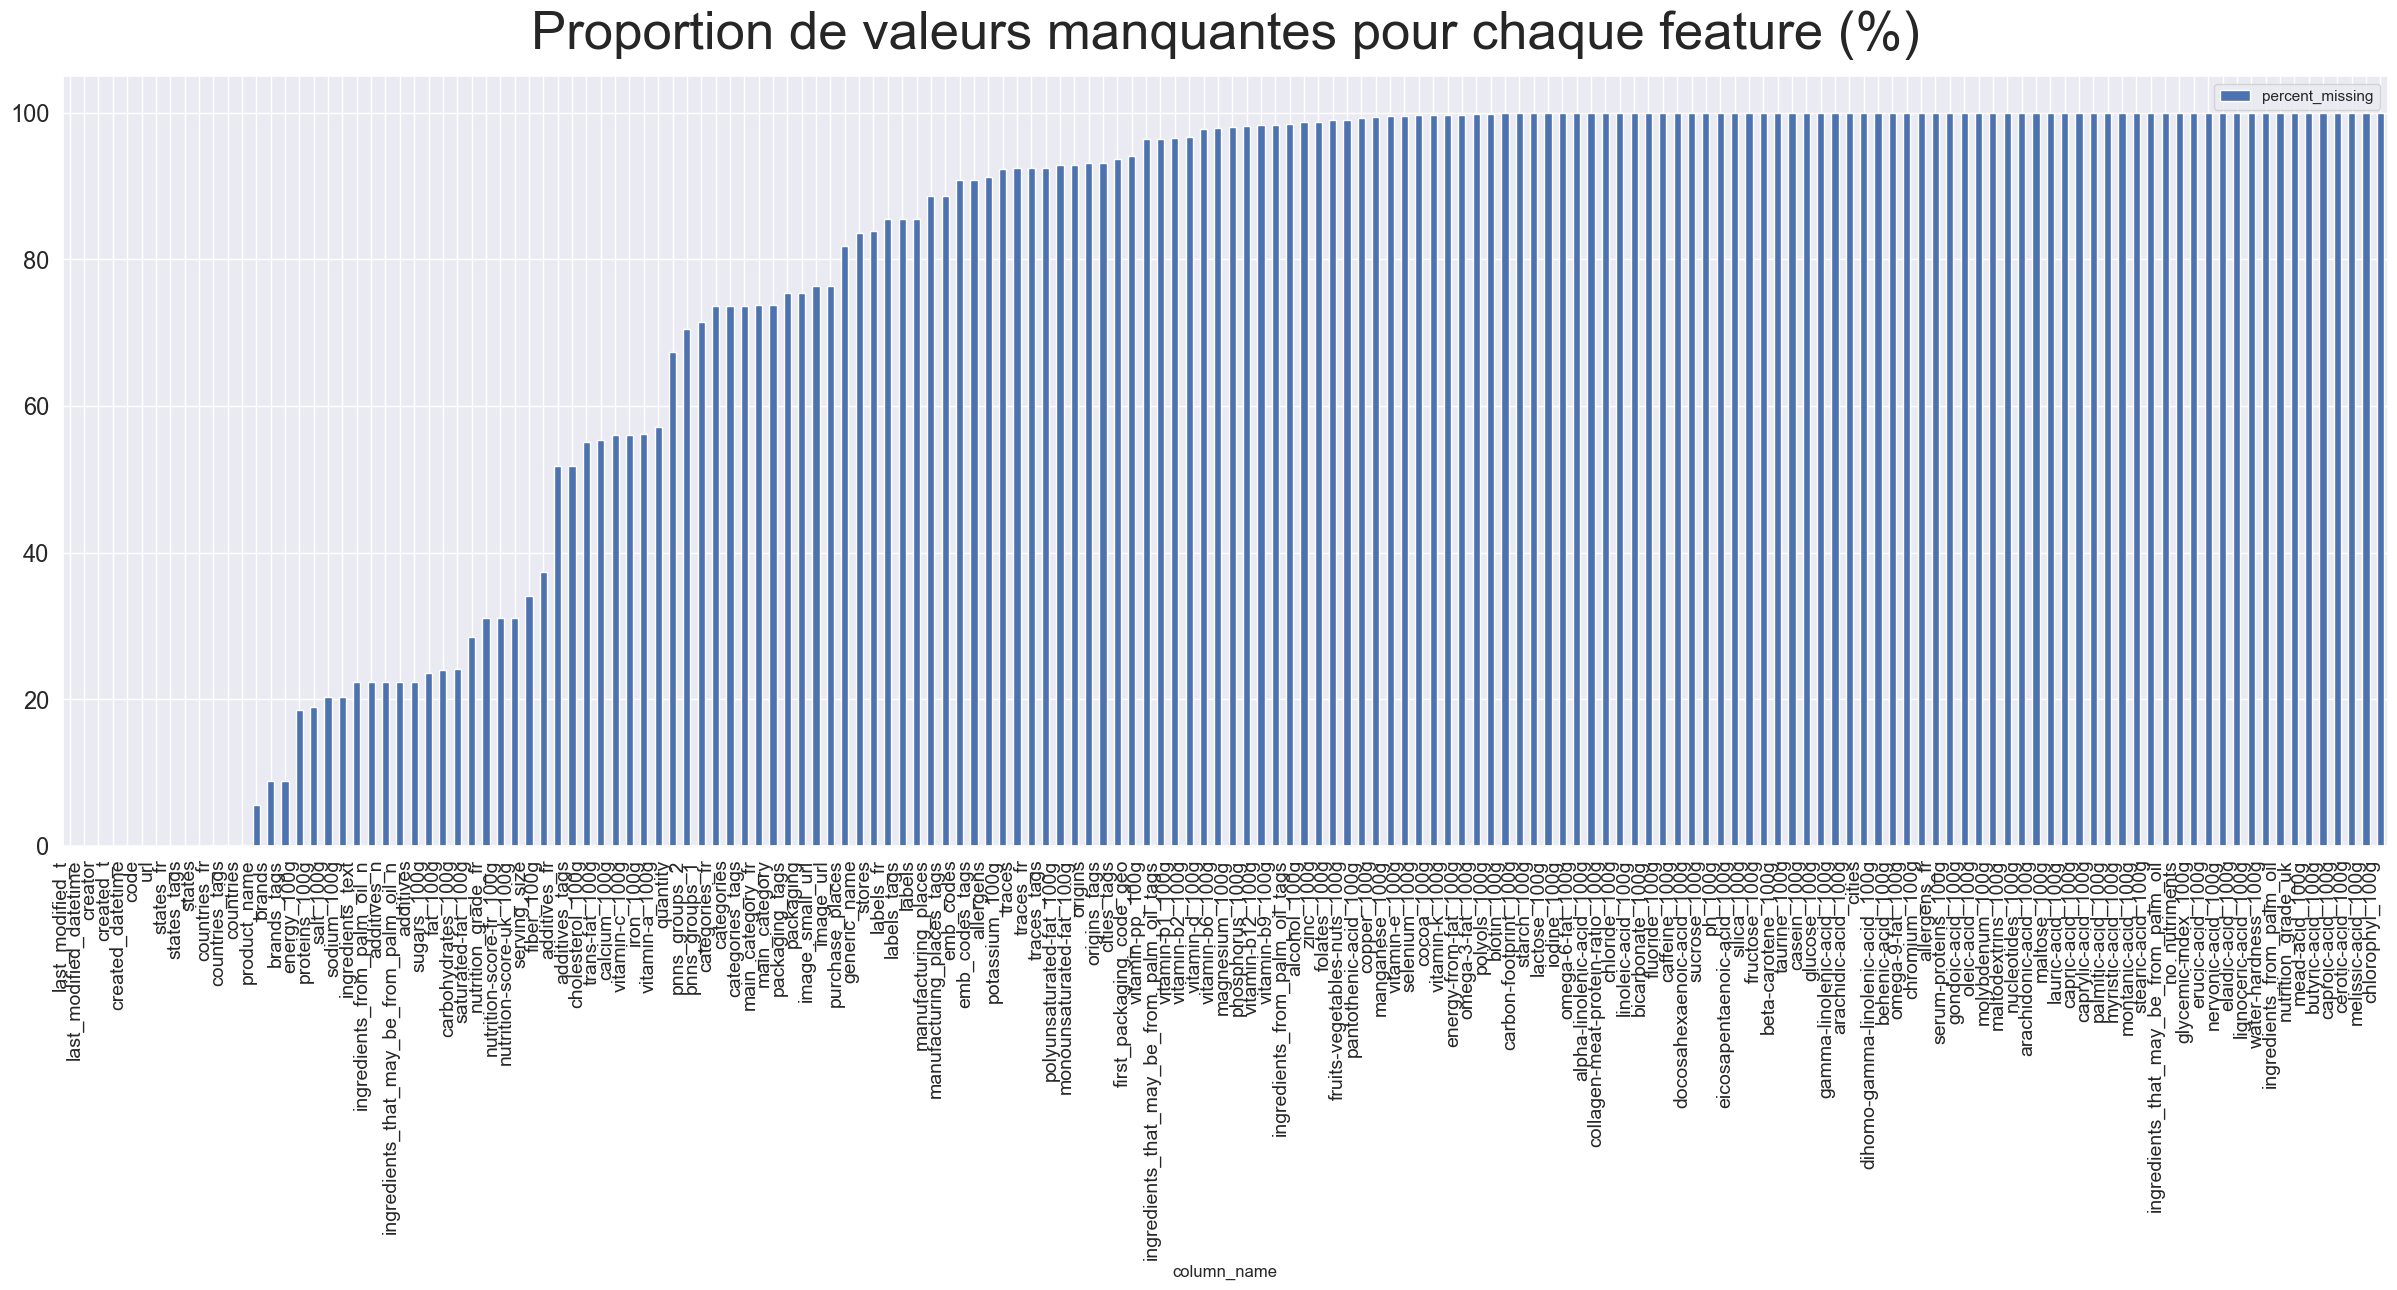

In [80]:
# A partir de quel seuil doit-on purement et simplement supprimer la colonne ??
# Pour aider notre prise de décision, visualisons :

missing_values_raw_df = get_missing_values(raw_df)

plt.rcParams["figure.figsize"] = (30,10)
plt.rcParams['axes.titlepad'] = 20

ax = missing_values_raw_df.plot.bar(x='column_name', y='percent_missing', rot=0, fontsize=17)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right', fontsize=14)
plt.title("Proportion de valeurs manquantes pour chaque feature (%)", fontsize=38)
# pad superflu du coup

plt.show()


### <a id="a7">[1.7 Valeurs manquantes : seuils intéressants](#toc)</a>

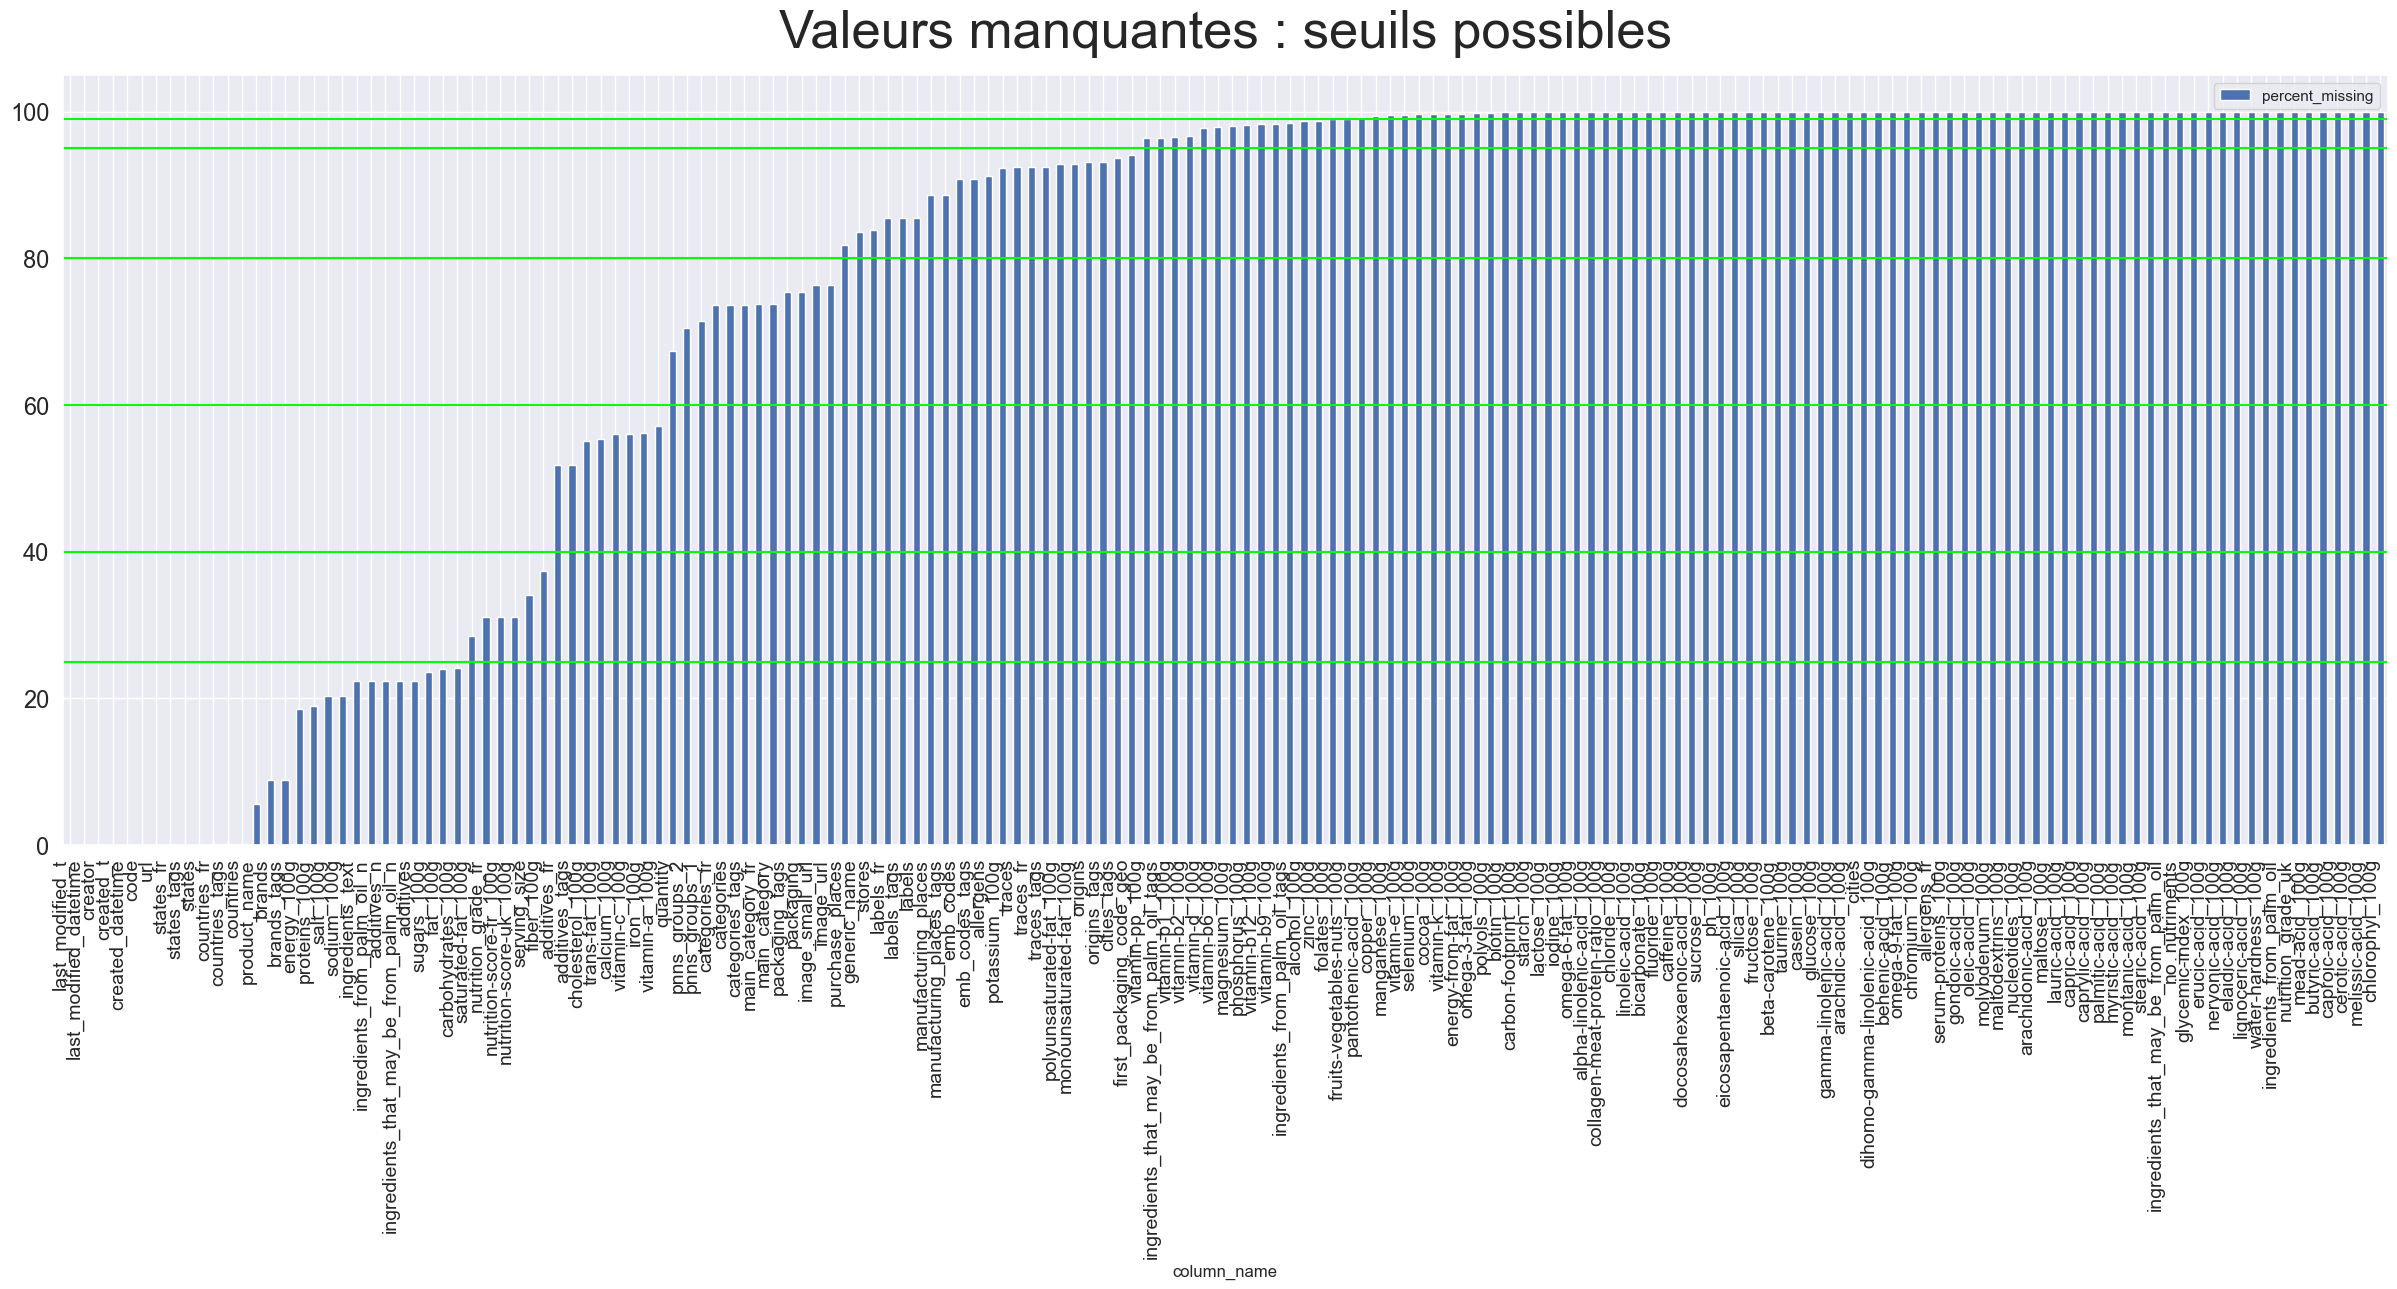

In [81]:
# On peut distinguer entre 4 et 6 plateaux, indiquant des seuils possibles intéressants

ax = missing_values_raw_df.plot.bar(x='column_name', y='percent_missing', rot=0, fontsize=17)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right', fontsize=14)
plt.axhline(y=25, color='#00ff00', linestyle='-')
plt.axhline(y=40, color='#00ff00', linestyle='-')
plt.axhline(y=60, color='#00ff00', linestyle='-')
plt.axhline(y=80, color='#00ff00', linestyle='-')
plt.axhline(y=95, color='#00ff00', linestyle='-')
plt.axhline(y=99, color='#00ff00', linestyle='-')
plt.title("Valeurs manquantes : seuils possibles", fontsize=38)
plt.show()


### <a id="a8">[1.8 Drop des colonnes vides ou quasi-vides](#toc)</a>

In [82]:
# Dans un premier temps, prenons un seuil très prudent, et n'éliminons que les features quasiment vides

# Une cinquantaine de variables (environ 1 tiers) possèdent - de 100 valeurs. C'est vraiment trop peu
# car même si ces variables sont potentiellement intéressantes, elles feraient chuter la qualité de notre
# analyse, la précision de nos modèles. Mieux vaut donc les mettre de côté pour l'instant.

variables_utilisables = missing_values_raw_df.loc[missing_values_raw_df['present'] > 100, 'column_name'].tolist()
# print(variables_utilisables)

raw_df_no_empty_cols = raw_df[variables_utilisables].copy() # deep=True par défaut

printn(raw_df_no_empty_cols.shape)


# 1 exemple de feature dropée : la caffeine

caffeine = raw_df[~raw_df['caffeine_100g'].isna()]
display(caffeine[['product_name', 'generic_name', 'caffeine_100g']].head(60))


(320772, 110) 



product_name  \
10316                             Amp Energy Cherry Blast   
59748                                           Coca-Cola   
59754                                      Coca-Cola Life   
75955                        Lettuce, Cos Or Romaine, Raw   
109169                                          Chocolate   
111433                                            Mtn Dew   
122459                                  Organic lemon tea   
127299                                              Pepsi   
127431                                   Cold Brew Coffee   
147003              Warrior, Conquer Energy Drink, Citrus   
147025          Kist, Sparkling Water, Cherry Pomegranate   
147215  Teeccino, Medium Roast Herbal Coffee, Vanilla Nut   
147216  Teeccino, Organic Medium Roast Herbal Coffee, ...   
147217  Teeccino, Organic French Dark Roast Herbal Coffee   
147218  Teeccino, Organic Dark Roast Herbal Coffee, Ch...   
147219  Teeccino, Organic Dandelion Dark Roast Herbal ...   
147220     Teeccino, Herbal Coffee, Dandelion Caramel Nut   
147221                        Mediterranean Herbal Coffee   
147222    Teeccino, Mediterranean Herbal Coffee, Hazelnut   
147224       Teeccino, French Roast Chicory Herbal Coffee   
152384                              Rockstar Energy Drink   
152966  Ecoteas, Yerba Mate Unsmoked Herbal Tea Supple...   
152967  Ecoteas, Holy Mate, Calm Energy Naturally Caff...   
158007                    Electrolyte Enhanced Drink Tabs   
158655  Spider, Rise Again!, Energy Drink Soda, Strawb...   
159566                  Grumppuccino Premium Coffee Drink   
162319              Karma, Wellness Water, Tropical Burst   
163139                        Aeroshot Energy Green Apple   
165307                                Energy Drink, Mango   
165308                       Soda, Strawberry, Watermelon   
166390                                      Almond Butter   
167682           Ol' Glory, Energy Drink, Original Citrus   
167683     Ol' Glory, Reload Energy Drink, Mango Lemonade   
167850  Raw Hide Coffee, Premium Blended Columbian Cof...   
171757         Casa Del Sol, Dark Roast Iced Coffee Drink   
174299            Energy Drink, Mojito, Lime, Lemon, Mint   
176285                                     Café Sélection   
180263                                               Cola   
182769                              Red Bull energy drink   
184364                                       Energy drink   
189646                                        Nescafé NES   
189663                            Nescafé NES fine mousse   
189669                                                Nes   
203380                     Energy drink à base de taurine   
226634                                      Energy Drink    
232481                           Matin léger café au lait   
244421                      Topslim 3 en 1 Goût framboise   
250837                         Portugal bebida energetica   
254520                                        Truc de fou   
254632  Reboost Thé noir Jus de mangue & touche de Can...   
254722                                       Energy Drink   
254724                             Energy Drink Goût Cola   
257341                                  afri cola Bonbons   
257503                                       Mio Mio Mate   
261555                                          Club-Mate   
262376                       Booster Classic Energy Drink   
264380                              Superman Energy Drink   
264456                                        flora Power   
266648                                        Frappuccino   
274655                              Lo-cal Monster Energy   

                                             generic_name  caffeine_100g  
10316                                                 NaN        0.03330  
59748                                                 NaN        0.00958  
59754                                Reduced Calorie Cola        0.00783  
75955                  

### <a id="a9">[1.9 Les dates](#toc)</a>

In [83]:
# A l'inverse, seules 37 variables ont un taux de valeurs manquantes inférieur à 50%.
# Nous allons donc les nettoyer en priorité, car si elles se révèlent pertinentes par la suite,
# ces colonnes seront les "piliers" de notre analyse

# Les dates
# Probablement pas pertinent, car ne concerne pas la production des produits, mais leur ajout/modif à la bdd
# Cependant nous vérifierons cela bientôt. Pour l'instant, observons et nettoyons !

# print(raw_df_no_empty_cols.loc[:5, 'last_modified_t'].tolist())
# ok, pas d'espace

# display_missing_values(raw_df_no_empty_cols)

printn(raw_df_no_empty_cols['created_datetime'].isna().sum())

display(raw_df_no_empty_cols[['created_datetime']].describe())

raw_df_no_empty_cols['created'] = pd.to_datetime(raw_df_no_empty_cols['created_datetime'], errors='coerce')
print(raw_df_no_empty_cols['created'].dtypes)

printn(raw_df_no_empty_cols['created'].isna().sum())

display(raw_df_no_empty_cols[['created']].describe(datetime_is_numeric=True))

printn(raw_df_no_empty_cols['created_t'].isna().sum())

raw_df_no_empty_cols['created_fs'] = pd.to_datetime(raw_df_no_empty_cols['created_t'], unit='s', errors='coerce')
print(raw_df_no_empty_cols['created'].dtypes)

printn(raw_df_no_empty_cols['created_fs'].isna().sum())

display(raw_df_no_empty_cols[['created_t']].describe())
display(raw_df_no_empty_cols[['created_fs']].describe(datetime_is_numeric=True))


9 



created_datetime
count                 320763
unique                189568
top     2017-03-09T16:32:00Z
freq                      20

datetime64[ns, UTC]
24 



created
count                               320748
mean   2016-08-08 03:29:48.115171840+00:00
min              2012-01-31 14:43:58+00:00
25%    2016-05-11 16:22:44.750000128+00:00
50%       2017-03-09 11:14:00.500000+00:00
75%    2017-03-09 16:57:29.249999872+00:00
max              2017-04-21 01:15:03+00:00

3 

datetime64[ns, UTC]
23 



created_t
count       320769
unique      189567
top     1489055829
freq            20

created_fs
count                         320749
mean   2016-08-08 02:13:23.137547008
min              1970-01-01 00:00:00
25%              2016-05-11 16:22:05
50%              2017-03-09 11:13:59
75%              2017-03-09 16:57:29
max              2017-04-21 01:15:03

In [84]:
print(raw_df_no_empty_cols.loc[raw_df_no_empty_cols['created'].notna()
                                 | raw_df_no_empty_cols['created_fs'].notna(), :].shape)

display(raw_df_no_empty_cols.loc[raw_df_no_empty_cols['created'].isna()
                                 | raw_df_no_empty_cols['created_fs'].isna(), :])



(320749, 112)


last_modified_t               last_modified_datetime  \
187478                       1488992055                 2017-03-08T16:54:15Z   
189068                  Belgique,France                 en:belgium,en:france   
189103                           France                            en:france   
189109  Belgique,France, en:switzerland  en:belgium,en:france,en:switzerland   
189119                           France                            en:france   
189152                           France                            en:france   
189160                           France                            en:france   
189162                           France                            en:france   
189168                           France                            en:france   
189242                           France                            en:france   
189244                           France                            en:france   
189248                           France                            en:france   
189250                           France                            en:france   
189260                           France                            en:france   
189262                           France                            en:france   
189269                           France                            en:france   
189272                           France                            en:france   
189345                           France                            en:france   
189362                           France                            en:france   
189364                           France                            en:france   
189379                           France                            en:france   
189404                    Suisse,France             en:france,en:switzerland   
189406                           France                            en:france   
189417                           France                            en:france   

                                                  creator  \
187478                                           marianne   
189068                  villecomtal-sur-arros-gers-france   
189103  villecomtal-sur-arros-gers-france,saint-just-c...   
189109                  villecomtal-sur-arros-gers-france   
189119                  villecomtal-sur-arros-gers-france   
189152                  villecomtal-sur-arros-gers-france   
189160                  villecomtal-sur-arros-gers-france   
189162                  villecomtal-sur-arros-gers-france   
189168                  villecomtal-sur-arros-gers-france   
189242                  villecomtal-sur-arros-gers-france   
189244                  villecomtal-sur-arros-gers-france   
189248                  villecomtal-sur-arros-gers-france   
189250                  villecomtal-sur-arros-gers-france   
189260                  villecomtal-sur-arros-gers-france   
189262                  villecomtal-sur-arros-gers-france   
189269                  villecomtal-sur-arros-gers-france   
189272                  villecomtal-sur-arros-gers-france   
189345  villecomtal-sur-arros-gers-france,saint-just-c...   
189362                  villecomtal-sur-arros-gers-france   
189364                  villecomtal-sur-arros-gers-france   
189379                  villecomtal-sur-arros-gers-france   
189404                  villecomtal-sur-arros-gers-france   
189406                  villecomtal-sur-arros-gers-france   
189417                  villecomtal-sur-arros-gers-france   

                                    created_t           created_datetime  \
187478                                      0                        NaN   
189068                                 France                        NaN   
189103       Villecresnes,Villeurbanne,France                Dia,Sogeres   
189109                                 France                        NaN   
189119                          Veynes,France                     SuperU   
189152                        Torcy 77,Fr

In [85]:
display(raw_df_no_empty_cols.loc[raw_df_no_empty_cols['creator'] == 'marianne', :])

display(raw_df_no_empty_cols[['created']].describe(datetime_is_numeric=True)) 

raw_df_no_empty_cols.loc[(raw_df_no_empty_cols['creator'] == 'marianne')
                         & (raw_df_no_empty_cols['created_t'] == '0'), 
                         'created'] = pd.to_datetime(1334157000, unit='s', utc=True)


display(raw_df_no_empty_cols[['created']].describe(datetime_is_numeric=True))
print(raw_df_no_empty_cols['created'].dtypes)


last_modified_t last_modified_datetime   creator   created_t  \
187478      1488992055   2017-03-08T16:54:15Z  marianne           0   
212131      1459016622   2016-03-26T18:23:42Z  marianne  1328971867   
219215      1354706633   2012-12-05T11:23:53Z  marianne  1338044794   
277568      1492100976   2017-04-13T16:29:36Z  marianne  1334154510   
314574      1478151700   2016-11-03T05:41:40Z  marianne  1334155847   

            created_datetime           code  \
187478                   NaN  3017760038409   
212131  2012-02-11T14:51:07Z  3257980112590   
219215  2012-05-26T15:06:34Z  3270160611485   
277568  2012-04-11T14:28:30Z  5410041040807   
314574  2012-04-11T14:50:47Z  8712566151615   

                                                      url  \
187478  http://world-fr.openfoodfacts.org/produit/3017...   
212131  http://world-fr.openfoodfacts.org/produit/3257...   
219215  http://world-fr.openfoodfacts.org/produit/3270...   
277568  http://world-fr.openfoodfacts.org/produit/5410...   
314574  http://world-fr.openfoodfacts.org/produit/8712...   

                                                states_fr  \
187478  A vérifier,Complet,Informations nutritionnelle...   
212131  A vérifier,Complet,Informations nutritionnelle...   
219215  A vérifier,Complet,Informations nutritionnelle...   
277568  A vérifier,Complet,Informations nutritionnelle...   
314574  A vérifier,Complet,Informations nutritionnelle...   

                                              states_tags  \
187478  en:to-be-checked,en:complete,en:nutrition-fact...   
212131  en:to-be-checked,en:complete,en:nutrition-fact...   
219215  en:to-be-checked,en:complete,en:nutrition-fact...   
277568  en:to-be-checked,en:complete,en:nutrition-fact...   
314574  en:to-be-checked,en:complete,en:nutrition-fact...   

                                                   states  \
187478  en:to-be-checked, en:complete, en:nutrition-fa...   
212131  en:to-be-checked, en:complete, en:nutrition-fa...   
219215  en:to-be-checked, en:complete, en:nutrition-fa...   
277568  en:to-be-checked, en:complete, en:nutrition-fa...   
314574  en:to-be-checked, en:complete, en:nutrition-fa...   

                        countries_fr  \
187478                 France,Suisse   
212131                        France   
219215                        France   
277568  Belgique,France,Maroc,Suisse   
314574                        France   

                                        countries_tags  \
187478                        en:france,en:switzerland   
212131                                       en:france   
219215                                       en:france   
277568  en:belgium,en:france,en:morocco,en:switzerland   
314574                                       en:france   

                           countries                  product_name  \
187478                 France,Suisse    Lulu la barquette (Fraise)   
212131                        France                      Boudoirs   
219215                        France                     La fraise   
277568  Belgique,France,Maroc,Suisse               Pim's Framboise   
314574                        France  Infusion Bio Verveine Menthe   

                        brands             brands_tags  energy_100g  \
187478                      LU                      lu       1480.0   
212131                    Cora                    cora       1637.0   
219215  François Théron,Picard  francois-theron,picard        335.0   
277568    Pim's,Lu,Kraft Foods    pim-s,lu,kraft-foods       1675.0   
314574       ELEPHANT,Unilever       elephant,unilever         17.0   

        proteins_100g  salt_100g  sodium_100g  \
187478            4.2      0.080     0.031496   
212131            7.6      0.381     0.150000   
219215            0.7        NaN          NaN   
277568            3.6      0.280     0.110236   
314574            0.5      0.000     0.000000   

                                         ingredients_text  \
187478  Sirop de glucose-fructose, 

created
count                               320748
mean   2016-08-08 03:29:48.115171840+00:00
min              2012-01-31 14:43:58+00:00
25%    2016-05-11 16:22:44.750000128+00:00
50%       2017-03-09 11:14:00.500000+00:00
75%    2017-03-09 16:57:29.249999872+00:00
max              2017-04-21 01:15:03+00:00

created
count                               320749
mean   2016-08-08 03:22:42.642331136+00:00
min              2012-01-31 14:43:58+00:00
25%              2016-05-11 16:22:05+00:00
50%              2017-03-09 11:13:59+00:00
75%              2017-03-09 16:57:29+00:00
max              2017-04-21 01:15:03+00:00

datetime64[ns, UTC]


In [86]:
# Pas de nvelle entrée depuis avril 2017 ??
# On retrouve nos 23 (24) individus très suspects !
# Il y a vraiment un problème avec ces lignes, les seules comportant des erreurs lexicales dans les dates !
# ce qui est curieux. Peut-être s'agit-il d'un test lors de la création de la db ?
# Dans le doute il parait plus sûr de supprimer ces 23 lignes.

short_df = raw_df_no_empty_cols.loc[raw_df_no_empty_cols['code'].notna(), :].copy()
printn(short_df.shape)

# Maintenant, est-ce que les dates correspondent ?

display(short_df[['created', 'created_datetime']].head())
print('\n')

display(raw_df_no_empty_cols[['created']].describe(datetime_is_numeric=True))

display(short_df[['created']].describe(datetime_is_numeric=True))
print('\n')


(320749, 112) 



created      created_datetime
0 2016-09-17 09:17:46+00:00  2016-09-17T09:17:46Z
1 2017-03-09 14:32:37+00:00  2017-03-09T14:32:37Z
2 2017-03-09 14:32:37+00:00  2017-03-09T14:32:37Z
3 2017-03-09 10:35:31+00:00  2017-03-09T10:35:31Z
4 2017-03-09 10:34:13+00:00  2017-03-09T10:34:13Z

created
count                               320749
mean   2016-08-08 03:22:42.642331136+00:00
min              2012-01-31 14:43:58+00:00
25%              2016-05-11 16:22:05+00:00
50%              2017-03-09 11:13:59+00:00
75%              2017-03-09 16:57:29+00:00
max              2017-04-21 01:15:03+00:00

created
count                               320749
mean   2016-08-08 03:22:42.642330880+00:00
min              2012-01-31 14:43:58+00:00
25%              2016-05-11 16:22:05+00:00
50%              2017-03-09 11:13:59+00:00
75%              2017-03-09 16:57:29+00:00
max              2017-04-21 01:15:03+00:00

In [87]:
# Pour notre étude inutile de garder les 2 formats d'origine
# (type object, stamp ou string)
# Inutile aussi de garder les dates de modif, nous ne les utiliserons pas.

# Nous allons donc conserver seulement notre nouvelle variable,
# la feature 'created', qui n'a pas d'outliers (1970)

shortish_df = short_df.drop(['last_modified_datetime', 
                             'created_datetime', 
                             'last_modified_t', 
                             'created_t', 
                             'created_fs'], axis=1).copy()
print(shortish_df.shape)

# type datetime64 -> float      Moins facile à lire ! 
# mais plus facile à lire et manipuler pour la matrice de correlation

display(shortish_df.head())


(320749, 107)


creator           code  \
0  openfoodfacts-contributors  0000000003087   
1             usda-ndb-import  0000000004530   
2             usda-ndb-import  0000000004559   
3             usda-ndb-import  0000000016087   
4             usda-ndb-import  0000000016094   

                                                 url  \
0  http://world-fr.openfoodfacts.org/produit/0000...   
1  http://world-fr.openfoodfacts.org/produit/0000...   
2  http://world-fr.openfoodfacts.org/produit/0000...   
3  http://world-fr.openfoodfacts.org/produit/0000...   
4  http://world-fr.openfoodfacts.org/produit/0000...   

                                           states_fr  \
0  A compléter,Informations nutritionnelles à com...   
1  A compléter,Informations nutritionnelles compl...   
2  A compléter,Informations nutritionnelles compl...   
3  A compléter,Informations nutritionnelles compl...   
4  A compléter,Informations nutritionnelles compl...   

                                         states_tags  \
0  en:to-be-completed,en:nutrition-facts-to-be-co...   
1  en:to-be-completed,en:nutrition-facts-complete...   
2  en:to-be-completed,en:nutrition-facts-complete...   
3  en:to-be-completed,en:nutrition-facts-complete...   
4  en:to-be-completed,en:nutrition-facts-complete...   

                                              states countries_fr  \
0  en:to-be-completed, en:nutrition-facts-to-be-c...       France   
1  en:to-be-completed, en:nutrition-facts-complet...   États-Unis   
2  en:to-be-completed, en:nutrition-facts-complet...   États-Unis   
3  en:to-be-completed, en:nutrition-facts-complet...   États-Unis   
4  en:to-be-completed, en:nutrition-facts-complet...   États-Unis   

     countries_tags countries                    product_name  \
0         en:france     en:FR              Farine de blé noir   
1  en:united-states        US  Banana Chips Sweetened (Whole)   
2  en:united-states        US                         Peanuts   
3  en:united-states        US          Organic Salted Nut Mix   
4  en:united-states        US                 Organic Polenta   

            brands      brands_tags  energy_100g  proteins_100g  salt_100g  \
0  Ferme t'y R'nao  ferme-t-y-r-nao          NaN            NaN        NaN   
1              NaN              NaN       2243.0           3.57    0.00000   
2   Torn & Glasser     torn-glasser       1941.0          17.86    0.63500   
3        Grizzlies        grizzlies       2540.0          17.86    1.22428   
4   Bob's Red Mill   bob-s-red-mill       1552.0           8.57        NaN   

   sodium_100g                                   ingredients_text  \
0          NaN                                                NaN   
1        0.000  Bananas, vegetable oil (coconut oil, corn oil ...   
2        0.250  Peanuts, wheat flour, sugar, rice flour, tapio...   
3        0.482  Organic hazelnuts, organic cashews, organic wa...   
4          NaN                                    Organic polenta   

   ingredients_from_palm_oil_n  additives_n  \
0                          NaN          NaN   
1                          0.0          0.0   
2                          0.0          0.0   
3                          0.0          0.0   
4                          0.0          0.0   

   ingredients_that_may_be_from_palm_oil_n  \
0                                      NaN   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

                                           additives  sugars_100g  fat_100g  \
0                                                NaN          NaN       NaN   
1   [ bananas -> en:bananas  ]  [ vegetable-oil -...        14.29     28.57   
2   [ peanuts -> en:peanuts  ]  [ wheat-flour -> ...        17.86     17.86   
3   [ organic-hazelnuts -> en:organic-hazelnuts  ...         3.57     57.14   
4   [ organic-polenta -> en:organic-polenta  ]  [...          NaN      1.43  

In [88]:
display_missing_values(shortish_df)


column_name  \
code                                                                              code   
url                                                                                url   
created                                                                        created   
creator                                                                        creator   
states_tags                                                                states_tags   
states                                                                          states   
states_fr                                                                    states_fr   
countries_fr                                                              countries_fr   
countries_tags                                                          countries_tags   
countries                                                                    countries   
product_name                                                              product_name   
brands                                                                          brands   
brands_tags                                                                brands_tags   
energy_100g                                                                energy_100g   
proteins_100g                                                            proteins_100g   
salt_100g                                                                    salt_100g   
sodium_100g                                                                sodium_100g   
ingredients_text                                                      ingredients_text   
additives_n                                                                additives_n   
ingredients_that_may_be_from_palm_oil_n        ingredients_that_may_be_from_palm_oil_n   
ingredients_from_palm_oil_n                                ingredients_from_palm_oil_n   
additives                                                                    additives   
sugars_100g                                                                sugars_100g   
fat_100g                                                                      fat_100g   
carbohydrates_100g                                                  carbohydrates_100g   
saturated-fat_100g                                                  saturated-fat_100g   
nutrition_grade_fr                                                  nutrition_grade_fr   
nutrition-score-uk_100g                                        nutrition-score-uk_100g   
nutrition-score-fr_100g                                        nutrition-score-fr_100g   
serving_size                                                              serving_size   
fiber_100g                                                                  fiber_100g   
additives_tags                                                          additives_tags   
additives_fr                                                              additives_fr   
cholesterol_100g                                                      cholesterol_100g   
trans-fat_100g                                                          trans-fat_100g   
calcium_100g                                                              calcium_100g   
vitamin-c_100g                                                          vitamin-c_100g   
iron_100g                                                                    iron_100g   
vitamin-a_100g                                                          vitamin-a_100g   
quantity                                                                      quantity   
pnns_groups_2                                                            pnns_groups_2   
pnns_groups_1                                                            pnns_groups_1   
categories                                                                  categories   
categories_fr                                                            categories_fr   
categories_tags          

### <a id="a10">[1.10 'creator'](#toc)</a>

In [89]:
display(shortish_df.loc[shortish_df['creator'].isna(), :])
print(shortish_df.shape)

# Complètement vide à part country, brand, picture et champs auto (8 premières colonnes)
# Nous allons donc supprimer ces 2 lignes.

slightly_shorter_df = shortish_df.loc[shortish_df['creator'].notna(), :].copy()
print(slightly_shorter_df.shape)


creator           code  \
273670     NaN  5052449755961   
274024     NaN  5054070648872   

                                                      url  \
273670  http://world-fr.openfoodfacts.org/produit/5052...   
274024  http://world-fr.openfoodfacts.org/produit/5054...   

                                                states_fr  \
273670  A compléter,Informations nutritionnelles à com...   
274024  A compléter,Informations nutritionnelles à com...   

                                              states_tags  \
273670  en:to-be-completed,en:nutrition-facts-to-be-co...   
274024  en:to-be-completed,en:nutrition-facts-to-be-co...   

                                                   states countries_fr  \
273670  en:to-be-completed, en:nutrition-facts-to-be-c...  Royaume-Uni   
274024  en:to-be-completed, en:nutrition-facts-to-be-c...  Royaume-Uni   

           countries_tags       countries  \
273670  en:united-kingdom  United Kingdom   
274024  en:united-kingdom  United Kingdom   

                                             product_name brands brands_tags  \
273670                                                NaN   Asda        asda   
274024  Slow cooked steak & gravy deep fill puff pastr...   Asda        asda   

        energy_100g  proteins_100g  salt_100g  sodium_100g ingredients_text  \
273670          NaN            NaN        NaN          NaN              NaN   
274024          NaN            NaN        NaN          NaN              NaN   

        ingredients_from_palm_oil_n  additives_n  \
273670                          NaN          NaN   
274024                          NaN          NaN   

        ingredients_that_may_be_from_palm_oil_n additives  sugars_100g  \
273670                                      NaN       NaN          NaN   
274024                                      NaN       NaN          NaN   

        fat_100g  carbohydrates_100g  saturated-fat_100g nutrition_grade_fr  \
273670       NaN                 NaN                 NaN                NaN   
274024       NaN                 NaN                 NaN                NaN   

        nutrition-score-fr_100g  nutrition-score-uk_100g serving_size  \
273670                      NaN                      NaN          NaN   
274024                      NaN                      NaN          NaN   

        fiber_100g additives_fr additives_tags  cholesterol_100g  \
273670         NaN          NaN            NaN               NaN   
274024         NaN          NaN            NaN               NaN   

        trans-fat_100g  calcium_100g  vitamin-c_100g  iron_100g  \
273670             NaN           NaN             NaN        NaN   
274024             NaN           NaN             NaN        NaN   

        vitamin-a_100g quantity pnns_groups_2 pnns_groups_1 categories_fr  \
273670             NaN      NaN       unknown       unknown           NaN   
274024             NaN      NaN       unknown       unknown           NaN   

       categories categories_tags main_category_fr main_category  \
273670        NaN             NaN              NaN           NaN   
274024        NaN             NaN              NaN           NaN   

       packaging_tags packaging  \
273670            NaN       NaN   
274024            NaN       NaN   

                                          image_small_url  \
273670  http://fr.openfoodfacts.org/images/products/50...   
274024  http://fr.openfoodfacts.org/images/products/50...   

                                                image_url purchase_places  \
273670  http://fr.openfoodfacts.org/images/products/50...             NaN   
274024  http://fr.openfoodfacts.org/images/products/50...             NaN   

       generic_name stores labels_fr labels_tags labels manufacturing_places  \
273670          NaN    NaN       NaN         NaN    NaN                  NaN   
274024          NaN    NaN       NaN         NaN    NaN                  NaN   

       manufacturing_places_tags emb_codes emb_codes_tags allergens  \
2

(320749, 107)
(320747, 107)


### <a id="a11">[1.11 Valeurs manquantes en fonction des individus](#toc)</a>

count    320747.000000
mean         71.480996
std          11.615001
min          21.000000
25%          66.000000
50%          69.000000
75%          79.000000
max         100.000000
dtype: float64

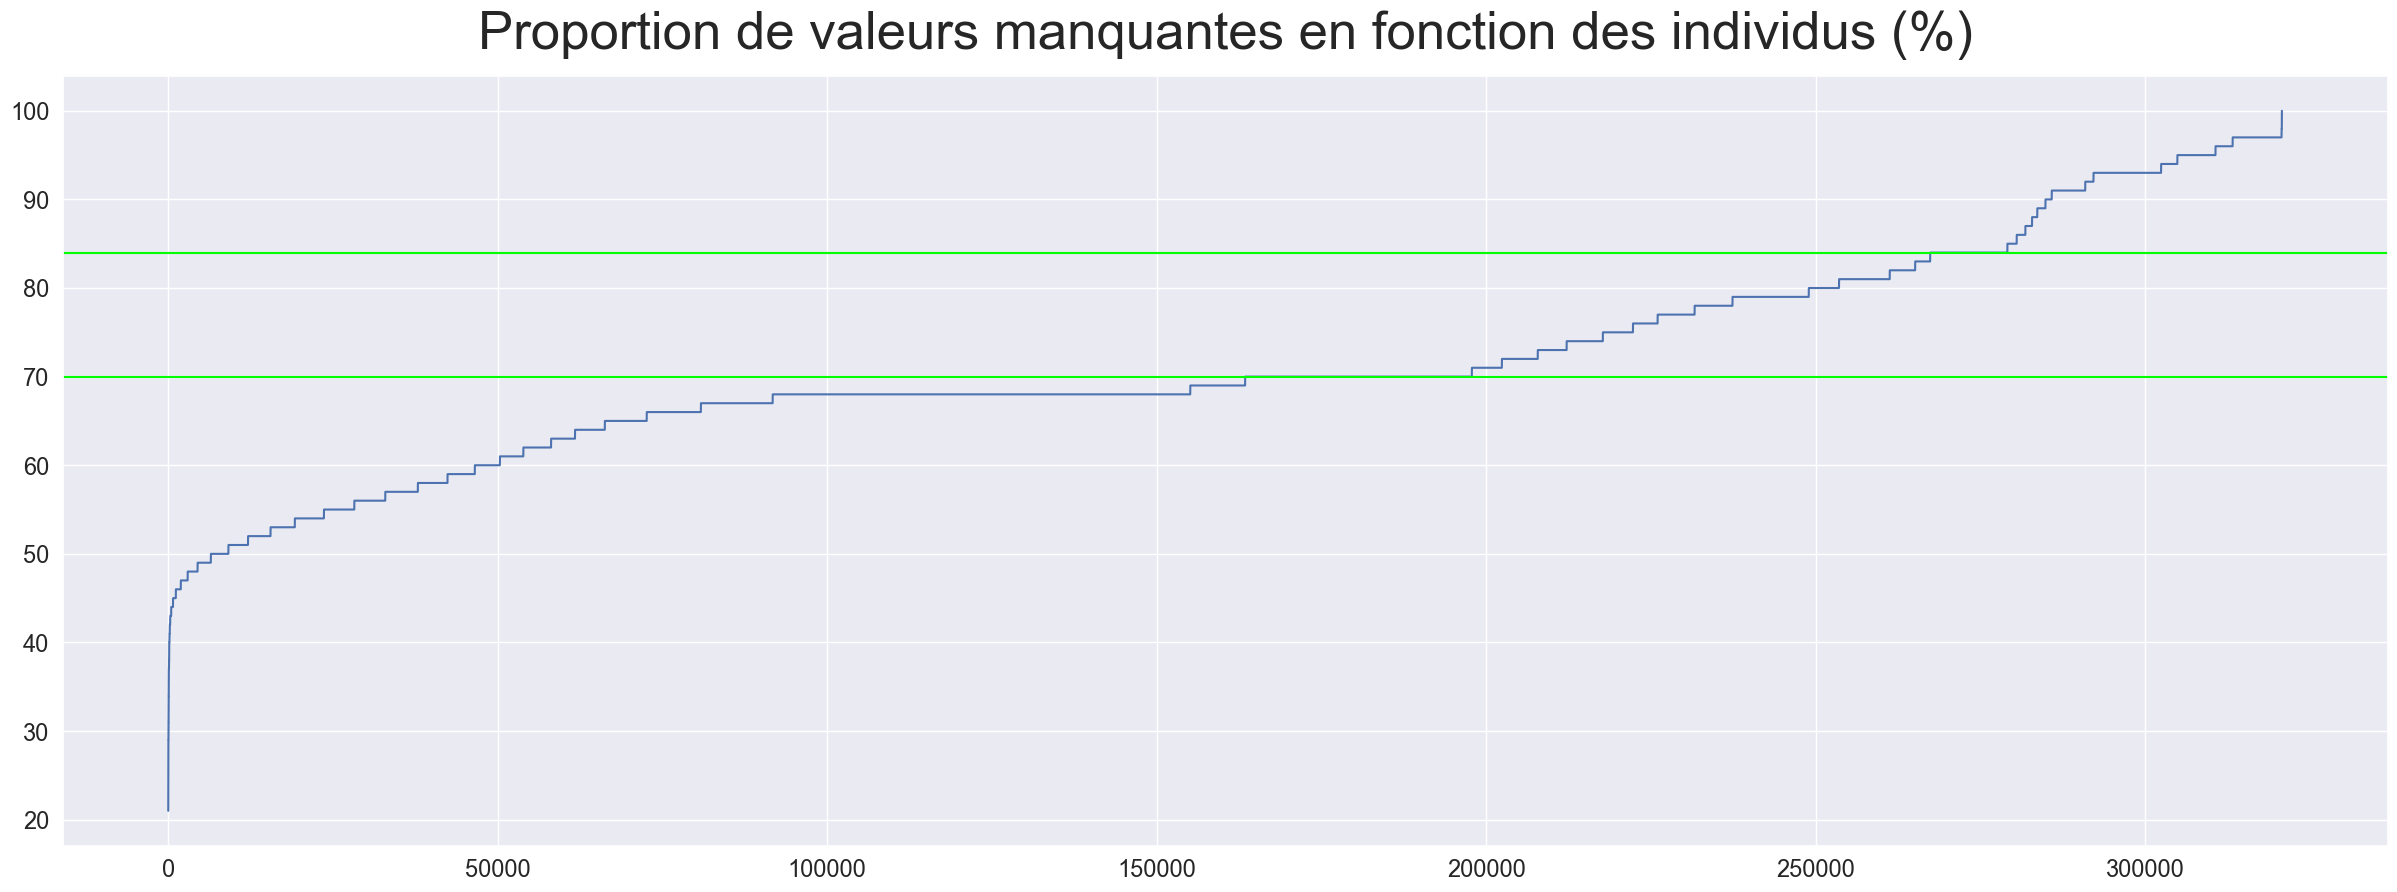

In [90]:
# C'est aussi l'occasion d'observer nos valeurs manquantes en fonction des individus

nan_count = slightly_shorter_df.isna().sum(axis = 1)
nan_count.sort_values(inplace=True, ignore_index=True)
display(nan_count.describe())

nan_count.plot(fontsize=17)
plt.axhline(y=70, color='#00ff00', linestyle='-')
plt.axhline(y=84, color='#00ff00', linestyle='-')

plt.title("Proportion de valeurs manquantes en fonction des individus (%)", fontsize=38)
plt.show()


### <a id="a12">[1.12 Drop des lignes vides](#toc)</a>

In [91]:
display(slightly_shorter_df.loc[slightly_shorter_df.isna().sum(axis = 1) == 100, :])
print(slightly_shorter_df.shape)

shorter_df = slightly_shorter_df.loc[slightly_shorter_df.isna().sum(axis = 1) < 100, :].copy()
print(shorter_df.shape)

# Ici on devrait peut-être enlever davantage ?


creator           code  \
175246  openfoodfacts-contributors       19043514   
199396  openfoodfacts-contributors  3213827080156   
218531  openfoodfacts-contributors  3267620200075   
226856  openfoodfacts-contributors  3347439978317   
255838  openfoodfacts-contributors  3948719255151   

                                                      url  \
175246  http://world-fr.openfoodfacts.org/produit/1904...   
199396  http://world-fr.openfoodfacts.org/produit/3213...   
218531  http://world-fr.openfoodfacts.org/produit/3267...   
226856  http://world-fr.openfoodfacts.org/produit/3347...   
255838  http://world-fr.openfoodfacts.org/produit/3948...   

                                                states_fr  \
175246  A compléter,Informations nutritionnelles à com...   
199396  A compléter,Informations nutritionnelles à com...   
218531  A compléter,Informations nutritionnelles à com...   
226856  A compléter,Informations nutritionnelles à com...   
255838  A compléter,Informations nutritionnelles à com...   

                                              states_tags  \
175246  en:to-be-completed,en:nutrition-facts-to-be-co...   
199396  en:to-be-completed,en:nutrition-facts-to-be-co...   
218531  en:to-be-completed,en:nutrition-facts-to-be-co...   
226856  en:to-be-completed,en:nutrition-facts-to-be-co...   
255838  en:to-be-completed,en:nutrition-facts-to-be-co...   

                                                   states countries_fr  \
175246  en:to-be-completed, en:nutrition-facts-to-be-c...          NaN   
199396  en:to-be-completed, en:nutrition-facts-to-be-c...          NaN   
218531  en:to-be-completed, en:nutrition-facts-to-be-c...          NaN   
226856  en:to-be-completed, en:nutrition-facts-to-be-c...          NaN   
255838  en:to-be-completed, en:nutrition-facts-to-be-c...          NaN   

       countries_tags countries product_name brands brands_tags  energy_100g  \
175246            NaN       NaN          NaN    NaN         NaN          NaN   
199396            NaN       NaN          NaN    NaN         NaN          NaN   
218531            NaN       NaN          NaN    NaN         NaN          NaN   
226856            NaN       NaN          NaN    NaN         NaN          NaN   
255838            NaN       NaN          NaN    NaN         NaN          NaN   

        proteins_100g  salt_100g  sodium_100g ingredients_text  \
175246            NaN        NaN          NaN              NaN   
199396            NaN        NaN          NaN              NaN   
218531            NaN        NaN          NaN              NaN   
226856            NaN        NaN          NaN              NaN   
255838            NaN        NaN          NaN              NaN   

        ingredients_from_palm_oil_n  additives_n  \
175246                          NaN          NaN   
199396                          NaN          NaN   
218531                          NaN          NaN   
226856                          NaN          NaN   
255838                          NaN          NaN   

        ingredients_that_may_be_from_palm_oil_n additives  sugars_100g  \
175246                                      NaN       NaN          NaN   
199396                                      NaN       NaN          NaN   
218531                                      NaN       NaN          NaN   
226856                                      NaN       NaN          NaN   
255838                                      NaN       NaN          NaN   

        fat_100g  carbohydrates_100g  saturated-fat_100g nutrition_grade_fr  \
175246       NaN                 NaN                 NaN                NaN   
199396       NaN                 NaN                 NaN                NaN   
218531       NaN                 NaN                 NaN                NaN   
226856       NaN                 NaN                 NaN                NaN   
255838       NaN                 NaN                 NaN                NaN   

        nutrition-score-fr_100g  nutrition-score-uk

(320747, 107)
(320742, 107)


### <a id="a13">[1.13 Feature auto : 'states' (le retour des yaourths)](#toc)</a>

In [92]:
# Il nous reste 3 variables possédant très peu de valeurs manquantes

display(shorter_df.loc[shorter_df['states'].isna(), :].shape)
# Encore un gpe de 23 yaourths suspects !

display(shorter_df.loc[shorter_df['states'].isna(), :])


(23, 107)

creator           code  \
189067                    penelope  3033490433864   
189102  openfoodfacts-contributors  3033490594510   
189108                       r-one  3033490595517   
189118  openfoodfacts-contributors  3033490618889   
189151                    nutrigil  3033490841782   
189159  openfoodfacts-contributors  3033490853570   
189161                    jeanbono  3033490853587   
189167  openfoodfacts-contributors  3033490853884   
189241                     jacob80  3033490917418   
189243                     jacob80  3033490917425   
189247  openfoodfacts-contributors  3033490917456   
189249                      aleene  3033490917463   
189259                     phoenix  3033490958008   
189261                     jacob80  3033490958213   
189268  openfoodfacts-contributors  3033490958541   
189271                    jeanbono  3033490958589   
189344             date-limite-app  3033491046308   
189361                      tacite  3033491111013   
189363                      tacite  3033491111051   
189378                      tacite  3033491128981   
189403  openfoodfacts-contributors  3033491143014   
189405                    cestki13  3033491143021   
189416                    jeanbono  3033495125016   

                                                      url states_fr  \
189067  http://world-fr.openfoodfacts.org/produit/3033...       NaN   
189102  http://world-fr.openfoodfacts.org/produit/3033...       NaN   
189108  http://world-fr.openfoodfacts.org/produit/3033...       NaN   
189118  http://world-fr.openfoodfacts.org/produit/3033...       NaN   
189151  http://world-fr.openfoodfacts.org/produit/3033...       NaN   
189159  http://world-fr.openfoodfacts.org/produit/3033...       NaN   
189161  http://world-fr.openfoodfacts.org/produit/3033...       NaN   
189167  http://world-fr.openfoodfacts.org/produit/3033...       NaN   
189241  http://world-fr.openfoodfacts.org/produit/3033...       NaN   
189243  http://world-fr.openfoodfacts.org/produit/3033...       NaN   
189247  http://world-fr.openfoodfacts.org/produit/3033...       NaN   
189249  http://world-fr.openfoodfacts.org/produit/3033...       NaN   
189259  http://world-fr.openfoodfacts.org/produit/3033...       NaN   
189261  http://world-fr.openfoodfacts.org/produit/3033...       NaN   
189268  http://world-fr.openfoodfacts.org/produit/3033...       NaN   
189271  http://world-fr.openfoodfacts.org/produit/3033...       NaN   
189344  http://world-fr.openfoodfacts.org/produit/3033...       NaN   
189361  http://world-fr.openfoodfacts.org/produit/3033...       NaN   
189363  http://world-fr.openfoodfacts.org/produit/3033...       NaN   
189378  http://world-fr.openfoodfacts.org/produit/3033...       NaN   
189403  http://world-fr.openfoodfacts.org/produit/3033...       NaN   
189405  http://world-fr.openfoodfacts.org/produit/3033...       NaN   
189416  http://world-fr.openfoodfacts.org/produit/3033...       NaN   

       states_tags states countries_fr countries_tags countries  \
189067         NaN    NaN          NaN            NaN       NaN   
189102         NaN    NaN          NaN            NaN       NaN   
189108         NaN    NaN          NaN            NaN       NaN   
189118         NaN    NaN          NaN            NaN       NaN   
189151         NaN    NaN          NaN            NaN       NaN   
189159         NaN    NaN          NaN            NaN       NaN   
189161         NaN    NaN          NaN            NaN       NaN   
189167         NaN    NaN          NaN            NaN       NaN   
189241         NaN    NaN          NaN            NaN       NaN   
189243         NaN    NaN          NaN            NaN       NaN   
189247         NaN    NaN          NaN            NaN       NaN   
189249         NaN    NaN          NaN            NaN       NaN   
189259         NaN    NaN          NaN            NaN       NaN   
189261         NaN    NaN          NaN            NaN       NaN   
189268         NaN    NaN          NaN      

In [93]:
printn(shorter_df.loc[shorter_df['states'].isna()].isna().sum(axis = 1))

# Lignes quasi vides

# jeanbono, cestki13, tacite
# Aucune info nutritionnelle

print(shorter_df.shape)

even_shorter_df = shorter_df.loc[~shorter_df['states'].isna(), :].copy()

print(even_shorter_df.shape)


189067    88
189102    85
189108    85
189118    88
189151    90
189159    85
189161    85
189167    91
189241    85
189243    85
189247    85
189249    87
189259    87
189261    85
189268    85
189271    85
189344    85
189361    87
189363    85
189378    87
189403    85
189405    85
189416    85
dtype: int64 

(320742, 107)


(320719, 107)


In [94]:
display_missing_values(even_shorter_df)


column_name  \
creator                                                                        creator   
code                                                                              code   
states_fr                                                                    states_fr   
url                                                                                url   
states                                                                          states   
created                                                                        created   
states_tags                                                                states_tags   
countries_fr                                                              countries_fr   
countries_tags                                                          countries_tags   
countries                                                                    countries   
product_name                                                              product_name   
brands                                                                          brands   
brands_tags                                                                brands_tags   
energy_100g                                                                energy_100g   
proteins_100g                                                            proteins_100g   
salt_100g                                                                    salt_100g   
sodium_100g                                                                sodium_100g   
ingredients_text                                                      ingredients_text   
additives_n                                                                additives_n   
ingredients_that_may_be_from_palm_oil_n        ingredients_that_may_be_from_palm_oil_n   
ingredients_from_palm_oil_n                                ingredients_from_palm_oil_n   
additives                                                                    additives   
sugars_100g                                                                sugars_100g   
fat_100g                                                                      fat_100g   
carbohydrates_100g                                                  carbohydrates_100g   
saturated-fat_100g                                                  saturated-fat_100g   
nutrition_grade_fr                                                  nutrition_grade_fr   
nutrition-score-uk_100g                                        nutrition-score-uk_100g   
nutrition-score-fr_100g                                        nutrition-score-fr_100g   
serving_size                                                              serving_size   
fiber_100g                                                                  fiber_100g   
additives_tags                                                          additives_tags   
additives_fr                                                              additives_fr   
cholesterol_100g                                                      cholesterol_100g   
trans-fat_100g                                                          trans-fat_100g   
calcium_100g                                                              calcium_100g   
vitamin-c_100g                                                          vitamin-c_100g   
iron_100g                                                                    iron_100g   
vitamin-a_100g                                                          vitamin-a_100g   
quantity                                                                      quantity   
pnns_groups_2                                                            pnns_groups_2   
pnns_groups_1                                                            pnns_groups_1   
categories                                                                  categories   
main_category_fr                                                      main_category_fr   
categories_tags          

## 2. Nettoyage en vue d'identifier les variables les plus pertinentes

### <a id="b1">[2.1 Choisir les variables pertinentes : première approche](#toc)</a>

> &emsp; Nous voulons selectionner les features pertinentes pour "connaître la qualité nutritionnelle de(s) produits". Certaines informations sont donc bien plus importantes que d'autres. De quoi dépend la qualité nutritionnelle ? <br>
<br>
(Source : OMS https://www.who.int/news-room/fact-sheets/detail/healthy-diet)

> &emsp; En résumé, un régime alimentaire sain repose sur deux principes : Pour être en bonne santé, il est recommandé d'avoir avoir un apport énergétique à la fois équilibré, et varié. <br>
<br>
&emsp; - "Equilibré", signifie ici : suffisant pour conserver un poids normal, sans être excessif. <br>
&emsp; - "Varié" consiste notamment à limiter la consommation de graisses (1), de sucres libres et de sel (2) (sodium). Il est conseillé de consommer davantage de fruits et légumes ainsi que de légumineuses, de céréales complètes et de fruits secs. <br>
<br>
(1) En particulier graisses saturées et acides gras trans. Privilégier les graisses non saturées. <br>
(2) veiller à consommer du sel iodé.
<br><br>

> &emsp; Autre approche possible, concordante : se référer au contenu de la déclaration nutritionnelle obligatoire, qui inclut les éléments suivants : <br>
La valeur énergétique, la quantité des matières grasses, d’acides gras saturés, de glucides, de sucres,
de protéines et de sel. <br>
<br>
A noter qu’on entend par sel la teneur en équivalent sel calculée à l’aide de la formule : <br>
sel = sodium × 2,5."

> &emsp; Cela attire donc notre attention sur les variables suivantes :

- valeur énergétique,      &emsp; &emsp;      (energy_100g  18.6%)
- proportion de graisses,  &emsp; &emsp;      (fat_100g     24%)
- de sucre                 &emsp; &emsp;      (sugars_100g  23.7%)
- et de sel,               &emsp; &emsp;      (salt_100g    20.3%, ou sodium_100g  20.4%)
- protéines                &emsp; &emsp;      (proteins_100g)

> Ces variables ont des taux de valeurs manquantes entre 18% et 24%, ce qui nous laisse une grande quantité de données.

> &emsp; Pour une étude plus précise, on peut aussi prendre en considération :

> Les sources de graisses :
- saturated-fat_100g        &emsp; &emsp;                      28.437021
- trans-fat_100g            &emsp; &emsp;                      55.327148
- polyunsaturated-fat_100g  &emsp; &emsp;                      92.873755

> les sucres libres (+-= sucres ajoutés): + difficile car ils recouvrent plusieurs formes chimiques,
notamment le saccharose, le glucose, le fructose, le dextrose, etc. (wiki)
    
> les additifs ?
- additives_n	             &emsp; &emsp;                    22.39
- additives_fr               &emsp; &emsp;                    51.778834
- additives_tags             &emsp; &emsp;                    51.778834
- iodine_100g                &emsp; &emsp;                     99.919257

> Les aliments / ingrédients à privilégier :
- vitamin-c_100g             &emsp; &emsp;                     56.085007
- iron_100g                  &emsp; &emsp;                     56.211265
- fiber_100g                 &emsp; &emsp;                     37.374210

> Et enfin notre indicateur de références,
- nutrition-score-uk_100g     &emsp; &emsp;                    31.038245   
- nutrition-score-fr_100g     &emsp; &emsp;                    31.038245


### <a id="b2">[2.2 Choisir les features numériques](#toc)</a>

In [95]:
# Notre jeu de données est plus propre, il ne contient plus de colonnes/lignes complétement vides.
# Le dataframe est réduit d'un tiers de sa taille environ, en ayant pour l'instant laissé de côté très peu de data.
# Bon début !

# Il nous reste cependant plus de 100 features, dont certaines sont encores très vides, et
# beaucoup ne sont sans doute pas pertinentes par rapport à notre problématique.
# Avant de pouvoir poursuivre notre nettoyage, nous avons donc besoin de sélectionner ces features pertinentes,
# pour cela nous allons travailler séparément ; d'abord sur les données numériques,
# en utilisant la matrice des corrélation correspondant à notre dataframe*,
# puis sur les données catégoriques.

# * Cet outil est sensible aux outliers, nous allons donc les traiter maintenant,
# d'abord de manière automatisée, en posant 0 comme limite inférieure,
# et en utilisant la méthode de l'écart inter-quartile pour poser une limite supérieure vraisembable,
# afin de ne pas trop fausser la matrice des corrélations


In [96]:
# Nous voulons nous interesser d'abord aux variables quantitatives

missing_values_even_shorter_df = get_missing_values(even_shorter_df)
numeric_cols = missing_values_even_shorter_df.loc[missing_values_even_shorter_df.type == 'float64', 'column_name'].tolist()

raw_numeric_df = even_shorter_df[numeric_cols].copy()
# (pour comparer matrice de corr avant et apres nettoyage)

printn(raw_numeric_df.shape)
display(raw_numeric_df.describe())
# "fields that end with _100g correspond to the amount of a nutriment (in g, or kJ for energy)
# for 100 g or 100 ml of product


(320719, 56) 



energy_100g  proteins_100g      salt_100g    sodium_100g  \
count  2.611130e+05  259906.000000  255510.000000  255463.000000   
mean   1.141915e+03       7.076366       2.028624       0.798815   
std    6.447154e+03       8.409137     128.269454      50.504428   
min    0.000000e+00    -800.000000       0.000000       0.000000   
25%    3.770000e+02       0.700000       0.063500       0.025000   
50%    1.100000e+03       4.760000       0.581660       0.229000   
75%    1.674000e+03      10.000000       1.374140       0.541000   
max    3.251373e+06     430.000000   64312.800000   25320.000000   

         additives_n  ingredients_that_may_be_from_palm_oil_n  \
count  248939.000000                            248939.000000   
mean        1.936024                                 0.055246   
std         2.502019                                 0.269207   
min         0.000000                                 0.000000   
25%         0.000000                                 0.000000   
50%         1.000000                                 0.000000   
75%         3.000000                                 0.000000   
max        31.000000                                 6.000000   

       ingredients_from_palm_oil_n    sugars_100g       fat_100g  \
count                248939.000000  244971.000000  243891.000000   
mean                      0.019659      16.003484      12.730379   
std                       0.140524      22.327284      17.578747   
min                       0.000000     -17.860000       0.000000   
25%                       0.000000       1.300000       0.000000   
50%                       0.000000       5.710000       5.000000   
75%                       0.000000      24.000000      20.000000   
max                       2.000000    3520.000000     714.290000   

       carbohydrates_100g  saturated-fat_100g  nutrition-score-uk_100g  \
count       243588.000000       229554.000000            221210.000000   
mean            32.073981            5.129932                 9.058049   
std             29.731719            8.014238                 9.183589   
min              0.000000            0.000000               -15.000000   
25%              6.000000            0.000000                 1.000000   
50%             20.600000            1.790000                 9.000000   
75%             58.330000            7.140000                16.000000   
max           2916.670000          550.000000                40.000000   

       nutrition-score-fr_100g     fiber_100g  cholesterol_100g  \
count            221210.000000  200886.000000     144090.000000   
mean                  9.165535       2.862111          0.020071   
std                   9.055903      12.867578          0.358062   
min                 -15.000000      -6.700000          0.000000   
25%                   1.000000       0.000000          0.000000   
50%                  10.000000       1.500000          0.000000   
75%                  16.000000       3.600000          0.020000   
max                  40.000000    5380.000000         95.238000   

       trans-fat_100g   calcium_100g  vitamin-c_100g      iron_100g  \
count   143298.000000  141050.000000   140867.000000  140462.000000   
mean         0.073476       0.125163        0.023367       0.003652   
std          1.540223       3.318263        2.236451       0.214408   
min         -3.570000       0.000000       -0.002100      -0.000260   
25%          0.000000       0.000000        0.000000       0.000000   
50%          0.000000       0.035000        0.000000       0.001010   
75%          0.000000       0.106000        0.003700       0.002400   
max        369.000000     694.737000      716.981100      50.000000   

       vitamin-a_100g  potassium_100g  polyunsaturated-fat_100g  \
count   137554.000000    24748.000000              22859.000000   
mean         0.000397        0.424635                  6.312493   
std          0.073278       12.528768                 10.832591   
min         -0.00

### <a id="b3">[2.3 features '_n'](#toc)</a>

In [97]:
# Certaines de ces features sont de type numérique mais cela peut paraitre étonnant,
# Vérifions ce qu'elles contiennent réellement.

def checkText(colonne):
    """
    Compte le nombre d'occurences de chaque mot, 
    retourne un counter
    Argument : feature
    """
    copie = colonne.copy()
    copie.fillna("",inplace=True) # sinon on ne peut pas utiliser les mehodes str ensuite
    copie = copie.astype("string")
    results = Counter()
    copie.str.lower().str.split().apply(results.update)
    print(len(results))
    printn(results)

print(raw_numeric_df['ingredients_that_may_be_from_palm_oil_n'].nunique())
checkText(raw_numeric_df['ingredients_that_may_be_from_palm_oil_n'])

print(raw_numeric_df['additives_n'].nunique())
checkText(raw_numeric_df['additives_n'])

print(raw_numeric_df['ingredients_from_palm_oil_n'].nunique())
checkText(raw_numeric_df['ingredients_from_palm_oil_n'])

# Ce sont bien des valeurs numériques, même si les features semblent catégoriques
# Les vm st ttes autour de 22%

# additives (30 valeurs ?) semble plus interessant, car les autres (from palm oil)
# ont une immense majorité de 0, nous laissant donc avec très peu de valeurs plutôt fiables,
# et une majorité d'outliers potentiels... pas la meilleure data !

# Dernier problème : difficile de savoir à quoi le code numérique correspond !
# Voir additives et additives_fr plus loin (cf 3.8)


7
7
Counter({'0.0': 237243, '1.0': 10037, '2.0': 1321, '3.0': 286, '4.0': 45, '5.0': 6, '6.0': 1}) 

31
31
Counter({'0.0': 94259, '1.0': 46509, '2.0': 36520, '3.0': 23680, '4.0': 15243, '5.0': 10935, '6.0': 7290, '7.0': 4702, '8.0': 3359, '9.0': 2194, '10.0': 1336, '11.0': 893, '12.0': 589, '13.0': 376, '14.0': 325, '15.0': 224, '16.0': 128, '17.0': 109, '18.0': 68, '19.0': 55, '20.0': 48, '22.0': 27, '21.0': 21, '23.0': 15, '25.0': 11, '24.0': 10, '31.0': 4, '26.0': 3, '28.0': 2, '27.0': 2, '29.0': 2}) 

3
3
Counter({'0.0': 244104, '1.0': 4776, '2.0': 59}) 



In [98]:
display(raw_numeric_df.loc[raw_numeric_df['additives_n'].notna(), ['additives_n']])


additives_n
1               0.0
2               0.0
3               0.0
4               0.0
5               0.0
...             ...
320758          0.0
320763          0.0
320765          0.0
320768          0.0
320771          7.0

[248939 rows x 1 columns]

### <a id="b4">[2.4 Spoiler alert!](#toc)</a>

In [99]:
# Après un premier nettoyage systématique avec la méthode iq,
# la matrice des corrélations va nous permettre de selectionner les features suivantes,
# à nettoyer avec attention :

potential_numerical_features = ['energy_100g', 'additives_n', 'ingredients_from_palm_oil_n',
       'carbohydrates_100g', 'salt_100g', 'sodium_100g', 'fat_100g',
       'sugars_100g', 'nutrition-score-uk_100g', 'nutrition-score-fr_100g',
       'saturated-fat_100g', 'fiber_100g', 'cholesterol_100g',
       'vitamin-c_100g', 'created']

# On va leur ajouter 'proteins_100g' qui est proche du seuil de decision, pour vérifier

potential_numerical_features.append('proteins_100g')

print(potential_numerical_features)


['energy_100g', 'additives_n', 'ingredients_from_palm_oil_n', 'carbohydrates_100g', 'salt_100g', 'sodium_100g', 'fat_100g', 'sugars_100g', 'nutrition-score-uk_100g', 'nutrition-score-fr_100g', 'saturated-fat_100g', 'fiber_100g', 'cholesterol_100g', 'vitamin-c_100g', 'created', 'proteins_100g']


### <a id="b5">[2.5 Features redondantes : nutriscore fr/uk](#toc)</a>

In [100]:
# Les deux nutriscores st quasi-identiques
# Nous allons garder seulement le nutriscore fr pour 2 raisons
# Il constitue un prolongement du nutriscore anglais, dont il est dérivé.
# On peut constater des ajustements qui ont du sens (ex: alcool, sucre)
# Surtout : Il y a une équivalence entre 'nutrition-score-fr_100g' (quantitative)
# et 'nutrition_grade_fr' (qualitative)

# Verifions tt de mm si on peut completer des valeurs manquantes

display(raw_numeric_df.loc[(raw_numeric_df['nutrition-score-fr_100g'].isna())
                       & (raw_numeric_df['nutrition-score-uk_100g'].notna()),
                       ['nutrition-score-fr_100g', 'nutrition-score-uk_100g']])

# non, les 2 variables ont les mêmes VM
# Sans doute déjà traité entre le formulaire et la db

short_numeric_df = raw_numeric_df.drop('nutrition-score-uk_100g', axis=1).copy()
print(short_numeric_df.shape)


Empty DataFrame
Columns: [nutrition-score-fr_100g, nutrition-score-uk_100g]
Index: []

(320719, 55)


### <a id="b6">[2.6 Features redondantes : sel et sodium](#toc)</a>

In [101]:
display(short_numeric_df.loc[short_numeric_df['salt_100g'].isna()
                & short_numeric_df['sodium_100g'].notna(),
                ['salt_100g', 'sodium_100g']])

display(short_numeric_df.loc[short_numeric_df['salt_100g'].notna()
                & short_numeric_df['sodium_100g'].isna(),
                ['salt_100g', 'sodium_100g']])

# Donc on ne conserve que la colonne salt

numeric_df = short_numeric_df.drop('sodium_100g', axis=1).copy()
print(numeric_df.shape)


Empty DataFrame
Columns: [salt_100g, sodium_100g]
Index: []

salt_100g  sodium_100g
56427    0.000000          NaN
181612   0.000000          NaN
181897   0.000000          NaN
183760   0.000000          NaN
192840   0.101600          NaN
254025   0.000000          NaN
263509   0.000000          NaN
269269   0.010008          NaN
275086   0.100076          NaN
282383   0.025400          NaN
287862   0.000000          NaN
288043   0.000000          NaN
288213   0.000000          NaN
288565   0.000000          NaN
289222   0.000000          NaN
289820   0.000000          NaN
290410   0.000000          NaN
290436   0.000000          NaN
290488   0.000000          NaN
290490   0.000000          NaN
290516   0.000000          NaN
290591   0.000000          NaN
290593   0.000000          NaN
290706   0.000000          NaN
290953   0.000000          NaN
291207   0.000000          NaN
291212   0.000000          NaN
293228   0.000000          NaN
293315   0.000000          NaN
293317   0.000000          NaN
293452   0.000000          NaN
293629   0.000000          NaN
293634   0.000000          NaN
293758   0.000000          NaN
293869   0.000000          NaN
293913   0.000000          NaN
294827   0.000000          NaN
294916   0.000000          NaN
294984   0.000000          NaN
295221   0.000000          NaN
295740   0.000000          NaN
297236   0.000000          NaN
297308   0.000000          NaN
297900   0.000000          NaN
299616   0.000000          NaN
305399   0.000000          NaN
305452   0.000000          NaN

(320719, 54)


### <a id="b7">[2.7 Outliers : borne inférieure](#toc)</a>

In [102]:
display(numeric_df.describe())

# Fonction fixant 0 comme limite inf

for colonne in numeric_df.columns:
    if colonne != 'nutrition-score-uk_100g' and colonne != 'nutrition-score-fr_100g':
        numeric_df.loc[numeric_df[colonne] < 0, colonne] = None

numeric_df.describe()
# display_missing_values(numeric_df)


energy_100g  proteins_100g      salt_100g    additives_n  \
count  2.611130e+05  259906.000000  255510.000000  248939.000000   
mean   1.141915e+03       7.076366       2.028624       1.936024   
std    6.447154e+03       8.409137     128.269454       2.502019   
min    0.000000e+00    -800.000000       0.000000       0.000000   
25%    3.770000e+02       0.700000       0.063500       0.000000   
50%    1.100000e+03       4.760000       0.581660       1.000000   
75%    1.674000e+03      10.000000       1.374140       3.000000   
max    3.251373e+06     430.000000   64312.800000      31.000000   

       ingredients_that_may_be_from_palm_oil_n  ingredients_from_palm_oil_n  \
count                            248939.000000                248939.000000   
mean                                  0.055246                     0.019659   
std                                   0.269207                     0.140524   
min                                   0.000000                     0.000000   
25%                                   0.000000                     0.000000   
50%                                   0.000000                     0.000000   
75%                                   0.000000                     0.000000   
max                                   6.000000                     2.000000   

         sugars_100g       fat_100g  carbohydrates_100g  saturated-fat_100g  \
count  244971.000000  243891.000000       243588.000000       229554.000000   
mean       16.003484      12.730379           32.073981            5.129932   
std        22.327284      17.578747           29.731719            8.014238   
min       -17.860000       0.000000            0.000000            0.000000   
25%         1.300000       0.000000            6.000000            0.000000   
50%         5.710000       5.000000           20.600000            1.790000   
75%        24.000000      20.000000           58.330000            7.140000   
max      3520.000000     714.290000         2916.670000          550.000000   

       nutrition-score-fr_100g     fiber_100g  cholesterol_100g  \
count            221210.000000  200886.000000     144090.000000   
mean                  9.165535       2.862111          0.020071   
std                   9.055903      12.867578          0.358062   
min                 -15.000000      -6.700000          0.000000   
25%                   1.000000       0.000000          0.000000   
50%                  10.000000       1.500000          0.000000   
75%                  16.000000       3.600000          0.020000   
max                  40.000000    5380.000000         95.238000   

       trans-fat_100g   calcium_100g  vitamin-c_100g      iron_100g  \
count   143298.000000  141050.000000   140867.000000  140462.000000   
mean         0.073476       0.125163        0.023367       0.003652   
std          1.540223       3.318263        2.236451       0.214408   
min         -3.570000       0.000000       -0.002100      -0.000260   
25%          0.000000       0.000000        0.000000       0.000000   
50%          0.000000       0.035000        0.000000       0.001010   
75%          0.000000       0.106000        0.003700       0.002400   
max        369.000000     694.737000      716.981100      50.000000   

       vitamin-a_100g  potassium_100g  polyunsaturated-fat_100g  \
count   137554.000000    24748.000000              22859.000000   
mean         0.000397        0.424635                  6.312493   
std          0.073278       12.528768                 10.832591   
min         -0.000340        0.000000                  0.000000   
25%          0.000000        0.107000                  0.000000   
50%          0.000000        0.180000                  2.220000   
75%          0.000107        0.341000                  7.140000   
max         26.700000     1870.370000                 98.000000   

       monounsaturated-fat_100g  vitamin-pp_100g  vitamin-b1_100g  \
count              22823.000000     11719.000000     1

energy_100g  proteins_100g      salt_100g    additives_n  \
count  2.611130e+05  259903.000000  255510.000000  248939.000000   
mean   1.141915e+03       7.081464       2.028624       1.936024   
std    6.447154e+03       8.198683     128.269454       2.502019   
min    0.000000e+00       0.000000       0.000000       0.000000   
25%    3.770000e+02       0.700000       0.063500       0.000000   
50%    1.100000e+03       4.760000       0.581660       1.000000   
75%    1.674000e+03      10.000000       1.374140       3.000000   
max    3.251373e+06     430.000000   64312.800000      31.000000   

       ingredients_that_may_be_from_palm_oil_n  ingredients_from_palm_oil_n  \
count                            248939.000000                248939.000000   
mean                                  0.055246                     0.019659   
std                                   0.269207                     0.140524   
min                                   0.000000                     0.000000   
25%                                   0.000000                     0.000000   
50%                                   0.000000                     0.000000   
75%                                   0.000000                     0.000000   
max                                   6.000000                     2.000000   

         sugars_100g       fat_100g  carbohydrates_100g  saturated-fat_100g  \
count  244964.000000  243891.000000       243588.000000       229554.000000   
mean       16.004090      12.730379           32.073981            5.129932   
std        22.327295      17.578747           29.731719            8.014238   
min         0.000000       0.000000            0.000000            0.000000   
25%         1.300000       0.000000            6.000000            0.000000   
50%         5.710000       5.000000           20.600000            1.790000   
75%        24.000000      20.000000           58.330000            7.140000   
max      3520.000000     714.290000         2916.670000          550.000000   

       nutrition-score-fr_100g     fiber_100g  cholesterol_100g  \
count            221210.000000  200885.000000     144090.000000   
mean                  9.165535       2.862159          0.020071   
std                   9.055903      12.867592          0.358062   
min                 -15.000000       0.000000          0.000000   
25%                   1.000000       0.000000          0.000000   
50%                  10.000000       1.500000          0.000000   
75%                  16.000000       3.600000          0.020000   
max                  40.000000    5380.000000         95.238000   

       trans-fat_100g   calcium_100g  vitamin-c_100g      iron_100g  \
count   143294.000000  141050.000000   140866.000000  140461.000000   
mean         0.073536       0.125163        0.023368       0.003653   
std          1.540188       3.318263        2.236459       0.214409   
min          0.000000       0.000000        0.000000       0.000000   
25%          0.000000       0.000000        0.000000       0.000000   
50%          0.000000       0.035000        0.000000       0.001010   
75%          0.000000       0.106000        0.003700       0.002400   
max        369.000000     694.737000      716.981100      50.000000   

       vitamin-a_100g  potassium_100g  polyunsaturated-fat_100g  \
count   137553.000000    24748.000000              22859.000000   
mean         0.000397        0.424635                  6.312493   
std          0.073279       12.528768                 10.832591   
min          0.000000        0.000000                  0.000000   
25%          0.000000        0.107000                  0.000000   
50%          0.000000        0.180000                  2.220000   
75%          0.000107        0.341000                  7.140000   
max         26.700000     1870.370000                 98.000000   

       monounsaturated-fat_100g  vitamin-pp_100g  vitamin-b1_100g  \
count              22823.000000     11719.000000     1

### <a id="b8">[2.8 Outliers dans les produits "0 calories"](#toc)</a>

In [103]:
# le min est 0 presque uniquement pour l'eau ou le thé
# traitement : verifier en proche 0 si c une boisson.

# Observons les produits 0 énergie

zero_cal = numeric_df[numeric_df.energy_100g == 0]
print(zero_cal.shape[0])
zero_cal_index = zero_cal.index
# Variables globales, à éviter

display(raw_df.loc[zero_cal_index, ['product_name', 'energy_100g', 'pnns_groups_1', 'pnns_groups_2']].head(60))

# l'eau, le thé, OK. La moutarde et les chips 0 cal, moins sûr ^^


8909


product_name  energy_100g  \
228   Naturally Flavored Beverage Enhancer With Othe...          0.0   
243                                Chamomile Herbal Tea          0.0   
244                              Herbal Tea, Peppermint          0.0   
245                                  Linden Flowers Tea          0.0   
247                                Apple & Cinnamon Tea          0.0   
248                                           Green Tea          0.0   
249                              Shave Grass Herbal Tea          0.0   
250                        Herbal Tea, Chamomile * Mint          0.0   
251                                Artichoke Herbal Tea          0.0   
252                                 Dieter's Herbal Tea          0.0   
253                               Kidneytea, Herbal Tea          0.0   
254                                           Bronchtea          0.0   
473                        Traders Joe's, Baking Powder          0.0   
483   Naturally Flavored Sparkling Mountain Spring W...          0.0   
484   Kevin Durant Kd 35 Limited Edition, Naturally ...          0.0   
485   Coconut Pineapple Naturally Flavored Sparkling...          0.0   
486   Peach Nectarine Naturally Flavored Sparkling M...          0.0   
487   Lemonade, Naturally Flavored Sparkling Mountai...          0.0   
488   Naturally Flavored Sparkling Mountain Spring W...          0.0   
489   Naturally Flavored Sparkling Mountain Spring W...          0.0   
501                              Mediterranean Sea Salt          0.0   
515                                  Chili Garlic Sauce          0.0   
592                                         Baking Soda          0.0   
651                       Natural Mountain Spring Water          0.0   
672                           Fruit Spredad, Strawberry          0.0   
673                             Fruit Spread, Raspberry          0.0   
679                                 21 Seasoning Salute          0.0   
886                              Fresh Drinking Coconut          0.0   
924                                         Dill Relish          0.0   
926                             Sliced Jalapeno Peppers          0.0   
930                                Squeeze Sweet Relish          0.0   
933                                Hamburger Dill Chips          0.0   
938                                Hamburger Dill Chips          0.0   
940                                               Dills          0.0   
955                                        Sweet Relish          0.0   
956                                      Sweet Gherkins          0.0   
957                                Bread & Butter Chips          0.0   
958                    Sandwich Snuffers Bread & Butter          0.0   
959                               Bread & Butter Spears          0.0   
961                       Little Sister Thin Dill Chips          0.0   
964                        Hamburger Dill Chips Pickles          0.0   
965                                               Dills          0.0   
990                              Diced Jalapeno Peppers          0.0   
1003                                        Dill Relish          0.0   
1004          Deli Style Dill Relish Made With Sea Salt          0.0   
1020                    Pickle Pak, Kosher Dill Petites          0.0   
1029                  Hot Jamaican Jerk Curry Seasoning          0.0   
1031  Blue Mountain Country, Garlic Escallion Allspi...          0.0   
1032                                   Oxtail Seasoning          0.0   
1033           Blue Mountain Country, Chicken Seasoning          0.0   
1041                      Pappy's Choice, Prime Rib Rub          0.0   
1042                                             Pepper          0.0   
1044                        Pappy's Choice, Garlic Herb          0.0   
1045                       Pappy's, Lemon Pepper, Lemon          0.0   
1235                Tyler Sash's Favorite Seasoning Mix          0.0   
1236       

In [104]:
subset_zero_cal = raw_df.loc[zero_cal_index,['product_name', 'energy_100g', 'pnns_groups_1', 'pnns_groups_2']].copy()

usable_subset_zero_cal = subset_zero_cal.loc[subset_zero_cal['pnns_groups_1'].notna()
                                             | subset_zero_cal['pnns_groups_2'].notna(), :].copy()

usable_zero_cal_index = usable_subset_zero_cal.index

display(usable_subset_zero_cal.head(60))


product_name  energy_100g  \
679                                   21 Seasoning Salute          0.0   
886                                Fresh Drinking Coconut          0.0   
6833                      British Blend Premium Black Tea          0.0   
10272                                           Pepsi Max          0.0   
13372                     Sparkling mountain spring water          0.0   
16019   Heinen's Organic Unsweetened With Lemon  Iced ...          0.0   
17607                                        Lime Seltzer          0.0   
21608                                 Morton Iodized Salt          0.0   
21610                                   Lite Salt Mixture          0.0   
21632                                  Coarse Kosher Salt          0.0   
23711                                              Fritos          0.0   
29351      Sparkling mineral water - natural lemon flavor          0.0   
37008                                        Spray Butter          0.0   
40408        Fleur De Sel, Hand-Harvested French Sea Salt          0.0   
51487                                        S.Pellegrino          0.0   
52442                                 Apple Cider Vinegar          0.0   
58118                                Natural Spring Water          0.0   
58182                                        Popcorn Salt          0.0   
59742                               Dasani Purified Water          0.0   
59747                                      Coca-Cola Zero          0.0   
60623                                        S.Pellegrino          0.0   
61080                          Cholula Hot Sauce original          0.0   
61370                              Organic Yellow Mustard          0.0   
66803                                 Peas assorted sizes          0.0   
67452                   PAM Cooking Spray (Butter Flavor)          0.0   
67499                                          Sour Cream          0.0   
72277                        Pure, All-natural Clam Juice          0.0   
73172                                      Yellow Mustard          0.0   
75063                     Sparkling Mountain Spring Water          0.0   
76452                                             Seltzer          0.0   
76488                                   Polar pomegranate          0.0   
76952                                   Mendota Sparkling          0.0   
80800                             Walden Russian dressing          0.0   
84467                                            Thé Vert          0.0   
84757                   Hawaiian seasonning salt original          0.0   
86249                                 Apple Cider Vinegar          0.0   
87444                                             Perrier          0.0   
87445             Perrier Sparkling Natural Mineral Water          0.0   
87446                                                 NaN          0.0   
87448                                 eau gazeuse perrier          0.0   
87450                               L'orange Lemon Orange          0.0   
95737                                      Dr Pepper Diet          0.0   
95944                                   Barbecue Pork Rub          0.0   
98669                                     Distilled Water          0.0   
98670                                      Drinking Water          0.0   
98671                                        Spring Water          0.0   
100958                                       Hawaii water          0.0   
102104                                Key West Lime Juice          0.0   
105541                                Original Spiced Rum          0.0   
105917                                       Bière Hinano          0.0   
109154                                Himalayan Pink Salt          0.0   
111429                            Purified Drinking Water          0.0   
111434                                         Diet Pepsi          0.0   
111493                              Iced tea lemo

In [105]:
for idx in usable_zero_cal_index:
    is_water = True
    # more like True...ish
    pnns1 = raw_df.loc[idx, 'pnns_groups_1']
    pnns2 = raw_df.loc[idx, 'pnns_groups_2']
    # print(pnns1,pnns2)
    if pnns1 != 'Beverages' and pnns1 != 'unknown':
        is_water = False
    if pnns2 != 'Non-sugared beverages' and pnns2 != 'Artificially sweetened beverages' and pnns2 != 'unknown':
        is_water = False
    if not is_water:
        numeric_df.loc[idx, 'energy_100g'] = None

# print confirm ?


In [106]:
display(numeric_df.loc[usable_zero_cal_index, ['energy_100g']].head(60))

# OK


energy_100g
679             0.0
886             0.0
6833            0.0
10272           0.0
13372           0.0
16019           0.0
17607           0.0
21608           0.0
21610           0.0
21632           0.0
23711           NaN
29351           0.0
37008           NaN
40408           0.0
51487           0.0
52442           0.0
58118           0.0
58182           0.0
59742           0.0
59747           0.0
60623           0.0
61080           NaN
61370           0.0
66803           NaN
67452           0.0
67499           NaN
72277           0.0
73172           NaN
75063           0.0
76452           0.0
76488           0.0
76952           0.0
80800           0.0
84467           0.0
84757           0.0
86249           NaN
87444           0.0
87445           0.0
87446           0.0
87448           0.0
87450           0.0
95737           NaN
95944           0.0
98669           0.0
98670           0.0
98671           0.0
100958          0.0
102104          0.0
105541          NaN
105917          0.0
109154          0.0
111429          0.0
111434          0.0
111493          0.0
116002          NaN
116255          NaN
117144          0.0
118415          0.0
119356          0.0
119357          0.0

### <a id="b9">[2.9 Outliers : borne supérieure (cas général)](#toc)</a>

In [107]:
# Variables _100g (g), à l'exception de : energy_100g (unité différente, kJ)
# et des autres variables pertinentes, qui seront traitées immédiatement après.

display(numeric_df.describe())

def get_lim_sup_IQM(column):
    """
    Pour une feature num donnée, calcule et 
    retourne la valeur du troisième quartile.
    Argument : feature numérique
    """
    q1 = numeric_df[column].quantile(.25)
    q3 = numeric_df[column].quantile(.75)
    iqr = q3 - q1
    lim_max = q3 + 1.5 * iqr
    return lim_max

def use_IQM(column):
    """
    Remplace tous les outliers en borne sup d'une feature par des na,
    en utilisant la méthode de l'écart inter-quartile
    Argument : feature numérique
    """
    lim_sup = get_lim_sup_IQM(column)
    numeric_df.loc[numeric_df[column] > lim_sup, column] = None

def set_lim_sup_IQM():
    """
    Traite (presque) tous les outliers en borne sup de notre dataframe
    """
    colonnes = numeric_df.columns.str.lower().copy()
    colonnes = colonnes.astype("string")
    for column in colonnes:
        if not (column in potential_numerical_features) and (column.endswith("_100g") == True):
            use_IQM(column)

def check_lim_max(feature, seuil=100):
    """
    Affiche les ouliers (valeurs >= seuil)
    Arguments : feature numérique, int/float (optional)
    """
    print(feature)
    print('seuil =', seuil)
    print('nb individus au-dessus du seuil :', numeric_df[numeric_df[feature] >= seuil].shape[0])
    idx = numeric_df[numeric_df[feature] >= seuil].index
    mini_df = raw_df.loc[idx, ['product_name', 'generic_name', feature]].copy()

    display(mini_df.loc[mini_df['product_name'].notna()
                            | mini_df['generic_name'].notna(),
                            ['product_name', 'generic_name', feature]].head(60))

set_lim_sup_IQM()

display(numeric_df.describe())


energy_100g  proteins_100g      salt_100g    additives_n  \
count  2.610760e+05  259903.000000  255510.000000  248939.000000   
mean   1.142076e+03       7.081464       2.028624       1.936024   
std    6.447597e+03       8.198683     128.269454       2.502019   
min    0.000000e+00       0.000000       0.000000       0.000000   
25%    3.770000e+02       0.700000       0.063500       0.000000   
50%    1.100000e+03       4.760000       0.581660       1.000000   
75%    1.674000e+03      10.000000       1.374140       3.000000   
max    3.251373e+06     430.000000   64312.800000      31.000000   

       ingredients_that_may_be_from_palm_oil_n  ingredients_from_palm_oil_n  \
count                            248939.000000                248939.000000   
mean                                  0.055246                     0.019659   
std                                   0.269207                     0.140524   
min                                   0.000000                     0.000000   
25%                                   0.000000                     0.000000   
50%                                   0.000000                     0.000000   
75%                                   0.000000                     0.000000   
max                                   6.000000                     2.000000   

         sugars_100g       fat_100g  carbohydrates_100g  saturated-fat_100g  \
count  244964.000000  243891.000000       243588.000000       229554.000000   
mean       16.004090      12.730379           32.073981            5.129932   
std        22.327295      17.578747           29.731719            8.014238   
min         0.000000       0.000000            0.000000            0.000000   
25%         1.300000       0.000000            6.000000            0.000000   
50%         5.710000       5.000000           20.600000            1.790000   
75%        24.000000      20.000000           58.330000            7.140000   
max      3520.000000     714.290000         2916.670000          550.000000   

       nutrition-score-fr_100g     fiber_100g  cholesterol_100g  \
count            221210.000000  200885.000000     144090.000000   
mean                  9.165535       2.862159          0.020071   
std                   9.055903      12.867592          0.358062   
min                 -15.000000       0.000000          0.000000   
25%                   1.000000       0.000000          0.000000   
50%                  10.000000       1.500000          0.000000   
75%                  16.000000       3.600000          0.020000   
max                  40.000000    5380.000000         95.238000   

       trans-fat_100g   calcium_100g  vitamin-c_100g      iron_100g  \
count   143294.000000  141050.000000   140866.000000  140461.000000   
mean         0.073536       0.125163        0.023368       0.003653   
std          1.540188       3.318263        2.236459       0.214409   
min          0.000000       0.000000        0.000000       0.000000   
25%          0.000000       0.000000        0.000000       0.000000   
50%          0.000000       0.035000        0.000000       0.001010   
75%          0.000000       0.106000        0.003700       0.002400   
max        369.000000     694.737000      716.981100      50.000000   

       vitamin-a_100g  potassium_100g  polyunsaturated-fat_100g  \
count   137553.000000    24748.000000              22859.000000   
mean         0.000397        0.424635                  6.312493   
std          0.073279       12.528768                 10.832591   
min          0.000000        0.000000                  0.000000   
25%          0.000000        0.107000                  0.000000   
50%          0.000000        0.180000                  2.220000   
75%          0.000107        0.341000                  7.140000   
max         26.700000     1870.370000                 98.000000   

       monounsaturated-fat_100g  vitamin-pp_100g  vitamin-b1_100g  \
count              22823.000000     11719.000000     1

energy_100g  proteins_100g      salt_100g    additives_n  \
count  2.610760e+05  259903.000000  255510.000000  248939.000000   
mean   1.142076e+03       7.081464       2.028624       1.936024   
std    6.447597e+03       8.198683     128.269454       2.502019   
min    0.000000e+00       0.000000       0.000000       0.000000   
25%    3.770000e+02       0.700000       0.063500       0.000000   
50%    1.100000e+03       4.760000       0.581660       1.000000   
75%    1.674000e+03      10.000000       1.374140       3.000000   
max    3.251373e+06     430.000000   64312.800000      31.000000   

       ingredients_that_may_be_from_palm_oil_n  ingredients_from_palm_oil_n  \
count                            248939.000000                248939.000000   
mean                                  0.055246                     0.019659   
std                                   0.269207                     0.140524   
min                                   0.000000                     0.000000   
25%                                   0.000000                     0.000000   
50%                                   0.000000                     0.000000   
75%                                   0.000000                     0.000000   
max                                   6.000000                     2.000000   

         sugars_100g       fat_100g  carbohydrates_100g  saturated-fat_100g  \
count  244964.000000  243891.000000       243588.000000       229554.000000   
mean       16.004090      12.730379           32.073981            5.129932   
std        22.327295      17.578747           29.731719            8.014238   
min         0.000000       0.000000            0.000000            0.000000   
25%         1.300000       0.000000            6.000000            0.000000   
50%         5.710000       5.000000           20.600000            1.790000   
75%        24.000000      20.000000           58.330000            7.140000   
max      3520.000000     714.290000         2916.670000          550.000000   

       nutrition-score-fr_100g     fiber_100g  cholesterol_100g  \
count            221210.000000  200885.000000     144090.000000   
mean                  9.165535       2.862159          0.020071   
std                   9.055903      12.867592          0.358062   
min                 -15.000000       0.000000          0.000000   
25%                   1.000000       0.000000          0.000000   
50%                  10.000000       1.500000          0.000000   
75%                  16.000000       3.600000          0.020000   
max                  40.000000    5380.000000         95.238000   

       trans-fat_100g   calcium_100g  vitamin-c_100g      iron_100g  \
count        140297.0  128946.000000   140866.000000  133912.000000   
mean              0.0       0.048878        0.023368       0.001290   
std               0.0       0.058714        2.236459       0.001404   
min               0.0       0.000000        0.000000       0.000000   
25%               0.0       0.000000        0.000000       0.000000   
50%               0.0       0.026000        0.000000       0.000900   
75%               0.0       0.079000        0.003700       0.002180   
max               0.0       0.265000      716.981100       0.006000   

       vitamin-a_100g  potassium_100g  polyunsaturated-fat_100g  \
count   120597.000000    22324.000000              20732.000000   
mean         0.000038        0.204493                  3.495433   
std          0.000064        0.158012                  4.308138   
min          0.000000        0.000000                  0.000000   
25%          0.000000        0.100000                  0.000000   
50%          0.000000        0.167000                  1.790000   
75%          0.000062        0.268000                  5.300000   
max          0.000267        0.692000                 17.840000   

       monounsaturated-fat_100g  vitamin-pp_100g  vitamin-b1_100g  \
count              20392.000000     10992.000000     1

### Outliers : borne supérieure (cas particuliers)

### <a id="b10">[2.10 Le sel](#toc)</a>

In [108]:
check_lim_max('salt_100g')

# C'est souvent du sel


salt_100g
seuil = 100
nb individus au-dessus du seuil : 179


product_name generic_name  \
501                               Mediterranean Sea Salt          NaN   
1435                                 Dill Pickle Cashews          NaN   
3472                                  Coarse Kosher Salt          NaN   
7037                                       Fine Sea Salt          NaN   
7983                                        Butter Beans          NaN   
11129                            Autumn Cookie Selection          NaN   
18588                     Mediterranean Sea Salt Grinder          NaN   
18845                             Mediterranean Sea Salt          NaN   
18848                                Himalayan Pink Salt          NaN   
18851              Olde Thompson, Mediterranean Sea Salt          NaN   
18856                                Himalayan Pink Salt          NaN   
18857                             Mediterranean Sea Salt          NaN   
18858                                Himalayan Pink Salt          NaN   
18859                                Himalayan Pink Salt          NaN   
18869                             Mediterranean Sea Salt          NaN   
18877                             Mediterranean Sea Salt          NaN   
18878                                Himalayan Pink Salt          NaN   
19014  Adolph's, Prime Cut, Tenderizer Seasoned With ...          NaN   
20821                      Special Blend, Peas & Carrots          NaN   
21619                        Fine Mediterranean Sea Salt          NaN   
21626                                           Sea Salt          NaN   
21627                       Mediterranean Sea Salt, Fine          NaN   
21632                                 Coarse Kosher Salt          NaN   
21633                                        Kosher Salt          NaN   
21634                                 Coarse Kosher Salt          NaN   
21635                                 Coarse Kosher Salt          NaN   
21892  Marie Sharp's, Orange Pulp Habanero Pepper Sau...          NaN   
23590                            Original Barbecue Sauce          NaN   
25671                                      Fine Sea Salt          NaN   
28787            Fratelli Comino, Tochetti With Sea Salt          NaN   
32371                 Light & Fit Greek Crunch - S'mores          NaN   
33630                            Hawaiian Black Sea Salt          NaN   
39679                                        Garlic Salt          NaN   
40408       Fleur De Sel, Hand-Harvested French Sea Salt          NaN   
40409                                      Grey Sea Salt          NaN   
40410                             Fine Crystals Sea Salt          NaN   
40411                           Coarse Crystals Sea Salt          NaN   
40412                                          Sea Sa;Lt          NaN   
43049               Premium Spice Blends, Seasoning Salt          NaN   
43772                                 Coarse Kosher Salt          NaN   
43773                                      Fine Sea Salt          NaN   
49970                             Mediterranean Sea Salt          NaN   
49972                                Himalayan Pink Salt          NaN   
50488                                  Premium Ice Cream          NaN   
51348                 Crispy Fried Onions, White Cheddar          NaN   
55514               Pure Carrot With Organic Lemon Juice          NaN   
58007                               String Cheese Snacks          NaN   
61552                                   Sea Salt Grinder          NaN   
63824                               Steak Seasoning Salt          NaN   
65202                                               Salt          NaN   
68379  Rhodes, Bake N Serv, Cinnamon Rolls With Cream...          NaN   
68388  Rhodes, Bake N Serv, Cinnamon Rolls With Cream...          NaN   
68507                                        Kosher Salt          NaN   
74261                                      Fine Sea Salt          NaN   
74685                        

In [109]:
# On peut donc fixer ces valeurs à 100
# sinon, NaN

def get_indexes_outliers(feature, seuil=100):
    """
    Retourne la liste des index des outliers (supérieurs à un seuil choisi)
    Arguments : feature numérique, int/float (optional)
    """
    indexes = numeric_df.index[numeric_df[feature] >= seuil]
    return indexes

def traiter_outliers_sup(feature, liste, seuil=100):
    """
    Traitement plus fin des outliers sup, 
    en protégeant les valeurs atypiques mais pas aberrantes
    Arguments : feature numérique, list, int/float (optional)
    """
    copie = raw_df['product_name'].str.lower().copy()
    copie.fillna("",inplace=True) # sinon on ne peut pas utiliser les mehodes str ensuite
    copie = copie.astype("string")

    idx = get_indexes_outliers(feature, seuil)
    # print(idx)

    for individu in idx:
        # print(individu)
        is_that = False
        for nom in liste:
            # print(nom)
            if nom in copie.loc[individu]:
                is_that = True
        if is_that:
            # = 100
            numeric_df.loc[individu, feature] = seuil
        else:
            # None
            numeric_df.loc[individu, feature] = None

    new_limit_df = pd.DataFrame({'nom': raw_df.loc[idx, 'product_name'],
                                 'avant': raw_df.loc[idx, feature],
                                 'apres' : numeric_df.loc[idx, feature]})
    display(new_limit_df.head(60))

def all_lower(my_list):
    """
    Tout en minuscule !
    Argument : list str
    """
    return [x.lower() for x in my_list]

liste_sel = ['sel', 'salt', 'sea', 'saalt', 'salz', 'zout'] # non exhaustif, proof of concept
liste_sel = all_lower(liste_sel)

# le all_lower(), c une sécurité

traiter_outliers_sup('salt_100g', liste_sel)

# numeric_df.describe()


nom       avant  apres
501                               Mediterranean Sea Salt   105.83418  100.0
1435                                 Dill Pickle Cashews   870.85678    NaN
3472                                  Coarse Kosher Salt   101.60000  100.0
7037                                       Fine Sea Salt   101.60000  100.0
7983                                        Butter Beans   781.53768    NaN
11129                            Autumn Cookie Selection   327.74128  100.0
18588                     Mediterranean Sea Salt Grinder   105.83418  100.0
18845                             Mediterranean Sea Salt   105.83418  100.0
18848                                Himalayan Pink Salt   106.68000  100.0
18851              Olde Thompson, Mediterranean Sea Salt   101.60000  100.0
18856                                Himalayan Pink Salt   106.68000  100.0
18857                             Mediterranean Sea Salt   101.60000  100.0
18858                                Himalayan Pink Salt   105.66400  100.0
18859                                Himalayan Pink Salt   106.68000  100.0
18869                             Mediterranean Sea Salt   101.60000  100.0
18877                             Mediterranean Sea Salt   105.83418  100.0
18878                                Himalayan Pink Salt   106.68000  100.0
19014  Adolph's, Prime Cut, Tenderizer Seasoned With ...   101.60000  100.0
20821                      Special Blend, Peas & Carrots   714.37500    NaN
21619                        Fine Mediterranean Sea Salt   101.60000  100.0
21626                                           Sea Salt   103.41356  100.0
21627                       Mediterranean Sea Salt, Fine   101.60000  100.0
21632                                 Coarse Kosher Salt   102.00000  100.0
21633                                        Kosher Salt   101.60000  100.0
21634                                 Coarse Kosher Salt   101.60000  100.0
21635                                 Coarse Kosher Salt   101.60000  100.0
21892  Marie Sharp's, Orange Pulp Habanero Pepper Sau...   594.86800    NaN
23590                            Original Barbecue Sauce  2032.00000    NaN
25671                                      Fine Sea Salt   101.60000  100.0
28787            Fratelli Comino, Tochetti With Sea Salt   177.80000  100.0
32371                 Light & Fit Greek Crunch - S'mores   153.00000    NaN
33630                            Hawaiian Black Sea Salt   103.55326  100.0
39679                                        Garlic Salt   234.95000  100.0
40408       Fleur De Sel, Hand-Harvested French Sea Salt   101.60000  100.0
40409                                      Grey Sea Salt   101.60000  100.0
40410                             Fine Crystals Sea Salt   101.60000  100.0
40411                           Coarse Crystals Sea Salt   101.60000  100.0
40412                                          Sea Sa;Lt   101.60000  100.0
43049               Premium Spice Blends, Seasoning Salt   124.46000  100.0
43772                                 Coarse Kosher Salt   101.60000  100.0
43773                                      Fine Sea Salt   101.60000  100.0
49970                             Mediterranean Sea Salt   105.83418  100.0
49972                                Himalayan Pink Salt   106.68000  100.0
50488                                  Premium Ice Cream   130.73634    NaN
51348                 Crispy Fried Onions, White Cheddar  2177.14322    NaN
55514               Pure Carrot With Organic Lemon Juice   158.75000    NaN
58007                               String Cheese Snacks  1799.16582    NaN
61552                                   Sea Salt Grinder   101.60000  100.0
63824                               Steak Seasoning Salt   104.14000  100.0
65202                                               Salt   104.14000  100.0
68379  Rhodes, Bake N Serv, Cinnamon Rolls With Cream...  1098.37728    NaN
68388  Rhodes, Bake N Serv, Cinnamon Rolls With Cream...   858.59112    NaN
68507                    

In [110]:
check_lim_max('salt_100g', seuil=get_lim_sup_IQM('salt_100g'))
# pas aberrant


salt_100g
seuil = 3.3400999999999996
nb individus au-dessus du seuil : 16435


product_name generic_name  \
25                                   Real Salt Granular          NaN   
71                                        Fine Sea Salt          NaN   
97                                        Liquid Aminos          NaN   
99                                        Organic Shoyu          NaN   
100                           Organic Wheat-Free Tamari          NaN   
266                                           Puppodums          NaN   
421                             Caperberries In Vinegar          NaN   
473                        Traders Joe's, Baking Powder          NaN   
481               Colossal Olives With Jalapeno Peppers          NaN   
501                              Mediterranean Sea Salt          NaN   
502                                     Marinade, Cajun          NaN   
503                       Baja Chipotle With Lime Juice          NaN   
504   Marinade, Steak & Chop With Garlic & Cracked B...          NaN   
505                               Fajitas Seasoning Mix          NaN   
515                                  Chili Garlic Sauce          NaN   
516                            Sriracha Hot Chili Sauce          NaN   
583                      Stuffed Queen Sevillano Olives          NaN   
592                                         Baking Soda          NaN   
611               Coconut Tree Brand, Pho Ga Spice Cube          NaN   
612   Coconut Tree Brand, Kho Tieu Seasoning Spice Cube          NaN   
613       Coconut Tree Brand, Spice Cube Soup Sessoning          NaN   
614                              Bun Mam Soup Seasoning          NaN   
615   Coconut Tree Brand, Spice Cube, Hoanh Thanh So...          NaN   
616                        Bo Kho Stewed Beef Seasoning          NaN   
617           Coconut Tree Brand, Bun Bo Hue Spice Cube          NaN   
618   Coconut Tree Brand, Vegetarian "Bo Kho" Seasoning          NaN   
619   Coconut Tree Brand, Hu Tieu, Spice Cube, Veget...          NaN   
620                                 Pho Chay Spice Cube          NaN   
621            Coconut Tree Brand, Spice Cube Seasoning          NaN   
622       Coconut Tree Brand, Spice Cube Soup Seasoning          NaN   
623           Coconut Tree Brand, Vegetarian Soup Cubes          NaN   
624                     Crab Soup Seasoning, Spice Cube          NaN   
654                              Chutney, Hot Mango Hot          NaN   
657                                     Red Curry Spice          NaN   
660                               Top Ramen Noodle Soup          NaN   
687                                           Sauce Mix          NaN   
688                             Golden Curry, Sauce Mix          NaN   
689                            Fried Rice Seasoning Mix          NaN   
691      Japanese Style Noodles & Chicken Flavored-Soup          NaN   
699                  Panda Brand, Oyster Flavored Sauce          NaN   
742                     Greek Salad Dressing & Marinade          NaN   
762               Reed's, Culture Club Kombucha, Coffee          NaN   
763            Reed's, Kombucha, Lemon Ginger Raspberry          NaN   
783   De Nigris, Italian White Wine Vinegar Dressing...          NaN   
784        Italian White Wine Vinegar Dressing Marinade          NaN   
850   Long Grove Confectionery Co., Peanut Butter Melts          NaN   
919                                   Moutarde Posh Dog          NaN   
925                                     Jalapeno Slices          NaN   
926                             Sliced Jalapeno Peppers          NaN   
950                                        Pepperoncini          NaN   
952                                 Sliced Pepperoncini          NaN   
990                              Diced Jalapeno Peppers          NaN   
991                  Delicatessen Style Jalapeno Slices          NaN   
992                     Delicatessen Style Pepperoncini          NaN   
1031  Blue Mountain Country, Garlic Escallion Allspi...          NaN   
1032       

### <a id="b11">[2.11 L'énergie](#toc)</a>

In [111]:
# Unité kJ, donc lim sup != 100g
# D'après une recherche rapide, il semble que ce seuil max soit aux alentours de 3 700 kJ
# Mais certaines huiles pures (ex: huile d'olive) peuvent atteintre les 5000 kJ / 100g

display(raw_df.loc[numeric_df.loc[numeric_df.energy_100g > 10000 , 'energy_100g'].index, ['product_name', 'energy_100g']].head(50))

hyper_cal = numeric_df.loc[numeric_df.energy_100g > 4000 , 'energy_100g']
print(hyper_cal.shape[0])

hyper_cal_index = hyper_cal.index

display(raw_df.loc[hyper_cal_index, ['product_name', 'energy_100g']].head(50))

# les pois cassés les plus gras du monde ! Tu peux alimenter une fusée avec.
# certains produits sont en J, d'où des erreurs d'order de grandeur (x 1000)
# problème : présence d'autres erreurs ou unités (cal, kcal ?)
# Concerne relativement peu d'individus

# Nous allons donc fixer 2 seuils :
# si energy > 5000 kJ, => NaN
# si energy comprise entre borne sup (environ 3700, à préciser avec la méthode de l'écart inter-quartiles)
# et 5000, on vérifie si c de l'huile


product_name  energy_100g
20070                                           Bread Mix      10757.0
35308                                          Lemon Cake      13213.0
46967                               Instant Aka Miso Soup      14644.0
66156          Crema Salvadorena, Soft Blend Dairy Spread      10966.0
80439                               Powder Spice, Classic      11954.0
112681                     Premium Extra Virgin Olive Oil     110579.0
115777                              Flave!, Assorted Fish      14347.0
119184               Sophia, Italian Drink, Squeezed Lime      94140.0
153704                                    Salsa Hot Sauce      26861.0
176697                                             bubbly      22000.0
181668                                                NaN      16000.0
212928                                        Pois cassés    3251373.0
219302                                                NaN      69292.0
223318  Huiles vierge biologique de Colza - première p...      15481.0
245311         mini choux goût fromage de chèvre - poivre      18700.0
249101  Légume Noisettes Carottes, 500 Grammes, Marque...     182764.0
290157                   Qualité & Prix Bretzels Précuits      12050.0
313506                 Nusco, Chocolate Spread, Chocolate     231199.0
317171                                                NaN      87217.0

154


product_name  energy_100g
772                 Ginger Candy Sweetened With Raw Cane       4435.0
5440                      Traditional Dusseldorf Mustard       5690.0
14399                                      Honey Peanuts       4335.0
15660                                     Tamalito Candy       5439.0
19668                           Canola & Olive Spray Oil       4184.0
19669                        Vegan Non-Aerosol Spray Oil       4184.0
20070                                          Bread Mix      10757.0
27587                              Hardwood Smoked Bacon       4707.0
27849    100% Natural Non-Stick Canola Cooking Spray Oil       6975.0
35143                              Dried Habanero Chiles       6276.0
35308                                         Lemon Cake      13213.0
35366             Viewer Egg With Jelly Beans & Stickers       6694.0
35372             Viewer Egg With Jelly Beans & Stickers       6694.0
46967                              Instant Aka Miso Soup      14644.0
55851                    Maxwell House, Creme Cappuccino       4184.0
55852              Cafe Collection Coffee & Milk Creamer       4707.0
55878                              Coffee & Milk Creamer       5577.0
55961                Tim Hortons, Cafe & Bake Shop Latte       4184.0
56561                                      Tawny' Orange       5054.0
66156         Crema Salvadorena, Soft Blend Dairy Spread      10966.0
79650                      Italian Black Truffle Almonds       4033.0
80439                              Powder Spice, Classic      11954.0
89839                               Toffe, Toffee Krunch       4184.0
92027                             Chinese Mustard Powder       4184.0
93949                          Amore, Oregano, Spritzers       5577.0
93950                     Amore, Flavor Spritzers, Lemon       5577.0
96624                 Gluten Free Rice Pasta & Sauce Mix       4318.0
100992                              1005 Pure Sesame Oil       4657.0
100993                                   Pure Sesame Oil       4657.0
104932                           Twin Cherries Lollipops       6849.0
108364                  All Natural Praline Pecan Halves       4335.0
108392                         Natural Hit The Trail Mix       4335.0
108464                              Praline Pecan Halves       4632.0
112681                    Premium Extra Virgin Olive Oil     110579.0
114969                                 Cooking Spray Oil       6975.0
115777                             Flave!, Assorted Fish      14347.0
119184              Sophia, Italian Drink, Squeezed Lime      94140.0
119387                  Raw 100% Cacao With Crunchy Nibs       8523.0
119389       Raw 100% Cacao, With Bits Of Delicate Dates       8523.0
120286                                   Starlight Mints       4481.0
121503  Fusion Flavors, Sun-Dried Tomato Asiago Herb Dip       4184.0
122931                                      Annatto Seed       4184.0
128259         Dulces Tipicos, Hot Candy Spoon, Tamarind       5439.0
131974                                      Boldo Leaves       6276.0
133635                    Spicy & Unique Seasoning Blend       5577.0
142141              Charras, Baked Corn Tostadas, Sesame       7012.0
146948              Davidian, Dark Chocolate Soft Crunch       4276.0
153704                                   Salsa Hot Sauce      26861.0
161870          La Tourangelle, Roasted Walnut Spray Oil       4184.0
161878                          Roasted Walnut Spray Oil       4184.0

In [112]:
numeric_df.loc[numeric_df['energy_100g'] > 5000, 'energy_100g'] = None

liste_huile = ['oil', 'huile', 'shortening', 'ghee', 'butter', 'aceite', 'ulje', 'lard', 'achiotina',
              'manteca', 'beurre', 'toffee', 'tallow', 'fat', 'dripping', 'friture', 'saindoux', 'graisse',
              'azeite', 'oleo']

liste_huile = all_lower(liste_huile)
# tjs pas exhaustif !

traiter_outliers_sup('energy_100g', liste_huile, get_lim_sup_IQM('energy_100g'))
# Ici l'IQR correspond assez bien au seuil max théorique.


nom   avant   apres
698               Bunge, Clear Liquid Soybean Frying Oil  3887.0  3619.5
772                 Ginger Candy Sweetened With Raw Cane  4435.0     NaN
3786                            All-Vegetable Shortening  3837.0  3619.5
3810                            All Vegetable Shortening  3837.0  3619.5
5889                                Vegetable Shortening  3862.0  3619.5
6598                      Premium Sesame Oil (100% Pure)  3887.0  3619.5
6599                                          Sesame Oil  3887.0  3619.5
6623                           100% Pure Sesame Seed Oil  3887.0  3619.5
6697                                     Pure Sesame Oil  3887.0  3619.5
6712                             Premium Sesame Oil, Hot  3887.0  3619.5
7020                                 Refined Coconut Oil  3887.0  3619.5
7021                                 Refined Coconut Oil  3887.0  3619.5
7022                                  Virgin Coconut Oil  3887.0  3619.5
8380                    All-Purpose Vegetable Shortening  3862.0  3619.5
8381                                Vegetable Shortening  3862.0  3619.5
9311                                          Shortening  3803.0  3619.5
9638                                       Pure Cow Ghee  3766.0  3619.5
10369              1-2-3, Cholesterol Free Vegetable Oil  3628.0  3619.5
10566                            Kadoya, Pure Sesame Oil  3887.0  3619.5
10567                                    Pure Sesame Oil  3887.0  3619.5
10568                                    Pure Sesame Oil  3887.0  3619.5
10569                                    Pure Sesame Oil  3887.0  3619.5
10570                            Kadoya, Pure Sesame Oil  3887.0  3619.5
14385                                Bigy, Cajun Hot Mix  3736.0     NaN
14399                                      Honey Peanuts  4335.0     NaN
14422                           All Vegetable Shortening  3837.0  3619.5
14988  Northernlights Pizza Company's, Amazing Sauce,...  3628.0  3619.5
15164                 Purity Farms Ghee Clarified Butter  3766.0  3619.5
15165                                         Farms Ghee  3766.0  3619.5
16840                       100% Pure Toasted Sesame Oil  3766.0  3619.5
19510               Cajun Injector, Soybean & Peanut Oil  3628.0  3619.5
19668                           Canola & Olive Spray Oil  4184.0  3619.5
19669                        Vegan Non-Aerosol Spray Oil  4184.0  3619.5
19988                            Aceite de Coco Orgánico  3760.0  3619.5
21094            L'Olio De Cecco, Extra Virgin Olive Oil  3628.0  3619.5
21095                             Extra Virgin Olive Oil  3628.0  3619.5
22652                                  Suncokretovo ulje  3700.0  3619.5
22849                      Organic Coconut Oil 100% Pure  3887.0  3619.5
23126                                               Lard  3862.0  3619.5
26579  Sundown Naturals, Organic Extra Virgin Coconut...  3887.0  3619.5
27587                              Hardwood Smoked Bacon  4707.0     NaN
28329                              100% Virgin Pecan Oil  3887.0  3619.5
28383                                 Natural Shortening  3887.0  3619.5
28686  Nature's Way, Always Liquid Premium Coconut Oi...  3628.0  3619.5
28687   Nature's Way, Premium Coconut Oil, Savory Garlic  3628.0  3619.5
28688                 Premium Coconut Oil, Red Raspberry  3628.0  3619.5
28689                Coconut Premium Oil, Fiery Jalapeno  3628.0  3619.5
28690  Nature's Way, Coconut Premium Oil, Spicy Sriracha  3628.0  3619.5
28700  Organic Extra Virgin Coconut Oil Dietary Suppl...  3887.0  3619.5
28701                                Organic Coconut Oil  3887.0  3619.5
28702                  Nature's Way, Premium Coconut Oil  3628.0  3619.5
28703                                Coconut Premium Oil  3628.0  3619.5
28835                                   Vegan Shortening  3887.0  3619.5
28873                     Select Blend Of Vegetable Oils  3887.0  3619.5
28874                      Smart Balan

### <a id="b12">[2.12 Le gras](#toc)</a>

In [113]:
# fat

display(numeric_df.loc[numeric_df['fat_100g'] < numeric_df['saturated-fat_100g'],['fat_100g', 'saturated-fat_100g']])
print('\n')
numeric_df.loc[numeric_df['fat_100g'] < numeric_df['saturated-fat_100g'], ['fat_100g', 'saturated-fat_100g']] = None

display(numeric_df.loc[numeric_df['fat_100g'] < numeric_df['trans-fat_100g'],['fat_100g', 'trans-fat_100g']])
print('\n')

display(numeric_df.loc[numeric_df['fat_100g'] < numeric_df['polyunsaturated-fat_100g'],['fat_100g', 'polyunsaturated-fat_100g']])
print('\n')
numeric_df.loc[numeric_df['fat_100g'] < numeric_df['polyunsaturated-fat_100g'], ['fat_100g', 'polyunsaturated-fat_100g']] = None

display(numeric_df.loc[numeric_df['fat_100g'] < numeric_df['monounsaturated-fat_100g'],['fat_100g', 'monounsaturated-fat_100g']])
# print('\n')
numeric_df.loc[numeric_df['fat_100g'] < numeric_df['monounsaturated-fat_100g'], ['fat_100g', 'monounsaturated-fat_100g']] = None

# display(numeric_df.loc[numeric_df['fat_100g'] < numeric_df['saturated-fat_100g'],['fat_100g', 'saturated-fat_100g']])


fat_100g  saturated-fat_100g
2322        0.00                1.25
3450        1.31                1.62
5839        9.21               21.05
5840        9.21               21.05
6320        1.79                5.36
...          ...                 ...
316996     18.89               19.00
317148      0.00                2.00
317432      0.88                4.42
317655      0.00               20.00
317790      3.90               14.00

[354 rows x 2 columns]

Empty DataFrame
Columns: [fat_100g, trans-fat_100g]
Index: []

fat_100g  polyunsaturated-fat_100g
75555       3.91                      4.69
75563       3.91                      4.69
82235       0.00                      4.55
110257      1.50                      1.67
131331      0.83                      1.67
145604      0.76                      2.53
146847      2.14                      3.42
171080      0.00                      1.43
295664      0.30                      5.00

fat_100g  monounsaturated-fat_100g
30416       0.00                      1.76
46580      10.00                     16.67
58179       0.03                      0.08
66561      13.33                     16.67
95704       3.33                      5.00
109953      5.00                     11.67
133619     13.33                     16.67
136073      6.52                      8.70
164758      0.04                      0.05
178076      2.40                      5.77
290718      3.40                     14.30

In [114]:
def check_over_the_limit(feature):
    """
    Jeter un coup d'oeil aux outliers sup stictement supérieurs à un seuil donné
    Argument : feature num
    """
    print(feature)
    print(raw_df[raw_df[feature] > 100].shape[0])
    display(raw_df.loc[(raw_df[feature] > 100) & (raw_df['product_name'].notna() | raw_df['generic_name'].notna()),
                       ['product_name', 'generic_name', feature]].head(10))

check_over_the_limit('fat_100g')


fat_100g
4


product_name           generic_name  \
112681              Premium Extra Virgin Olive Oil                    NaN   
245311  mini choux goût fromage de chèvre - poivre     biscuits apéritifs   
303101                    Ekstra Jomfru Olivenolie                    NaN   
305054                    Graine de couscous moyen  Semoule de couscous .   

        fat_100g  
112681    714.29  
245311    380.00  
303101    101.00  
305054    105.00

In [115]:
traiter_outliers_sup('fat_100g', liste_huile)


nom  avant  apres
9                          Organic Sunflower Oil  100.0  100.0
96                Organic Extra Virgin Olive Oil  100.0  100.0
98                    Organic Canola Oil Refined  100.0  100.0
164   Organic Unrefined Extra Virgin Coconut Oil  100.0  100.0
255                         100% Pure Canola Oil  100.0  100.0
531   Ventura, Soybean - Peanut Frying Oil Blend  100.0  100.0
629                       Extra Virgin Olive Oil  100.0  100.0
698       Bunge, Clear Liquid Soybean Frying Oil  100.0  100.0
3786                    All-Vegetable Shortening  100.0  100.0
3810                    All Vegetable Shortening  100.0  100.0
3934                            Pure Coconut Oil  100.0  100.0
3973                                         NaN  100.0    NaN
3974                          Pure Vegetable Oil  100.0  100.0
3976                               Pure Corn Oil  100.0  100.0
3977                            Puree Canola Oil  100.0  100.0
3978                             Pure Canola Oil  100.0  100.0
3979                             Pure Canola Oil  100.0  100.0
4079                          Pure Sunflower Oil  100.0  100.0
4105                                 Coconut Oil  100.0  100.0
4106                          Virgin Coconut Oil  100.0  100.0
4107                          Pure Vegetable Oil  100.0  100.0
5859                                    Corn Oil  100.0  100.0
5860                               Sunflower Oil  100.0  100.0
5862                       Blended Vegetable Oil  100.0  100.0
5863                                  Canola Oil  100.0  100.0
5864                                  Canola Oil  100.0  100.0
5865                                  Canola Oil  100.0  100.0
5866                               Vegetable Oil  100.0  100.0
5867                       Blended Vegetable Oil  100.0  100.0
5868                                    Corn Oil  100.0  100.0
5869                                  Peanut Oil  100.0  100.0
5870                               Vegetable Oil  100.0  100.0
5871                                  Canola Oil  100.0  100.0
5872                               Vegetable Oil  100.0  100.0
5873                                    Corn Oil  100.0  100.0
5889                        Vegetable Shortening  100.0  100.0
6455                         Organic Coconut Oil  100.0  100.0
6598              Premium Sesame Oil (100% Pure)  100.0  100.0
6599                                  Sesame Oil  100.0  100.0
6623                   100% Pure Sesame Seed Oil  100.0  100.0
6697                             Pure Sesame Oil  100.0  100.0
6712                     Premium Sesame Oil, Hot  100.0  100.0
6806                                  Canola Oil  100.0  100.0
6807                               Vegetable Oil  100.0  100.0
6887                       Extra Light Olive Oil  100.0  100.0
6888                      Extra Virgin Olive Oil  100.0  100.0
6889                        Pure Olive Oil, Mild  100.0  100.0
6943                                   Olive Oil  100.0  100.0
6974                                  Canola Oil  100.0  100.0
7020                         Refined Coconut Oil  100.0  100.0
7021                         Refined Coconut Oil  100.0  100.0
7022                          Virgin Coconut Oil  100.0  100.0
7165                        100% Pure Canola Oil  100.0  100.0
8369                               Vegetable Oil  100.0  100.0
8370                               Vegetable Oil  100.0  100.0
8371                               Vegetable Oil  100.0  100.0
8373                               Vegetable Oil  100.0  100.0
8374                                    Corn Oil  100.0  100.0
8375                                  Canola Oil  100.0  100.0
8376                                 Blended Oil  100.0  100.0

In [116]:
traiter_outliers_sup('saturated-fat_100g', liste_huile)


nom   avant  apres
73747                           Ez Thun Dipping Aid  100.00    NaN
112681               Premium Extra Virgin Olive Oil  100.00  100.0
119389  Raw 100% Cacao, With Bits Of Delicate Dates  175.38    NaN
144806                                  Coconut Oil  100.00  100.0
144807                                  Coconut Oil  100.00  100.0
163203                     St. Jamaica, Coconut Oil  100.00  100.0
177219                            Frites & Fritures  100.00  100.0
184439                                     Jog'Frit  100.00    NaN
219970          Huile De Tournesol Végétale 2 Litre  100.00  100.0
245311   mini choux goût fromage de chèvre - poivre  210.00    NaN
275205                 Végétaline (offre familiale)  100.00    NaN
283105                                          Eau  100.00    NaN
290741                                         test  100.00    NaN
313506           Nusco, Chocolate Spread, Chocolate  550.00    NaN

In [117]:
check_lim_max('fat_100g', seuil=get_lim_sup_IQM('fat_100g'))
# traitement pas evident


fat_100g
seuil = 50.0
nb individus au-dessus du seuil : 10288


product_name generic_name  fat_100g
3                                Organic Salted Nut Mix          NaN     57.14
9                                 Organic Sunflower Oil          NaN    100.00
16                                    Organic Hazelnuts          NaN     60.71
23               Fire Roasted Hatch Green Chile Almonds          NaN     50.00
38                                Organic Coconut Chips          NaN     65.00
81                      Organic Large Raw Whole Cashews          NaN     50.00
82                           Organic Brown Sesame Seeds          NaN     50.00
83                           Organic White Sesame Seeds          NaN     55.56
84                               Almonds Hickory-Smoked          NaN     57.14
85                               Foods, Spanish Peanuts          NaN     50.00
87                       Roasted Salted Sunflower Seeds          NaN     57.14
88                                Foods, Deluxe Nut Mix          NaN     57.14
90                                  Organic Raw Walnuts          NaN     64.00
93                                 Organic Pecan Halves          NaN     70.42
94                         Unsalted Dry Roasted Almonds          NaN     56.67
96                       Organic Extra Virgin Olive Oil          NaN    100.00
98                           Organic Canola Oil Refined          NaN    100.00
164          Organic Unrefined Extra Virgin Coconut Oil          NaN    100.00
169                                             Almonds          NaN     50.00
170                                        Pecan Halves          NaN     70.42
255                                100% Pure Canola Oil          NaN    100.00
256                             Original Buttery Spread          NaN     71.43
257                   Buttery Spread, With Flaxseed Oil          NaN     57.14
464                                  Imported Olive Oil          NaN     93.33
466                              Extra Virgin Olive Oil          NaN     93.33
467                                           Olive Oil          NaN     93.33
469                                       Peanut Butter          NaN     50.00
470                                       Peanut Butter          NaN     50.00
471                                       Peanut Butter          NaN     50.00
531          Ventura, Soybean - Peanut Frying Oil Blend          NaN    100.00
538                            Fancy Truffles, Hazelnut          NaN     50.00
580                   Super Chunk, Peanut Butter Spread          NaN     53.12
581                                Creamy Peanut Butter          NaN     50.00
608                                      Coconut Butter          NaN     64.52
629                              Extra Virgin Olive Oil          NaN    100.00
648                                       Sunflower oil          NaN     92.00
698              Bunge, Clear Liquid Soybean Frying Oil          NaN    100.00
705                        Dry Roasted & Salted Almonds          NaN     50.00
739                                100% Pure Sesame Oil          NaN     92.00
740                                100% Pure Sesame Oil          NaN     93.33
741                      Athena, Extra Virgin Olive Oil          NaN     93.33
742                     Greek Salad Dressing & Marinade          NaN     71.43
743                   Gazebo Room, Balsamic Vinaigrette          NaN     71.43
1053                            Dark Chocolate Truffles          NaN     52.78
1054                 Lindor Assorted Chocolate Truffles          NaN     52.78
1055                Lindor, Assorted Chocolate Truffles          NaN     52.78
1056                        Assorted Chocolate Truffles          NaN     50.00
1058                   Milk Chocolate Truffles, Caramel          NaN     50.00
1059  Irresistibly Smooth Caramel Milk Chocolate Tru...          NaN     50.00
1067             Lindor Coconut Milk Chocolate Truffles          NaN     50.00
1068          

### <a id="b13">[2.13 Le sucre](#toc)</a>

In [118]:
display(numeric_df.loc[numeric_df['sugars_100g'] > numeric_df['carbohydrates_100g'],['sugars_100g', 'carbohydrates_100g']].shape)
display(numeric_df.loc[numeric_df['sugars_100g'] > numeric_df['carbohydrates_100g'],['sugars_100g', 'carbohydrates_100g']].head(60))

# Ici bcp de valeurs pblmt bonnes pour le sucre, très proches, dommage de les perdre.
# On va juste corriger les carbs

index_sucre = numeric_df.loc[numeric_df['sugars_100g'] > numeric_df['carbohydrates_100g']].index

for idx in index_sucre:
    numeric_df.loc[idx, 'carbohydrates_100g'] = numeric_df.loc[idx, 'sugars_100g']


(683, 2)

sugars_100g  carbohydrates_100g
379          75.00               72.50
1509          7.14                3.57
1510          7.14                3.57
1511          7.14                3.57
2079          6.12                5.71
2441          4.84                3.23
2753          2.14                0.71
4605          5.83                5.42
4853          1.75                0.00
5553          6.67                0.00
5985         20.00                0.00
6238         25.42               24.58
6386          5.71                0.00
7340         20.00                0.00
7542         13.93               11.48
7864         65.00               62.50
8343          6.67                0.00
9057          1.79                0.00
9825          2.94                0.00
10464       100.00               85.71
10885         1.79                0.00
11862         1.79                0.00
11989         4.84                3.23
11991         4.84                3.23
12036         5.00                2.50
12511       100.00                0.00
12624         1.79                0.00
12627         1.79                0.00
13573         6.67                5.00
13575         5.83                5.00
13576         6.25                5.00
13864        17.86               17.14
14081         1.06                0.01
15035        35.00               25.00
15058        46.67               40.00
15075        37.50               35.00
15416         5.69                4.61
15420        48.48               18.18
15457         0.42                0.00
15498        82.61               56.52
15520         6.67                3.33
15767        45.00               40.00
17208         3.57                0.00
17541        13.75               13.33
18557        25.84               24.72
18635        80.00               40.00
18955         1.00                0.00
19478        13.27               11.50
19696         9.38                6.25
20312        52.22               49.61
20569        25.00               16.43
20576        21.43                9.29
20577        32.14                8.57
22793        23.20               16.80
23101         6.67                0.00
23190         3.57                0.00
24071        70.00               30.00
24946        12.07                3.45
24958        53.33               50.00
24961        56.92               55.38

In [119]:
display(numeric_df.loc[index_sucre, ['sugars_100g', 'carbohydrates_100g']].head(60))


sugars_100g  carbohydrates_100g
379          75.00               75.00
1509          7.14                7.14
1510          7.14                7.14
1511          7.14                7.14
2079          6.12                6.12
2441          4.84                4.84
2753          2.14                2.14
4605          5.83                5.83
4853          1.75                1.75
5553          6.67                6.67
5985         20.00               20.00
6238         25.42               25.42
6386          5.71                5.71
7340         20.00               20.00
7542         13.93               13.93
7864         65.00               65.00
8343          6.67                6.67
9057          1.79                1.79
9825          2.94                2.94
10464       100.00              100.00
10885         1.79                1.79
11862         1.79                1.79
11989         4.84                4.84
11991         4.84                4.84
12036         5.00                5.00
12511       100.00              100.00
12624         1.79                1.79
12627         1.79                1.79
13573         6.67                6.67
13575         5.83                5.83
13576         6.25                6.25
13864        17.86               17.86
14081         1.06                1.06
15035        35.00               35.00
15058        46.67               46.67
15075        37.50               37.50
15416         5.69                5.69
15420        48.48               48.48
15457         0.42                0.42
15498        82.61               82.61
15520         6.67                6.67
15767        45.00               45.00
17208         3.57                3.57
17541        13.75               13.75
18557        25.84               25.84
18635        80.00               80.00
18955         1.00                1.00
19478        13.27               13.27
19696         9.38                9.38
20312        52.22               52.22
20569        25.00               25.00
20576        21.43               21.43
20577        32.14               32.14
22793        23.20               23.20
23101         6.67                6.67
23190         3.57                3.57
24071        70.00               70.00
24946        12.07               12.07
24958        53.33               53.33
24961        56.92               56.92

In [120]:
check_lim_max('sugars_100g')


sugars_100g
seuil = 100
nb individus au-dessus du seuil : 1023


product_name generic_name  \
36                  Sweeteners, Demerara Turbinado Sugar          NaN   
72                  Sweeteners, Organic Fair Trade Sugar          NaN   
167                    Organic Unrefined Mascobado Sugar          NaN   
399                                  Tnt Exploding Candy          NaN   
400                                      Exploding Candy          NaN   
401                                      Exploding Candy          NaN   
2905                          Dessert Topping, Red Sugar          NaN   
2906                        Green Sugar Dessert Toppings          NaN   
3217                              Zero Calorie Sweetener          NaN   
3440                                    Granulated Sugar          NaN   
3720                               Stevia Extract Blend*          NaN   
3970               Zero Calorie Sweetener With Aspartame          NaN   
4315                               Organic Coconut Sugar          NaN   
4438                                    Dark Brown Sugar          NaN   
4439                                   Light Brown Sugar          NaN   
4730                Seasoning Rub, Sweet & Spicy Seafood          NaN   
5821                      Select, Cinnamon Sugar Grinder          NaN   
5848                                    Granulated Sugar          NaN   
5851                                    Dark Brown Sugar          NaN   
5853                                   Light Brown Sugar          NaN   
7138                                   Light Brown Sugar          NaN   
7243             Dryden & Palmer, Rock Candy Sugar Stick          NaN   
7244   Dryden & Palmer, Rock Candy Sugar Stick, Blue ...          NaN   
7245     Dryden & Palmer, Rock Candy Sugar Stick, Cherry          NaN   
7246                              Rock Candy Sugar Stick          NaN   
7247      Dryden & Palmer, Rock Candy Sugar Stick, Grape          NaN   
7248   Dryden & Palmer, Rock Candy Sugar Stick, Cotto...          NaN   
7249   Dryden & Palmer, Rock Candy Sugar Stick, Water...          NaN   
7250             Dryden & Palmer, Barista Crystal Sticks          NaN   
7251                                          Rock Candy          NaN   
7252     Richardson, Lolli Rocks Candy, Silly Strawberry          NaN   
7253                 Lolli Rocks, Lollipops, Crazy Grape          NaN   
8714                          Flavored Mints, Peppermint          NaN   
8724                                     Cool Fresh Mint          NaN   
8741                  Necco, Old Fashioned Candy Buttons          NaN   
8742                                 Necco, Canada Mints          NaN   
8743                    Necco, Canada Mints, Wintergreen          NaN   
8982                            Decorating Sanding Sugar          NaN   
8983                 Decorating Bee Yellow Sanding Sugar          NaN   
9038             Decorating Sanding Sugar, Really Orange          NaN   
9039                            Rich Brown Sanding Sugar          NaN   
9080                 Decorating Glam Green Sanding Sugar          NaN   
9083                Wispy White Decorating Sanding Sugar          NaN   
9084                 Frost Blue Sanding Sugar Decorating          NaN   
9138                          Really Black Sanding Sugar          NaN   
9250                               Holiday Happiness Mix          NaN   
9251                            Princess Mix Decorations          NaN   
9252                                         Frosted Mix          NaN   
9283                                    Granulated Sugar          NaN   
9856         Alaga, The Original Cane Flavor Syrup, Cane          NaN   
9857                             The Original Cane Syrup          NaN   
10129                             Zero Calorie Sweetener          NaN   
10464                              Organic Just Cherries          NaN   
10473                        Sweeteners, Organic Sucanat          NaN   
10483              Organic Su

In [121]:
check_over_the_limit('sugars_100g')


sugars_100g
12


product_name               generic_name  \
111566                              Tomato Ketchup                        NaN   
133567                              Mango Jalapeno                        NaN   
155803  Tamarind Juice With Nata De Coco, Tamarind                        NaN   
202571                      Sirop d'Agave brun bio                        NaN   
239347                               Sirop d'agave                        NaN   
260598                            Agave Syrup dark             Agavendicksaft   
260599                           Sirop d agave pur                        NaN   
260611                              Agavendicksaft  Konzentrierter Agavensaft   
265108                              Agavendicksaft                        NaN   
265110                       Agavendicksaft Dunkel                        NaN   

        sugars_100g  
111566       134.00  
133567       110.71  
155803       166.67  
202571       104.00  
239347       105.00  
260598       103.50  
260599       103.50  
260611       103.50  
265108       103.50  
265110       103.00

In [122]:
liste_sucre = ['sugar', 'candy', 'candies', 'dessert', 'toppings', 'sweet', 'stick', 'lollipop', 'mix',
               'syrup','sucanat', 'pectin', 'sucr', 'molasse', 'mint', 'granul', 'icing', 'panela', 'cane',
               'butterscotch', 'gum', 'decorettes', 'decoraettes', 'sprinkles', 'jawbreakers', 'pops', 'lolly',
               'azucar', 'azùcar', 'zucchero', 'fructose', 'zucker', 'cristal', 'rapadura', 'sirop', 'miel',
               'honey', 'canne', 'cassonade', 'treats', 'crystal', 'decorati', 'drops', 'butter scotch',
               'truvia']

liste_sucre = all_lower(liste_sucre)

traiter_outliers_sup('sugars_100g', liste_sucre)


nom  avant  apres
36                  Sweeteners, Demerara Turbinado Sugar  100.0  100.0
72                  Sweeteners, Organic Fair Trade Sugar  100.0  100.0
167                    Organic Unrefined Mascobado Sugar  100.0  100.0
399                                  Tnt Exploding Candy  100.0  100.0
400                                      Exploding Candy  100.0  100.0
401                                      Exploding Candy  100.0  100.0
2905                          Dessert Topping, Red Sugar  100.0  100.0
2906                        Green Sugar Dessert Toppings  100.0  100.0
3217                              Zero Calorie Sweetener  100.0  100.0
3440                                    Granulated Sugar  100.0  100.0
3720                               Stevia Extract Blend*  100.0    NaN
3970               Zero Calorie Sweetener With Aspartame  100.0  100.0
4315                               Organic Coconut Sugar  100.0  100.0
4438                                    Dark Brown Sugar  100.0  100.0
4439                                   Light Brown Sugar  100.0  100.0
4730                Seasoning Rub, Sweet & Spicy Seafood  100.0  100.0
5821                      Select, Cinnamon Sugar Grinder  100.0  100.0
5848                                    Granulated Sugar  100.0  100.0
5851                                    Dark Brown Sugar  100.0  100.0
5853                                   Light Brown Sugar  100.0  100.0
7138                                   Light Brown Sugar  100.0  100.0
7243             Dryden & Palmer, Rock Candy Sugar Stick  100.0  100.0
7244   Dryden & Palmer, Rock Candy Sugar Stick, Blue ...  100.0  100.0
7245     Dryden & Palmer, Rock Candy Sugar Stick, Cherry  100.0  100.0
7246                              Rock Candy Sugar Stick  100.0  100.0
7247      Dryden & Palmer, Rock Candy Sugar Stick, Grape  100.0  100.0
7248   Dryden & Palmer, Rock Candy Sugar Stick, Cotto...  100.0  100.0
7249   Dryden & Palmer, Rock Candy Sugar Stick, Water...  100.0  100.0
7250             Dryden & Palmer, Barista Crystal Sticks  100.0  100.0
7251                                          Rock Candy  100.0  100.0
7252     Richardson, Lolli Rocks Candy, Silly Strawberry  100.0  100.0
7253                 Lolli Rocks, Lollipops, Crazy Grape  100.0  100.0
8714                          Flavored Mints, Peppermint  100.0  100.0
8724                                     Cool Fresh Mint  100.0  100.0
8741                  Necco, Old Fashioned Candy Buttons  100.0  100.0
8742                                 Necco, Canada Mints  100.0  100.0
8743                    Necco, Canada Mints, Wintergreen  100.0  100.0
8982                            Decorating Sanding Sugar  100.0  100.0
8983                 Decorating Bee Yellow Sanding Sugar  100.0  100.0
9038             Decorating Sanding Sugar, Really Orange  100.0  100.0
9039                            Rich Brown Sanding Sugar  100.0  100.0
9080                 Decorating Glam Green Sanding Sugar  100.0  100.0
9083                Wispy White Decorating Sanding Sugar  100.0  100.0
9084                 Frost Blue Sanding Sugar Decorating  100.0  100.0
9138                          Really Black Sanding Sugar  100.0  100.0
9250                               Holiday Happiness Mix  100.0  100.0
9251                            Princess Mix Decorations  100.0  100.0
9252                                         Frosted Mix  100.0  100.0
9283                                    Granulated Sugar  100.0  100.0
9856         Alaga, The Original Cane Flavor Syrup, Cane  100.0  100.0
9857                             The Original Cane Syrup  100.0  100.0
10129                             Zero Calorie Sweetener  100.0  100.0
10464                              Organic Just Cherries  100.0    NaN
10473                        Sweeteners, Organic Sucanat  100.0  100.0
10483              Organic Sucanat Dehydrated Cane Juice  100.0  100.0
10484               Organic Powdered Confectioners Sugar  100.0  100.0
10486 

### <a id="b14">[2.14 Les glucides](#toc)</a>

In [123]:
# left : 'carbohydrates_100g', 'fiber_100g', 'cholesterol_100g', 'vitamin-c_100g'

check_lim_max('carbohydrates_100g')


carbohydrates_100g
seuil = 100
nb individus au-dessus du seuil : 2633


product_name generic_name  \
36                 Sweeteners, Demerara Turbinado Sugar          NaN   
72                 Sweeteners, Organic Fair Trade Sugar          NaN   
167                   Organic Unrefined Mascobado Sugar          NaN   
254                                           Bronchtea          NaN   
397                 Fruit Ninja, Fruit Snacks, Original          NaN   
399                                 Tnt Exploding Candy          NaN   
400                                     Exploding Candy          NaN   
401                                     Exploding Candy          NaN   
770                                  Chewy Ginger Candy          NaN   
914   Squire Boone Village, Middle Size Heart Pop, C...          NaN   
915   Squire Bone Village, Christmas Tree Lollipop, ...          NaN   
1031  Blue Mountain Country, Garlic Escallion Allspi...          NaN   
1032                                   Oxtail Seasoning          NaN   
1033           Blue Mountain Country, Chicken Seasoning          NaN   
2904                       Non-Pareils Dessert Toppings          NaN   
2905                         Dessert Topping, Red Sugar          NaN   
2906                       Green Sugar Dessert Toppings          NaN   
2907                     Cinnamon Gems Dessert Toppings          NaN   
2908                             Stars, Dessert Topping          NaN   
3133                             Zero Calorie Sweetener          NaN   
3217                             Zero Calorie Sweetener          NaN   
3425                                  Non-Dairy Creamer          NaN   
3440                                   Granulated Sugar          NaN   
3469                             Stevia Blend Sweetener          NaN   
3720                              Stevia Extract Blend*          NaN   
3774              Zero Calorie Sweetener With Sucralose          NaN   
3775                                       Stevia Blend          NaN   
3970              Zero Calorie Sweetener With Aspartame          NaN   
4062              Zero Calorie Sweetener With Sucralose          NaN   
4315                              Organic Coconut Sugar          NaN   
4438                                   Dark Brown Sugar          NaN   
4439                                  Light Brown Sugar          NaN   
4582                            Psst..., Coffee Creamer          NaN   
4585                         Non - Dairy Coffee Creamer          NaN   
4649      Apriva, Zero Calorie Sweetener With Sucralose          NaN   
4729               Seasoning Rub, Bold & Savory Poultry          NaN   
4730               Seasoning Rub, Sweet & Spicy Seafood          NaN   
4732                      Seasoning Rub, Texas Barbeque          NaN   
5574                   Lite Non-Dairy Creamer, Original          NaN   
5821                     Select, Cinnamon Sugar Grinder          NaN   
5848                                   Granulated Sugar          NaN   
5851                                   Dark Brown Sugar          NaN   
5852                                     Powdered Sugar          NaN   
5853                                  Light Brown Sugar          NaN   
5854                           Sweetener With Saccharin          NaN   
5855                                Sucralose Sweetener          NaN   
6251                  The Candy Shoppe, Starlight Mints          NaN   
6337                                  Guacamole Dip Mix          NaN   
6808                             Calorie Free Sweetener          NaN   
6809                                           Iced Tea          NaN   
7032                 Sugar Sweetened Ice Tea Mix, Lemon          NaN   
7084                                          Drink Mix          NaN   
7085                                          Drink Mix          NaN   
7086                                          Drink Mix          NaN   
7087                                          Drink Mix          NaN   
7138       

In [124]:
carbs = ['seasoning', 'creamer', 'wafer', 'baking']
carbs = all_lower(carbs)

liste_sucre.extend(carbs)

traiter_outliers_sup('carbohydrates_100g', liste_sucre)


nom  avant  apres
36                 Sweeteners, Demerara Turbinado Sugar  100.0  100.0
72                 Sweeteners, Organic Fair Trade Sugar  100.0  100.0
167                   Organic Unrefined Mascobado Sugar  100.0  100.0
254                                           Bronchtea  100.0    NaN
397                 Fruit Ninja, Fruit Snacks, Original  100.0    NaN
399                                 Tnt Exploding Candy  100.0  100.0
400                                     Exploding Candy  100.0  100.0
401                                     Exploding Candy  100.0  100.0
770                                  Chewy Ginger Candy  100.0  100.0
914   Squire Boone Village, Middle Size Heart Pop, C...  100.0    NaN
915   Squire Bone Village, Christmas Tree Lollipop, ...  100.0  100.0
1031  Blue Mountain Country, Garlic Escallion Allspi...  100.0  100.0
1032                                   Oxtail Seasoning  100.0  100.0
1033           Blue Mountain Country, Chicken Seasoning  100.0  100.0
2904                       Non-Pareils Dessert Toppings  100.0  100.0
2905                         Dessert Topping, Red Sugar  100.0  100.0
2906                       Green Sugar Dessert Toppings  100.0  100.0
2907                     Cinnamon Gems Dessert Toppings  100.0  100.0
2908                             Stars, Dessert Topping  100.0  100.0
3133                             Zero Calorie Sweetener  100.0  100.0
3217                             Zero Calorie Sweetener  100.0  100.0
3425                                  Non-Dairy Creamer  100.0  100.0
3440                                   Granulated Sugar  100.0  100.0
3469                             Stevia Blend Sweetener  100.0  100.0
3720                              Stevia Extract Blend*  100.0    NaN
3774              Zero Calorie Sweetener With Sucralose  100.0  100.0
3775                                       Stevia Blend  100.0    NaN
3970              Zero Calorie Sweetener With Aspartame  100.0  100.0
4062              Zero Calorie Sweetener With Sucralose  100.0  100.0
4315                              Organic Coconut Sugar  100.0  100.0
4438                                   Dark Brown Sugar  100.0  100.0
4439                                  Light Brown Sugar  100.0  100.0
4582                            Psst..., Coffee Creamer  100.0  100.0
4585                         Non - Dairy Coffee Creamer  100.0  100.0
4649      Apriva, Zero Calorie Sweetener With Sucralose  100.0  100.0
4729               Seasoning Rub, Bold & Savory Poultry  100.0  100.0
4730               Seasoning Rub, Sweet & Spicy Seafood  100.0  100.0
4732                      Seasoning Rub, Texas Barbeque  100.0  100.0
5574                   Lite Non-Dairy Creamer, Original  100.0  100.0
5821                     Select, Cinnamon Sugar Grinder  100.0  100.0
5848                                   Granulated Sugar  100.0  100.0
5851                                   Dark Brown Sugar  100.0  100.0
5852                                     Powdered Sugar  100.0  100.0
5853                                  Light Brown Sugar  100.0  100.0
5854                           Sweetener With Saccharin  100.0  100.0
5855                                Sucralose Sweetener  100.0  100.0
6251                  The Candy Shoppe, Starlight Mints  100.0  100.0
6337                                  Guacamole Dip Mix  100.0  100.0
6808                             Calorie Free Sweetener  100.0  100.0
6809                                           Iced Tea  100.0    NaN
7032                 Sugar Sweetened Ice Tea Mix, Lemon  100.0  100.0
7084                                          Drink Mix  100.0  100.0
7085                                          Drink Mix  100.0  100.0
7086                                          Drink Mix  100.0  100.0
7087                                          Drink Mix  100.0  100.0
7138                                  Light Brown Sugar  100.0  100.0
7243            Dryden & Palmer, Rock Candy Sugar Stick  100.0

### <a id="b15">[2.15 Les fibres](#toc)</a>

In [125]:
check_lim_max('fiber_100g')

# Harry Potter et Bilbo sont 100% fibre
# L'eau aussi


fiber_100g
seuil = 100
nb individus au-dessus du seuil : 14


product_name generic_name  \
10504                                          Sweeteners          NaN   
64352                     Chef Merito, Creole Style Adobo          NaN   
86625                        Yamashin, Powdered Agar-Agar          NaN   
127525                            Savarez - Jeu De Cordes          NaN   
155803         Tamarind Juice With Nata De Coco, Tamarind          NaN   
157446                         Powdered Sweetener Packets          NaN   
157447  Premium Organic Stevia, Powdered Sweetener Pac...          NaN   
170118  Harry Potter & The Deathly Hallows Radcliffe /...          NaN   
244661                                        Noix sèches          NaN   
273543  Le Hobbit : La Bataille Des Cinq Armés - Versi...          NaN   
283105                                                Eau          NaN   
285429                              Marshall - Major Noir          NaN   
298897                Milka Schmunzelhase Alpenmilch 175G          NaN   
313506                 Nusco, Chocolate Spread, Chocolate          NaN   

        fiber_100g  
10504        100.0  
64352        166.7  
86625        100.0  
127525       100.0  
155803       250.0  
157446       100.0  
157447       100.0  
170118       100.0  
244661       100.0  
273543       100.0  
283105       100.0  
285429       100.0  
298897       178.0  
313506      5380.0

In [126]:
check_lim_max('fiber_100g', seuil=get_lim_sup_IQM('fiber_100g'))


fiber_100g
seuil = 9.0
nb individus au-dessus du seuil : 14394


product_name generic_name  fiber_100g
7                                  Organic Muesli          NaN         9.4
10                           Organic Adzuki Beans          NaN        12.5
13                      Organic Golden Flax Seeds          NaN        38.1
14                            Organic Spicy Punks          NaN        15.2
15                           Cinnamon Nut Granola          NaN         9.1
16                              Organic Hazelnuts          NaN        10.7
19                             Organic Oat Groats          NaN         9.5
22      Organic Quinoa Coconut Granola With Mango          NaN         9.1
23         Fire Roasted Hatch Green Chile Almonds          NaN        10.0
26            Organic Unswt Berry Coconut Granola          NaN         9.3
29                          Wasabi Tamari Almonds          NaN        10.0
34   Organic Unsweetened Granola, Cinnamon Almond          NaN         9.8
38                          Organic Coconut Chips          NaN        16.0
39                            Organic Black Beans          NaN        24.4
40                Organic Whole Grain Emmer Farro          NaN        10.6
41                 Organic Hard Red Wheat Berries          NaN        12.8
44                       Divinely Organic Granola          NaN         9.1
45                       Organic Black Chia Seeds          NaN        39.3
49                   Organic French Green Lentils          NaN        15.6
50                         Organic Garbanzo Beans          NaN        14.9
51                       Organic Green Split Peas          NaN        28.9
52                  Organic Small Red Chili Beans          NaN        44.4
53                      Organic Small White Beans          NaN        26.7
54                     Organic Grey-Green Lentils          NaN        33.3
55                      Organic Yellow Split Peas          NaN        28.9
56                             Organic Mung Beans          NaN        15.7
57                        Organic Baby Lima Beans          NaN        26.7
58                   Organic Dark Red Kidney Bean          NaN        13.0
61                           Maple Almond Granola          NaN         9.1
62                     35% Fruit And Fiber Muesli          NaN         9.1
63                           Rebel Crunch Granola          NaN        10.7
76                        Organic Whole Rye Flour          NaN        13.3
78               Organic Medium Whole Wheat Flour          NaN        11.4
79          Organic Soft Whole Wheat Pastry Flour          NaN        10.7
81                Organic Large Raw Whole Cashews          NaN        23.3
82                     Organic Brown Sesame Seeds          NaN        11.1
83                     Organic White Sesame Seeds          NaN        13.9
87                 Roasted Salted Sunflower Seeds          NaN        17.9
91                    Organic Raw Sunflower Seeds          NaN         9.1
94                   Unsalted Dry Roasted Almonds          NaN        13.3
95                      Organic Raw Pumpkin Seeds          NaN        10.0
102                         Curry Lentil Soup Mix          NaN        28.8
103                            Split Pea Soup Mix          NaN        22.9
104                 Whole Wheat 'N Honey Fig Bars          NaN        10.0
111                           Regular Rolled Oats          NaN        11.5
112                             Quick Rolled Oats          NaN        11.5
113                                Organic Bulgur          NaN        17.5
114              Organic Toasted Buckwheat Groats          NaN         9.8
115                  Organic Rolled Barley Flakes          NaN        10.7
117                     8-Grain Wheat Free Cereal          NaN        15.0
118                            Swiss-Style Muesli          NaN        10.9
119                        Organic Hulless Barley          NaN        17.4
120                                Organic Millet          NaN

In [127]:
fibres = ['agar']

fibres = all_lower(fibres)

traiter_outliers_sup('fiber_100g', fibres)


nom   avant  apres
10504                                          Sweeteners   100.0    NaN
64352                     Chef Merito, Creole Style Adobo   166.7    NaN
86625                        Yamashin, Powdered Agar-Agar   100.0  100.0
127525                            Savarez - Jeu De Cordes   100.0    NaN
155803         Tamarind Juice With Nata De Coco, Tamarind   250.0    NaN
157446                         Powdered Sweetener Packets   100.0    NaN
157447  Premium Organic Stevia, Powdered Sweetener Pac...   100.0    NaN
170118  Harry Potter & The Deathly Hallows Radcliffe /...   100.0    NaN
244661                                        Noix sèches   100.0    NaN
273543  Le Hobbit : La Bataille Des Cinq Armés - Versi...   100.0    NaN
283105                                                Eau   100.0    NaN
285429                              Marshall - Major Noir   100.0    NaN
298897                Milka Schmunzelhase Alpenmilch 175G   178.0    NaN
313506                 Nusco, Chocolate Spread, Chocolate  5380.0    NaN

### <a id="b16">[2.16 Le cholesterol](#toc)</a>

In [128]:
check_lim_max('cholesterol_100g', 1)


cholesterol_100g
seuil = 1
nb individus au-dessus du seuil : 9


product_name  \
15172                                       Refried Beans   
58007                                String Cheese Snacks   
115983                                    Colorado Omelet   
123257                       Ginger Teriyaki Simmer Sauce   
123283     Kernel Season's, Cheesy Caramel Corn Seasoning   
137796                            Sliced Havarti Jalapeno   
268514                                        Dried Squid   
279394                                       Praliné Lait   
284888  Organic Chocolate Ice Cream, Bittersweet Choco...   

                              generic_name  cholesterol_100g  
15172                                  NaN            13.846  
58007                                  NaN            62.500  
115983                                 NaN             1.291  
123257                                 NaN             1.081  
123283                                 NaN             1.250  
137796                                 NaN            95.238  
268514                                 NaN             1.580  
279394  Chocolat au lait fourré au praliné            10.900  
284888                                 NaN            70.588

In [129]:
check_lim_max('cholesterol_100g', seuil=get_lim_sup_IQM('cholesterol_100g'))

use_IQM('cholesterol_100g')


cholesterol_100g
seuil = 0.05
nb individus au-dessus du seuil : 21581


product_name  \
65                                  Tricolor Tortellini   
174                                        Salade Cesar   
195                                   Butter Croissants   
196                              Wild Blueberry Muffins   
198                                             Biscuit   
199                                             Biscuit   
205                                              Muffin   
206                                              Muffin   
212                           Pineapple Coconut Muffins   
214                    Freshly Baked Chocolat Croissant   
215                                           Cornbread   
220                                     Chocolate Scone   
270                                       Monterey Jack   
293                           Best Sweet-Potato Cookies   
294                            Best Ginger Snap Cookies   
413                                          Raw Shrimp   
424                  La Eur, 3 Milk Soft Ripened Cheese   
529                        Wafers, Assortment Of Wafers   
578                            Wild Alaskan Pink Salmon   
636                                         Half & Half   
697                                          Lemon Curd   
702                                          Tortellini   
703                  Quiche, Spinach, Mushroom & Cheese   
704                                    Mexicaine Quiche   
712                                 Ravioli Five Cheese   
720                               Shrimp Scampi Ravioli   
724                              Classic Cheese Ravioli   
752                          Classic 7'' Chocolate Cake   
824                       Double Chocolate Mini Eclairs   
827                            Belgian Mini Cream Puffs   
1036                                Country Brand Souse   
1037    Red Hots Imitation Sausage-Artificially Colored   
1162                                       Creme Brulee   
1366                          Cooked Dried Pork Product   
1367  Golden Island, Kettle-Cooked Beef Jerky, Chili...   
1368                          Golden Island, Beef Jerky   
1369                Golden Island, Pork Jerky, Sriracha   
1370          Golden Island, Korean Barbecue Pork Jerky   
1371        Golden Island, Pork Jerky, Grilled Barbecue   
1373                            Parmesan Cheese Topping   
1377                   Broccoli & Cheddar Cheese Quiche   
1378          Longaniza Puertorican Style Fresh Sausage   
1388                    Ravioli, Sweet Butternut Squash   
1513                   Tri-Connect Inc., Butter Biscuit   
1514  Farmhouse Biscuits Ltd, Biscuit Selection, Butter   
1522                                       Pumpkin Bars   
1523                          New York Style Cheesecake   
1525                                 Brownie Cheesecake   
1526                                 Variety Cheesecake   
1530  The Father's Table, Cheesecake, Raspberry Lemo...   
1535                        Sea Salt Caramel Cheesecake   
1537                          New York Style Cheesecake   
1538                   The Father's Table, Pumpkin Roll   
1539      The Father's Table, New Year Style Cheesecake   
1541                                     Chocolate Roll   
1542                                    Red Velvet Roll   
1543      The Father's Table, New York Style Cheesecake   
1545                                         Mango Roll   
1546  The Father's Table, Fluffy Vanilla Cake Roll, ...   
1547         The Father's Table, Orange Dreamsicle Roll   

                                           generic_name  cholesterol_100g  
65                                                  NaN            0.0770  
174                                    Laitue en salade            0.0560  
195                                                 NaN            0.0520  
196                                                 NaN            0.0600  
198                                                 NaN        

### <a id="b17">[2.17 Les proteines](#toc)</a>

In [130]:
check_lim_max('proteins_100g')


proteins_100g
seuil = 100
nb individus au-dessus du seuil : 13


product_name generic_name  \
2867                                   Unflavored Gelatin          NaN   
41034                                  Unflavored Gelatin          NaN   
41035                                             Gelatin          NaN   
71066                                  Unflavored Gelatin          NaN   
90111                                       Garlic Powder          NaN   
127525                            Savarez - Jeu De Cordes          NaN   
150075                          Tcho-A-Day Dark Chocolate          NaN   
168831                                          Sprinkles          NaN   
170118  Harry Potter & The Deathly Hallows Radcliffe /...          NaN   
273543  Le Hobbit : La Bataille Des Cinq Armés - Versi...          NaN   
283105                                                Eau          NaN   
285429                              Marshall - Major Noir          NaN   
313506                 Nusco, Chocolate Spread, Chocolate          NaN   

        proteins_100g  
2867            100.0  
41034           100.0  
41035           100.0  
71066           100.0  
90111           100.0  
127525          100.0  
150075          100.0  
168831          100.0  
170118          100.0  
273543          100.0  
283105          100.0  
285429          100.0  
313506          430.0

In [131]:
check_lim_max('proteins_100g', seuil=get_lim_sup_IQM('proteins_100g'))

liste_proteines = ['gelatin']
liste_proteines = all_lower(liste_proteines)

# encore eux !


proteins_100g
seuil = 23.950000000000003
nb individus au-dessus du seuil : 12590


product_name  \
14                                  Organic Spicy Punks   
49                         Organic French Green Lentils   
51                             Organic Green Split Peas   
53                            Organic Small White Beans   
54                           Organic Grey-Green Lentils   
55                            Organic Yellow Split Peas   
80                                  Peanuts, Mixed Nuts   
85                               Foods, Spanish Peanuts   
94                         Unsalted Dry Roasted Almonds   
95                            Organic Raw Pumpkin Seeds   
102                               Curry Lentil Soup Mix   
108                         Organic Tamari Pumpkin Seed   
168                                Organic U.S. Peanuts   
186                                      Pâté au poulet   
246                                Herbal Tea, Hibiscus   
247                                Apple & Cinnamon Tea   
267             Mehrkomponeneten Protein 90 C6 Haselnuß   
268               Mehrkomponeneten Protein 90 C6 Schoko   
270                                       Monterey Jack   
274               Mehrkomponeneten Protein 90 C6 Banane   
297                         100% Soja Protein Haselnuss   
298                      Whey Protein aus Molke Vanilla   
300           Whey Protein aus Molke 1000 Gramm Vanilla   
303            Whey Protein aus Molke 500 Gramm Vanilla   
420                   Augason Farms, Vital Wheat Gluten   
480   Just Great Stuff, The Original Powdered Organi...   
498              Mehrkomponeneten Protein 90 C6 Vanille   
526                                     Honey roast ham   
546                           100% Soja Protein Neutral   
547                                             Gelatin   
803               Slimfast, Advanced Nutrition Smoothie   
878                       All Natural Chocolate Raisins   
1366                          Cooked Dried Pork Product   
1367  Golden Island, Kettle-Cooked Beef Jerky, Chili...   
1368                          Golden Island, Beef Jerky   
1369                Golden Island, Pork Jerky, Sriracha   
1370          Golden Island, Korean Barbecue Pork Jerky   
1371        Golden Island, Pork Jerky, Grilled Barbecue   
1373                            Parmesan Cheese Topping   
1390                Salted Roasted Peanuts In The Shell   
1499                                    Spanish Peanuts   
1503                  Roasted & Salted Virginia Peanuts   
1504                             Spicy Virginia Peanuts   
1621                         Roasted & Unsalted Peanuts   
1664                      Applewood Double Smoked Bacon   
1665                               Hickory Smoked Bacon   
1849                       Natural Creamy Peanut Butter   
1850                              Crunchy Peanut Butter   
1910                              Crunchy Peanut Butter   
1922               Peanuts With Sea Salt, Salt & Pepper   
1949             Basil & Olive Oil Rubbed Asiago Cheese   
1950       Ginger Zest Rubbed Italian Style Hard Cheese   
1960   Salad Toppers Roasted & Salted Sunflower Kernels   
1961                                      Salad Toppers   
2047                                     Roasted Peanut   
2075                           Baby Swiss Sliced Cheese   
2076                           Mozzarella Sliced Cheese   
2132                            Pork Rinds Chicharrones   
2133                                         Pork Rinds   
2134              Pork Rinds Chicharrones, Hot 'N Spicy   

                                           generic_name  proteins_100g  
14                                                  NaN          30.30  
49                                                  NaN          26.67  
51                                                  NaN          28.89  
53                                                  NaN          24.44  
54                                                  NaN          28.89  
55   

In [132]:
traiter_outliers_sup('proteins_100g', liste_proteines)


nom  avant  apres
2867                                   Unflavored Gelatin  100.0  100.0
41034                                  Unflavored Gelatin  100.0  100.0
41035                                             Gelatin  100.0  100.0
71066                                  Unflavored Gelatin  100.0  100.0
90111                                       Garlic Powder  100.0    NaN
127525                            Savarez - Jeu De Cordes  100.0    NaN
150075                          Tcho-A-Day Dark Chocolate  100.0    NaN
168831                                          Sprinkles  100.0    NaN
170118  Harry Potter & The Deathly Hallows Radcliffe /...  100.0    NaN
273543  Le Hobbit : La Bataille Des Cinq Armés - Versi...  100.0    NaN
283105                                                Eau  100.0    NaN
285429                              Marshall - Major Noir  100.0    NaN
313506                 Nusco, Chocolate Spread, Chocolate  430.0    NaN

### <a id="b18">[2.18 La vitamine C](#toc)</a>

In [133]:
check_lim_max('vitamin-c_100g')


vitamin-c_100g
seuil = 100
nb individus au-dessus du seuil : 4


product_name generic_name  \
132323                                Broccoli Wokly          NaN   
139242            Organic Fruit Snacks, Berry Medley          NaN   
149718       Natural Electrolyte Enhanced Drink Tabs          NaN   
195747  Juvamine Vitamine C500 à croquer sans sucres   Vitamine C   

        vitamin-c_100g  
132323        152.9412  
139242        370.3704  
149718        716.9811  
195747        100.0000

In [134]:
check_lim_max('vitamin-c_100g', 0.1)


vitamin-c_100g
seuil = 0.1
nb individus au-dessus du seuil : 1866


product_name generic_name  \
195                                   Butter Croissants          NaN   
285             Between!, Dental Gum, Natural Cool Mint          NaN   
286   Eco-Dent, Between!, Sugar Free Dental Gum, Cin...          NaN   
329   Too Tarts, Smartchoice, Sugar Free Spray Candy...          NaN   
330                                 Sour & Fruity Candy          NaN   
350                Fruit Strip Snacks, Mango, Pineapple          NaN   
351           Fruit Twist Snacks Blueberry Pomec-Ranate          NaN   
365   Angry Birds, Fruit Snack, Cherry, Lemon, Raspb...          NaN   
367             Freeze-Dried Banana & Strawberry Slices          NaN   
368                           Freeze-Dried Mango Slices          NaN   
371      Freeze-Dried Fruit Slices, Banana & Strawberry          NaN   
372                           Freeze-Dried Mango Slices          NaN   
395   Fruit Snacks, Cherry, Lemon, Raspberry, Apple,...          NaN   
396   Angry Birds, Fruit Snacks, Cherry-Lemon-Raspbe...          NaN   
397                 Fruit Ninja, Fruit Snacks, Original          NaN   
398                               Fruit Snacks Red Belt          NaN   
790   Meal Replacement Shake Mix, Creamy Milk Chocolate          NaN   
803               Slimfast, Advanced Nutrition Smoothie          NaN   
2063                           Deviled Egg Potato Salad          NaN   
2321                                       Mango Slices          NaN   
2828                    Instant Drink Mix, Spiced Cider          NaN   
2829               Lite Instant Drink Mix, Spiced Cider          NaN   
3006       Salad Dressing & Marinade Mix, Zesty Italian          NaN   
3138                              Roasted Seaweed Snack          NaN   
3228              Curious George, Fruit Flavored Snacks          NaN   
3231                              Fruit Flavored Snacks          NaN   
3232                              Fruit Flavored Snacks          NaN   
3233                     Peanuts, Fruit Flavored Snacks          NaN   
3510                                 Whole Clove Garlic          NaN   
3613                              Roasted Seaweed Snack          NaN   
3721  Energy, Enhanced Drink Mix With Caffeine, B Vi...          NaN   
3741                                 Lemonade Drink Mix          NaN   
3743          Enhanced Drink Mix With B Vitamins, Grape          NaN   
3768                                 Lemonade Drink Mix          NaN   
3937          Whole Grain Wheat Cereal With Bran Flakes          NaN   
3957                                    Fast Rise Yeast          NaN   
4134                        Lite Green Tea, Peach Mango          NaN   
4171                  Grilled Piquillo Peppers In Brine          NaN   
4243         Transformers, Fruit Flavored Snacks, Fruit          NaN   
4344                              Roasted Seaweed Snack          NaN   
4452             100% Juice Frozen Concentrated, Orange          NaN   
4458                                 100% Juice, Orange          NaN   
4459             Frozen Concentrated 100% Juice, Orange          NaN   
4460             100% Juice Frozen Concentrated, Orange          NaN   
4478                                         100% Juice          NaN   
4739         Lite Instant Drink Mix, Cherry Pomegranate          NaN   
4840                                          Baby Kale          NaN   
5012                                    Sweet Cole Slaw          NaN   
5013                                  Cole Slaw, Creamy          NaN   
5228                                          Drink Mix          NaN   
5904                Transformers Flavored Snacks, Fruit          NaN   
5913                              Assorted Fruit Snakcs          NaN   
5932               Bran Flakes Whole Grain Wheat Cereal          NaN   
6106                  Juice Cocktail Concentrate, Grape          NaN   
6107            Country Style Juice Concentrate, Orange          NaN   
6110       

In [135]:
check_lim_max('vitamin-c_100g', seuil=get_lim_sup_IQM('vitamin-c_100g'))


vitamin-c_100g
seuil = 0.009250000000000001
nb individus au-dessus du seuil : 22523


product_name generic_name  \
1                       Banana Chips Sweetened (Whole)          NaN   
20                                    Energy Power Mix          NaN   
52                       Organic Small Red Chili Beans          NaN   
108                        Organic Tamari Pumpkin Seed          NaN   
148                             Banana Chips Sweetened          NaN   
195                                  Butter Croissants          NaN   
197                                           Bolillos          NaN   
210             Freshly Baked In Store Cherry Turnover          NaN   
211                                     Apple Turnover          NaN   
236                                        Cauliflower  Cauliflower   
281                        Sweet 'N' Hot Salad Peppers          NaN   
282                         Big Papa's, Southern Sauce          NaN   
285            Between!, Dental Gum, Natural Cool Mint          NaN   
286  Eco-Dent, Between!, Sugar Free Dental Gum, Cin...          NaN   
306                              Sea Salt Potato Chips          NaN   
329  Too Tarts, Smartchoice, Sugar Free Spray Candy...          NaN   
330                                Sour & Fruity Candy          NaN   
331                                     Romaine Hearts          NaN   
332                                            Romaine          NaN   
334                                      Fresh Spinach          NaN   
336                           Quick Cook Sprout Halves          NaN   
338             Season & Steam Kalettes (Kale Sprouts)          NaN   
350               Fruit Strip Snacks, Mango, Pineapple          NaN   
351          Fruit Twist Snacks Blueberry Pomec-Ranate          NaN   
365  Angry Birds, Fruit Snack, Cherry, Lemon, Raspb...          NaN   
366                          Freeze-Dried Apple Slices          NaN   
367            Freeze-Dried Banana & Strawberry Slices          NaN   
368                          Freeze-Dried Mango Slices          NaN   
370                          Freeze-Dried Apple Slices          NaN   
371     Freeze-Dried Fruit Slices, Banana & Strawberry          NaN   
372                          Freeze-Dried Mango Slices          NaN   
380                 Wholesome & Delicious Dried Mangos          NaN   
395  Fruit Snacks, Cherry, Lemon, Raspberry, Apple,...          NaN   
396  Angry Birds, Fruit Snacks, Cherry-Lemon-Raspbe...          NaN   
397                Fruit Ninja, Fruit Snacks, Original          NaN   
398                              Fruit Snacks Red Belt          NaN   
429                              Diced In Tomato Juice          NaN   
482                                     Marinara Sauce          NaN   
559                                    100% Grapefruit          NaN   
677                               Sweet Cherry Peppers          NaN   
684                             Condensed Soup, Tomato          NaN   
711                                    Organic Ravioli          NaN   
723                   Kale, Hummus & Chicckpea Ravioli          NaN   
749  Bill Knapp's, Iced Toaster Bread, Cinnamon Raisin          NaN   
790  Meal Replacement Shake Mix, Creamy Milk Chocolate          NaN   
792           Chocolate Cookie Dough Protein Meal Bars          NaN   
793  Slim Fast, Protein Meal Bars, Chocolate Fudge ...          NaN   
794                                  3-2-1 Plan Shakes          NaN   
795                                              Shake          NaN   
796                              Creamy Milk Chocolate          NaN   
797                                   Protein Meal Bar          NaN   
798                             Meal Replacement Shake          NaN   
799                            Dark Chocolate Sea Salt          NaN   
800  Slimfast, 10 Day Slim Down Meal Replacement Sh...          NaN   
801                             Meal Replacement Shake          NaN   
802  Slim Fast, Meal Replacement Shake, Creamy Choc...          Na

In [136]:
traiter_outliers_sup('vitamin-c_100g', ['vitamin'])

# On pourrait traiter au-dessus du seuil iqm plutôt qu'au dessus du seuil max théorique (ici 100),
# mais pour l'instant on va considérer ce premier nottoyage comme suffisant,
# en attendant une visualisation + précise pdt l'analyse uni / multivariée


nom     avant  apres
132323                                Broccoli Wokly  152.9412    NaN
139242            Organic Fruit Snacks, Berry Medley  370.3704    NaN
149718       Natural Electrolyte Enhanced Drink Tabs  716.9811    NaN
195747  Juvamine Vitamine C500 à croquer sans sucres  100.0000  100.0

## 3. Choix des features, analyse univariée

### <a id="c1">[3.1 Matrice de corrélations](#toc)</a>

In [137]:
# Available-Case Analysis
# • Drops no observations and calculates results based on available data.
# • Pros: Uses all data available.
# • Cons: Can get “not well-behaved results,” i.e. invalid covariance matrices

# Ici la perte d'info si on choisissait une complete case analysis serait énorme.
# De plus nous utilisons la mat de corr pour nous aider à selectionner, pas comme outil précis.
# Enfin, le paramètre 'min_periods' de la méthode pandas.dataframe.corr()
# limite le risque de matrice invalide (si sa valeur est suffisante).

# Justement, comment choisir quelle valeur est suffisante ?
# Certaines colonnes sont "vides" à plus de 99%. Cependant, sur une population totale de 320 000 individus,
# 1 % représente ici tout de même 3 200 produits.

# Voici quelques principes indicatifs sur la taille minimale d'un échantillon :
# formule cas général : n = Z 2 P ( 1 - P ) / d 2
# - affectera la précision de notre modèle
# - dépend de la variance des features, de leur prévalence, etc...
# - dépend du nb de features donc particulièrement avantageux ici d'abandonner des variables
# - ici un sample de 384 individus correspond à un intervale de confiance de 95%, avec une marge d'erreur de 5%.
# - un sample de 1 839 individus correspond à un intervale de confiance de 99%, avec une marge d'erreur de 3%.

# Pour notre premier approche, nous allons choisir dans un premier temps la facilité et une meilleure précision,
# en laissant de coté les variables possédant moins de 1 000 valeurs non manquantes.

print(numeric_df.corr(min_periods=1000).shape)
# display(numeric_df.corr(min_periods=100).loc[['nutrition-score-fr_100g'], :])
display(numeric_df.corr(min_periods=1000).loc[['nutrition-score-fr_100g'], :])

# On utilise le nutriscore comme indicateur.


(54, 54)


energy_100g  proteins_100g  salt_100g  additives_n  \
nutrition-score-fr_100g     0.636264       0.109026   0.123502     0.167214   

                         ingredients_that_may_be_from_palm_oil_n  \
nutrition-score-fr_100g                                 0.058014   

                         ingredients_from_palm_oil_n  sugars_100g  fat_100g  \
nutrition-score-fr_100g                     0.117685     0.470468  0.572929   

                         carbohydrates_100g  saturated-fat_100g  \
nutrition-score-fr_100g            0.264135            0.633633   

                         nutrition-score-fr_100g  fiber_100g  \
nutrition-score-fr_100g                      1.0   -0.148376   

                         cholesterol_100g  trans-fat_100g  calcium_100g  \
nutrition-score-fr_100g          0.186092             NaN      0.027404   

                         vitamin-c_100g  iron_100g  vitamin-a_100g  \
nutrition-score-fr_100g       -0.022055   0.003566        0.026507   

                         potassium_100g  polyunsaturated-fat_100g  \
nutrition-score-fr_100g        0.099557                  0.259623   

                         monounsaturated-fat_100g  vitamin-pp_100g  \
nutrition-score-fr_100g                  0.403578         0.231551   

                         vitamin-b1_100g  vitamin-b2_100g  vitamin-d_100g  \
nutrition-score-fr_100g        -0.155544        -0.073455        0.573544   

                         vitamin-b6_100g  magnesium_100g  phosphorus_100g  \
nutrition-score-fr_100g         0.307847         0.18251         0.198327   

                         vitamin-b12_100g  vitamin-b9_100g  alcohol_100g  \
nutrition-score-fr_100g          0.409644        -0.258949      0.108936   

                         zinc_100g  folates_100g  fruits-vegetables-nuts_100g  \
nutrition-score-fr_100g   0.364759     -0.108796                     -0.29373   

                         pantothenic-acid_100g  copper_100g  manganese_100g  \
nutrition-score-fr_100g               0.379933     0.343566        0.152151   

                         vitamin-e_100g  selenium_100g  cocoa_100g  \
nutrition-score-fr_100g        0.284129            NaN         NaN   

                         vitamin-k_100g  energy-from-fat_100g  \
nutrition-score-fr_100g             NaN                   NaN   

                         omega-3-fat_100g  polyols_100g  biotin_100g  \
nutrition-score-fr_100g               NaN           NaN          NaN   

                         carbon-footprint_100g  starch_100g  lactose_100g  \
nutrition-score-fr_100g                    NaN          NaN           NaN   

                         iodine_100g  omega-6-fat_100g  \
nutrition-score-fr_100g          NaN               NaN   

                         alpha-linolenic-acid_100g  \
nutrition-score-fr_100g                        NaN   

                         collagen-meat-protein-ratio_100g  chloride_100g  \
nutrition-score-fr_100g                               NaN            NaN   

                         linoleic-acid_100g  
nutrition-score-fr_100g                 NaN

### <a id="c2">[3.2 Les aliments significativement corrélés avec le nutriscore](#toc)</a>

In [138]:
# Corrélé, donc mauvais (le nutriscore est un indicateur inversé)
features = numeric_df.corr(min_periods=1000).columns[numeric_df.corr(min_periods=1000)['nutrition-score-fr_100g'].abs() > 0.1]
print(len(features))
printn(features)

# Bon pour le nutriscore
anti_features = numeric_df.corr(min_periods=1000).columns[numeric_df.corr(min_periods=1000)['nutrition-score-fr_100g'] < 0]
print(len(anti_features))
printn(anti_features)


features = numeric_df.corr(min_periods=100).columns[numeric_df.corr(min_periods=100)['nutrition-score-fr_100g'].abs() > 0.1]
print(len(features))
printn(features)

anti_features = numeric_df.corr(min_periods=100).columns[numeric_df.corr(min_periods=100)['nutrition-score-fr_100g'] < 0]
print(len(anti_features))
printn(anti_features)


30
Index(['energy_100g', 'proteins_100g', 'salt_100g', 'additives_n',
       'ingredients_from_palm_oil_n', 'sugars_100g', 'fat_100g',
       'carbohydrates_100g', 'saturated-fat_100g', 'nutrition-score-fr_100g',
       'fiber_100g', 'cholesterol_100g', 'polyunsaturated-fat_100g',
       'monounsaturated-fat_100g', 'vitamin-pp_100g', 'vitamin-b1_100g',
       'vitamin-d_100g', 'vitamin-b6_100g', 'magnesium_100g',
       'phosphorus_100g', 'vitamin-b12_100g', 'vitamin-b9_100g',
       'alcohol_100g', 'zinc_100g', 'folates_100g',
       'fruits-vegetables-nuts_100g', 'pantothenic-acid_100g', 'copper_100g',
       'manganese_100g', 'vitamin-e_100g'],
      dtype='object') 

7
Index(['fiber_100g', 'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g',
       'vitamin-b9_100g', 'folates_100g', 'fruits-vegetables-nuts_100g'],
      dtype='object') 

41
Index(['energy_100g', 'proteins_100g', 'salt_100g', 'additives_n',
       'ingredients_from_palm_oil_n', 'sugars_100g', 'fat_100g',
       '

### <a id="c3">[3.3 Visualisons à nouveau nos features](#toc)</a>

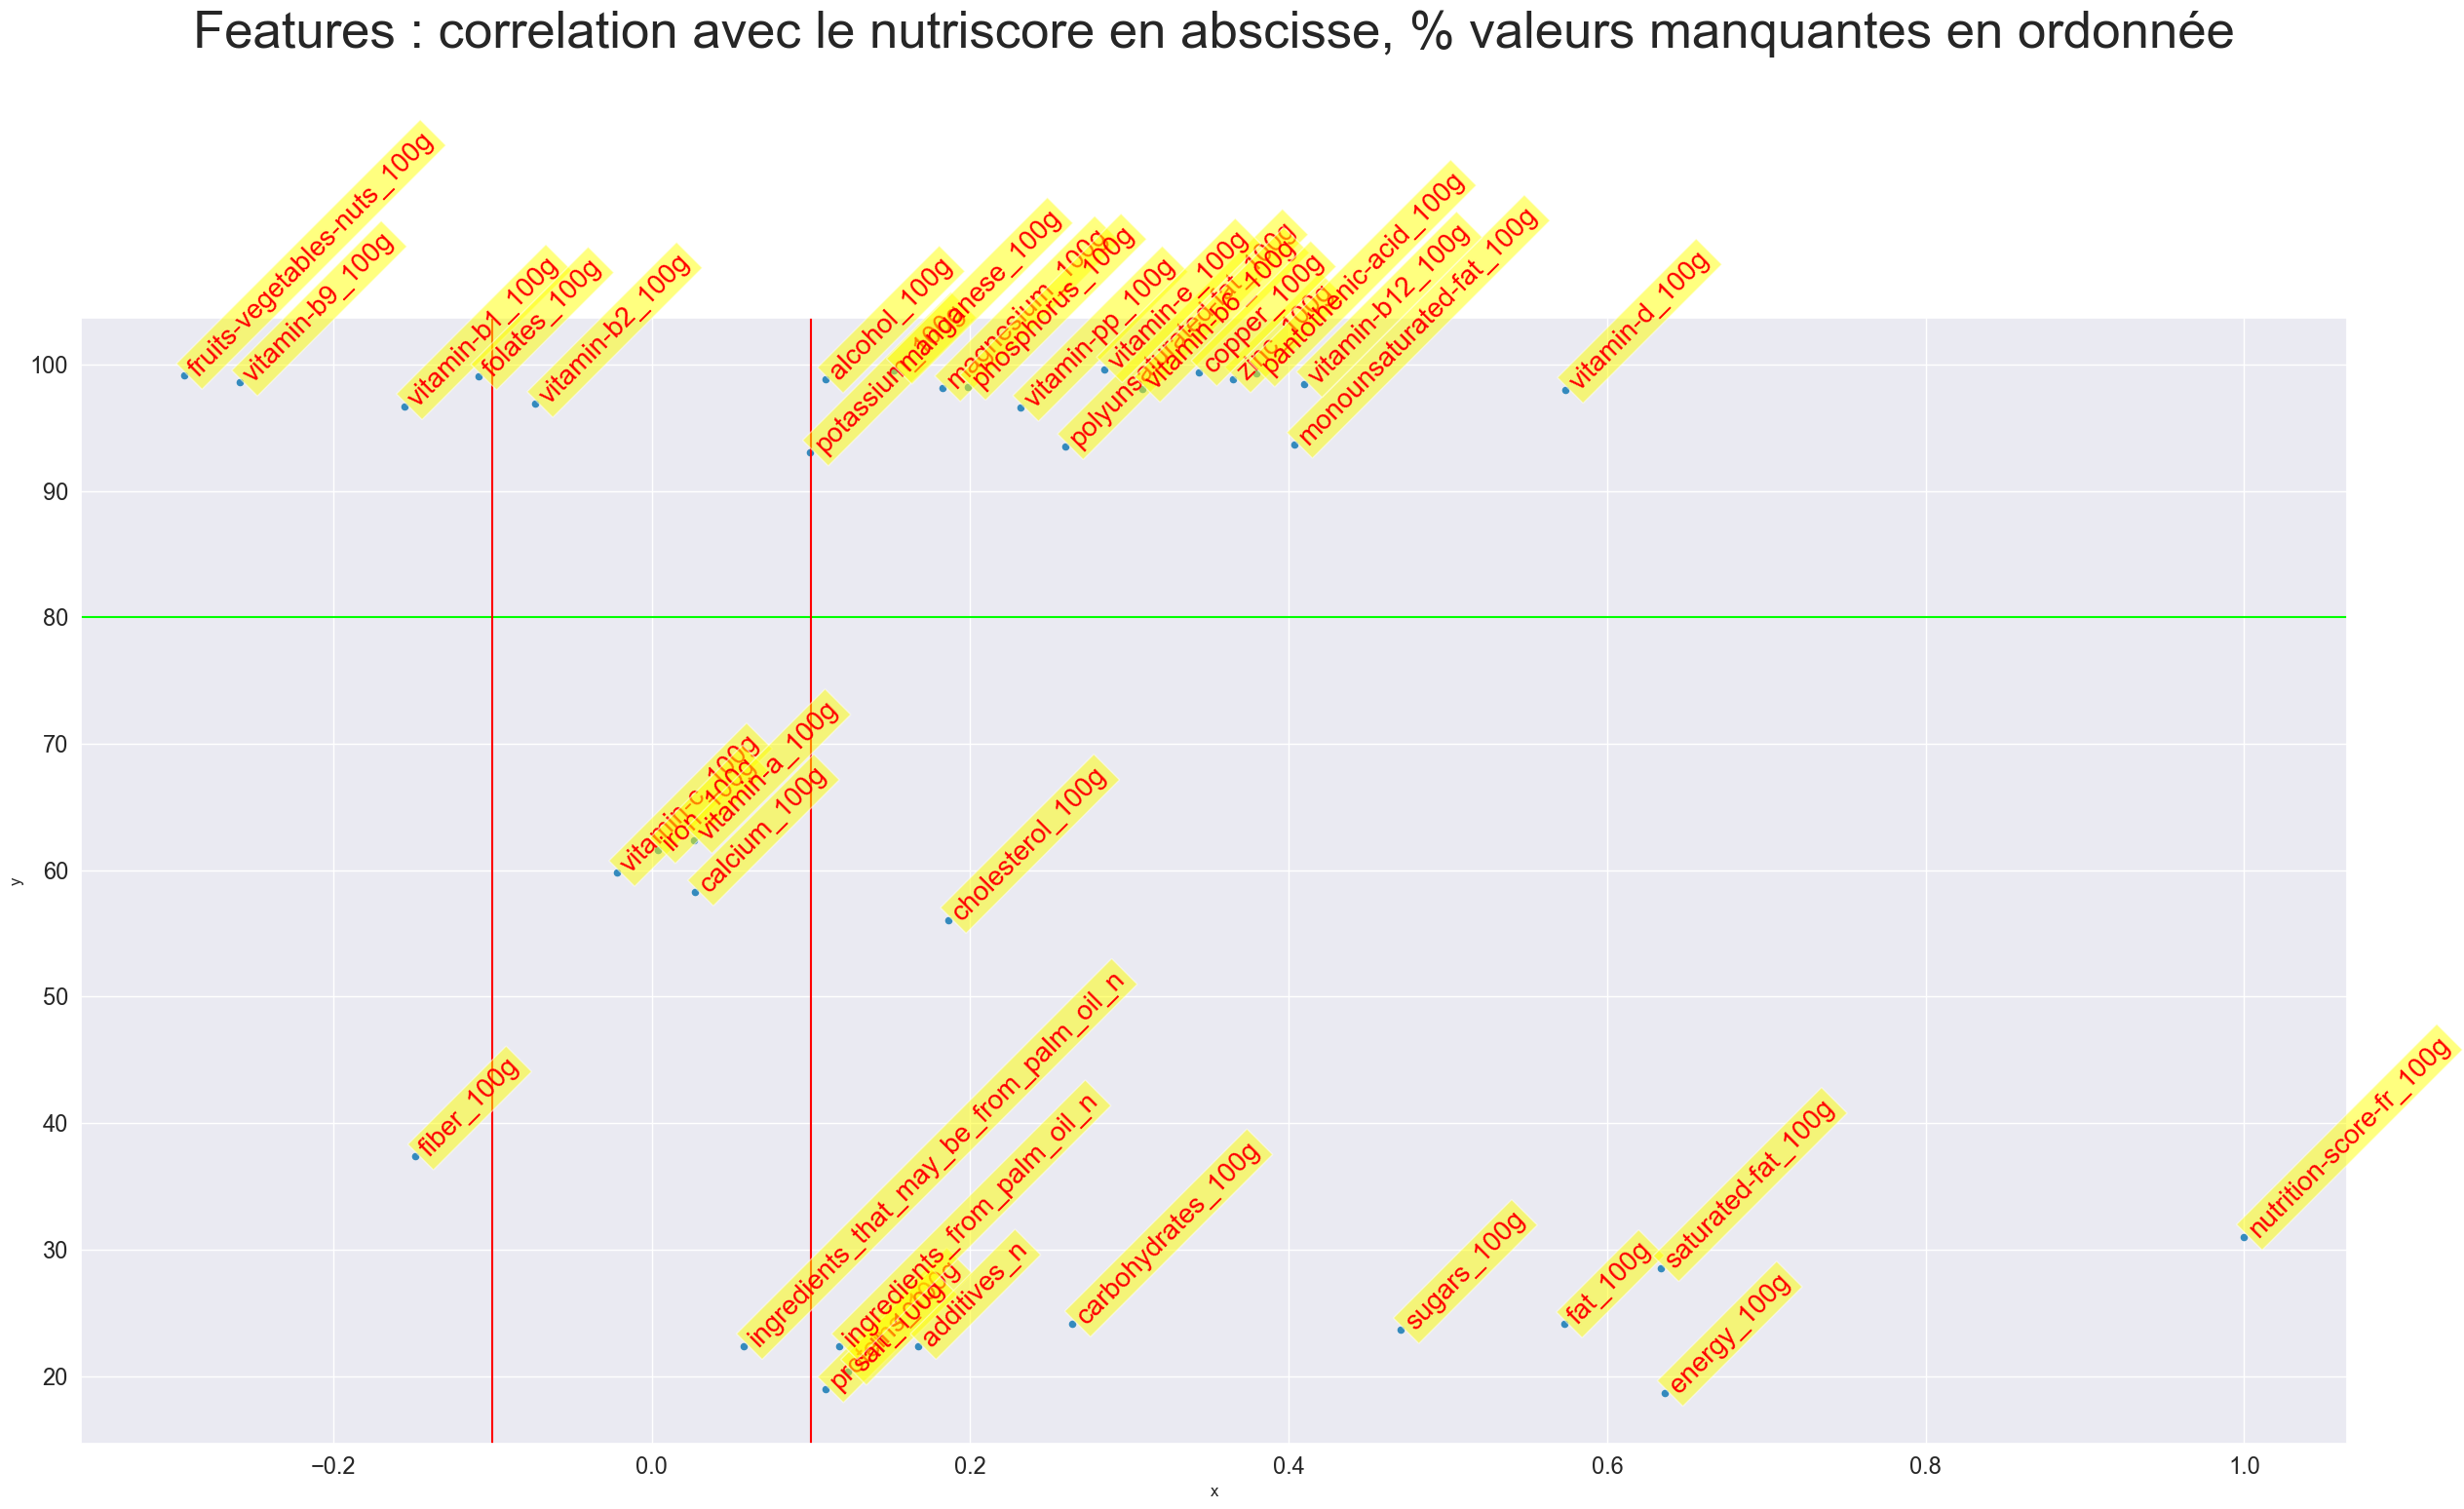

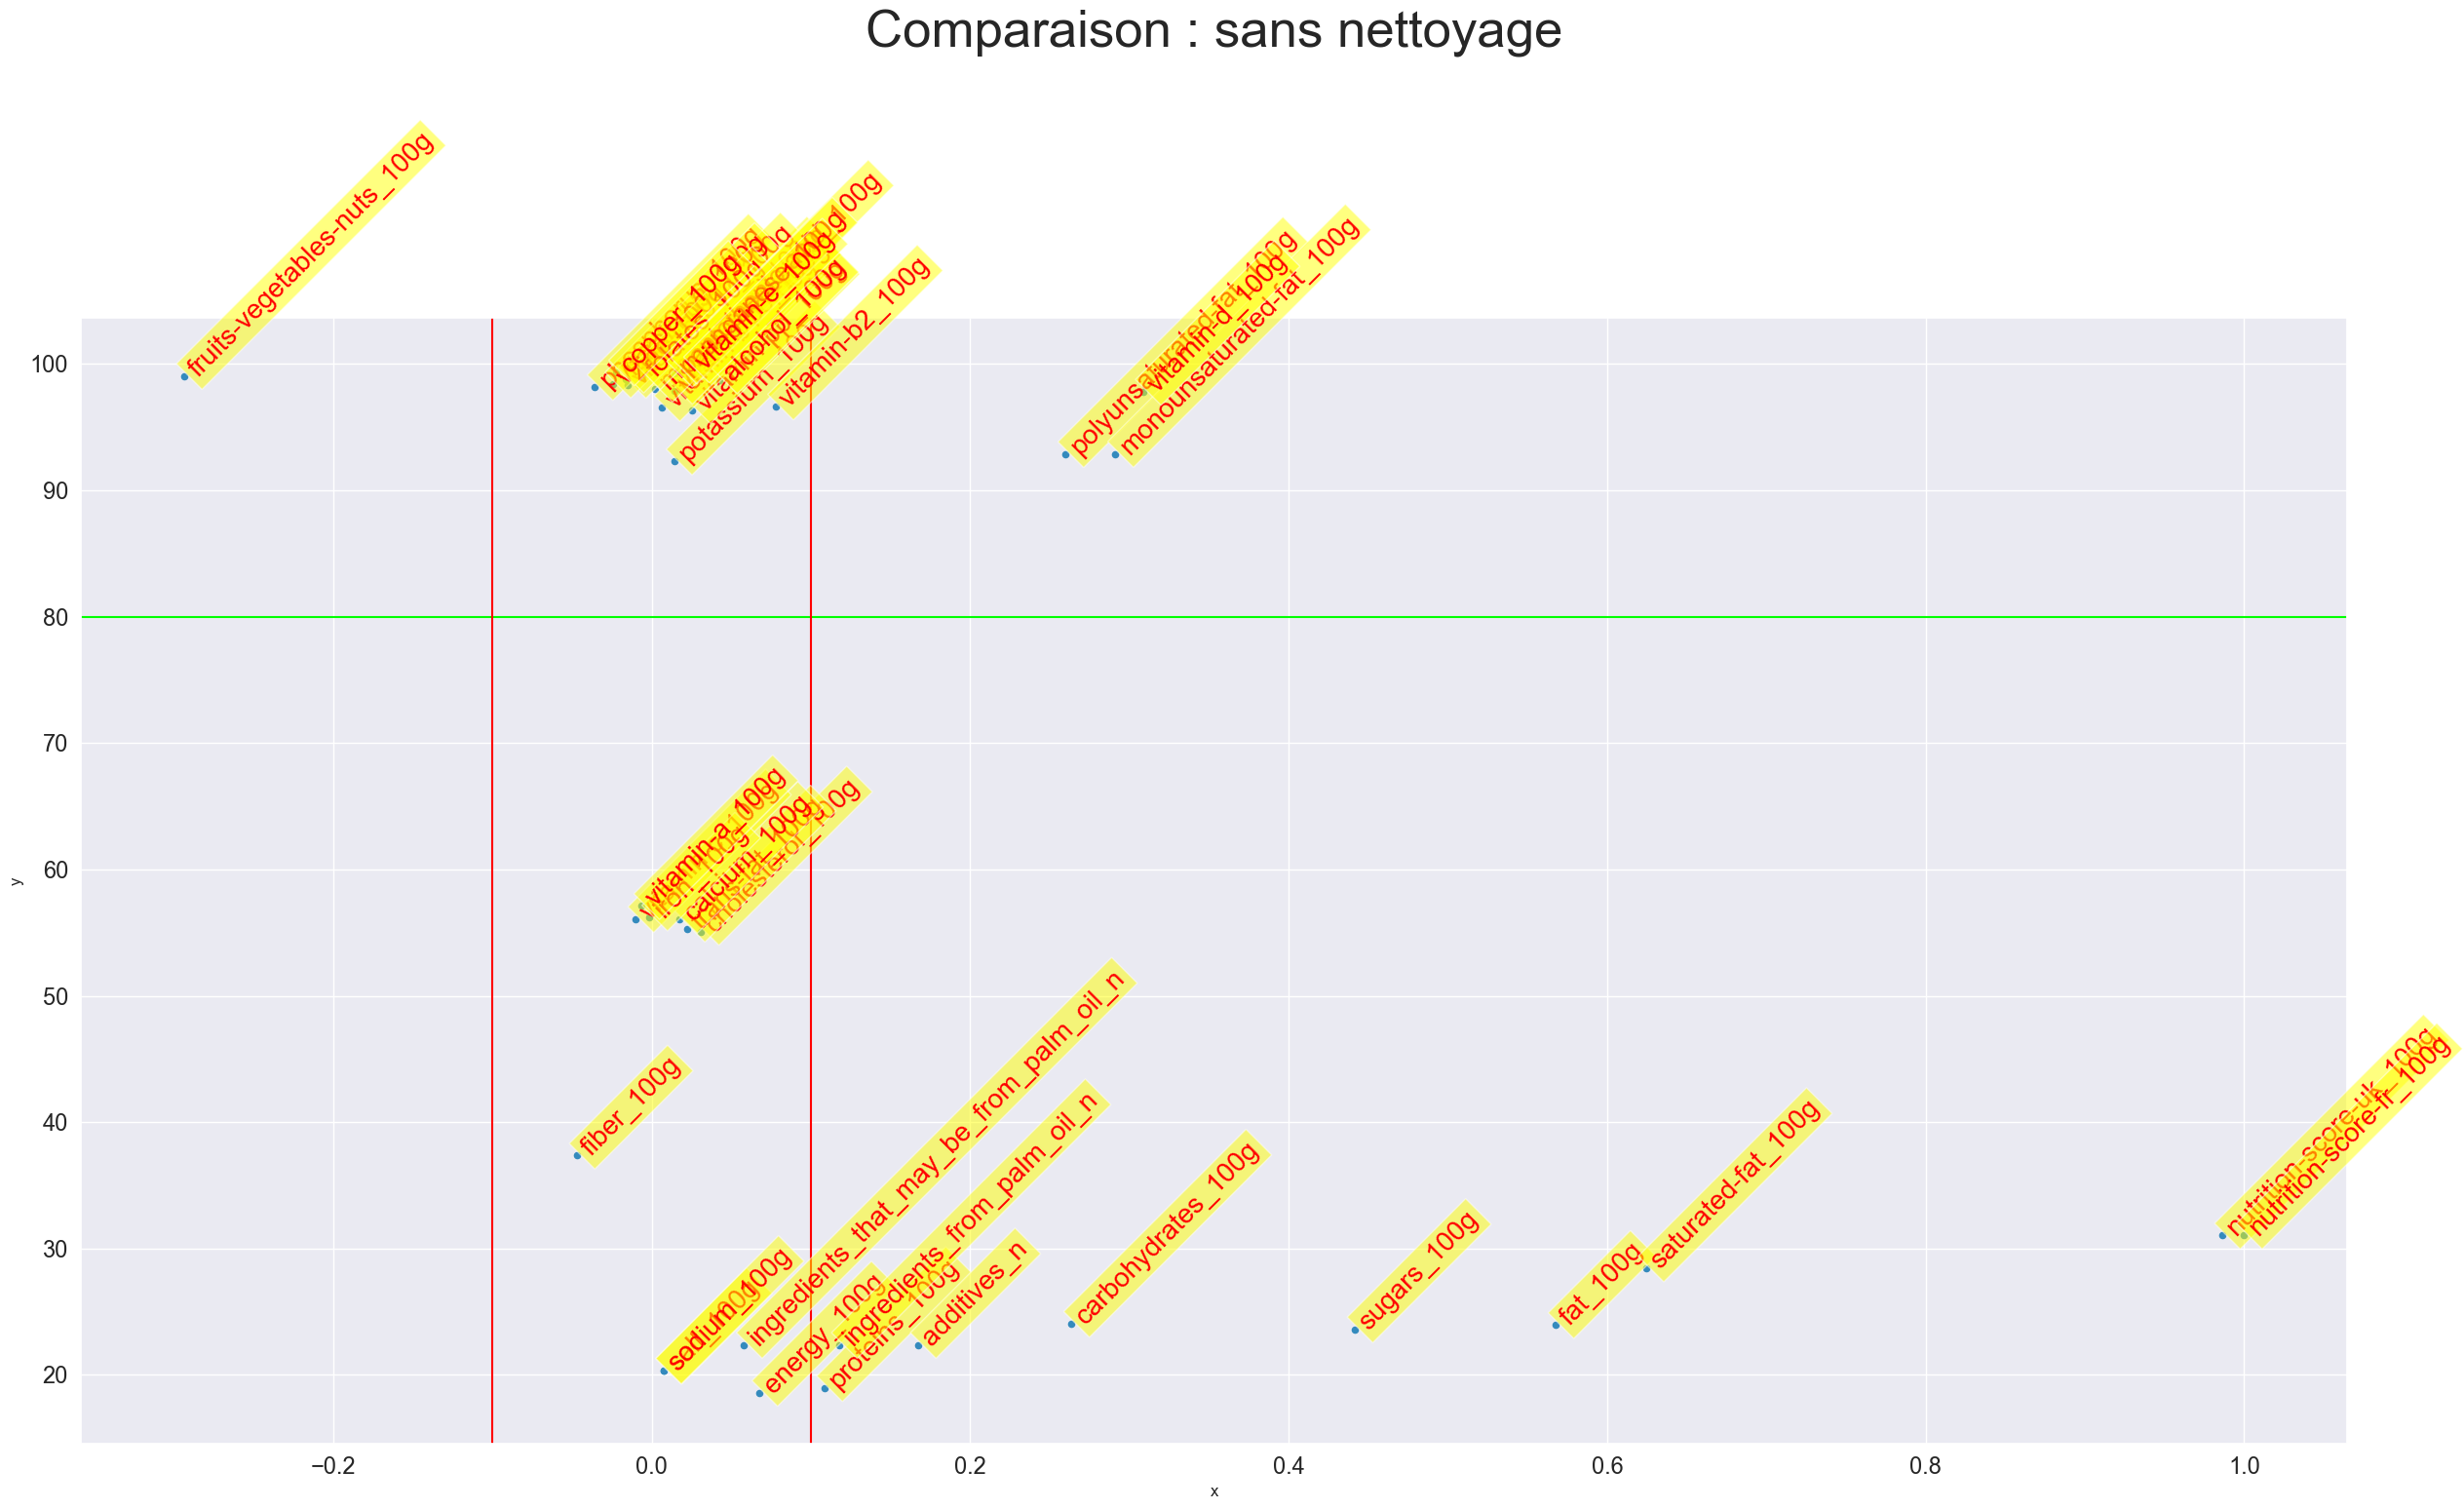

In [139]:
# graph avec correlation en abscisse, valeurs manquantes en ordonnée

plt.rcParams["figure.figsize"] = (30,15)

def selection_graph(df, periode_min, titre):
    """
    Visualise les features num de notre df, en fonction
    de leur corrélation avec le nutriscore (en abscisse) et
    de leur proportion de valeurs manquantes (en ordonnée)
    Arguments : df, int, str
    """
    names = df.columns
    # print(names)
    X = df.corr(min_periods=periode_min).loc['nutrition-score-fr_100g'].values
    # print(X)
    numeric_missing_values_df = get_missing_values(df)
    Y = numeric_missing_values_df.percent_missing.values
    # print(Y)
    features_df = pd.DataFrame({'feature': names,
                       'x': X,
                       'y' : Y})

    selection_df = features_df.loc[features_df['x'].notna(), :].copy()
    selection_df.reset_index(inplace=True, drop=True)

    selection_df.plot.scatter(x="x", y="y", fontsize=17)
    plt.axhline(y=80, color='#00ff00', linestyle='-')
    plt.axvline(x=0.1, color='#ff0000', linestyle='-')
    plt.axvline(x=-0.1, color='#ff0000', linestyle='-')

    for i in range(selection_df.shape[0]):
        plt.text(x=selection_df.x[i],y=selection_df.y[i],s=selection_df.feature[i], rotation=45,
                 fontdict=dict(color='red',size=20), bbox=dict(facecolor='yellow',alpha=0.5))
    plt.title(titre, fontsize=38, pad=200)
    plt.show()

selection_graph(numeric_df, 1000, "Features : correlation avec le nutriscore en abscisse, % valeurs manquantes en ordonnée")

# Pour comparaison, sans traitement des outliers
selection_graph(raw_numeric_df, 1000, "Comparaison : sans nettoyage")


### <a id="c4">[3.4 Features numériques choisies](#toc)</a>

In [140]:
# Vitamine C out, proteins in

# Il faut supprimer ttes les variables du haut (presque 100% de valeurs manquantes),
# on va donc poser environ 80% de valeurs manquantes (ligne verte).

missing_values_numeric_df = get_missing_values(numeric_df)
kept_features = missing_values_numeric_df.loc[missing_values_numeric_df['percent_missing'] < 80, 'column_name']

almost_clean_numeric_df = numeric_df[kept_features].copy()

print(almost_clean_numeric_df.shape)
display(almost_clean_numeric_df.head())

# Maintenant on drop les variables peu corrélées

display(almost_clean_numeric_df.corr(min_periods=1000).loc[['nutrition-score-fr_100g']])

kept_numeric_features = almost_clean_numeric_df.corr(min_periods=1000).columns[
    almost_clean_numeric_df.corr(min_periods=1000)['nutrition-score-fr_100g'].abs() >= 0.1]

nprint(len(kept_numeric_features))
print(kept_numeric_features)

clean_numeric_df = almost_clean_numeric_df[kept_numeric_features].copy()

# Comme on s'en doutait les dates ne sont pas pertinentes,
# nous allons cependant les garder pour la présentation
clean_numeric_df['created'] = even_shorter_df['created'].copy()

display(clean_numeric_df.head())

# De même pour les variables proche de 0 en abscisse (pas de corrélation détectée).

# Comparer avec matrice avant traitement
# Surpris par la faible corrélation de la variable "energy_100g", à peine supérieure à celle des dates
# Incohérence du nutriscore entre liquides et solides ?


(320719, 18)


energy_100g  proteins_100g  salt_100g  additives_n  \
0          NaN            NaN        NaN          NaN   
1       2243.0           3.57    0.00000          0.0   
2       1941.0          17.86    0.63500          0.0   
3       2540.0          17.86    1.22428          0.0   
4       1552.0           8.57        NaN          0.0   

   ingredients_that_may_be_from_palm_oil_n  ingredients_from_palm_oil_n  \
0                                      NaN                          NaN   
1                                      0.0                          0.0   
2                                      0.0                          0.0   
3                                      0.0                          0.0   
4                                      0.0                          0.0   

   sugars_100g  fat_100g  carbohydrates_100g  saturated-fat_100g  \
0          NaN       NaN                 NaN                 NaN   
1        14.29     28.57               64.29               28.57   
2        17.86     17.86               60.71                0.00   
3         3.57     57.14               17.86                5.36   
4          NaN      1.43               77.14                 NaN   

   nutrition-score-fr_100g  fiber_100g  vitamin-c_100g  trans-fat_100g  \
0                      NaN         NaN             NaN             NaN   
1                     14.0         3.6          0.0214             0.0   
2                      0.0         7.1          0.0000             0.0   
3                     12.0         7.1             NaN             NaN   
4                      NaN         5.7             NaN             NaN   

   iron_100g  calcium_100g  cholesterol_100g  vitamin-a_100g  
0        NaN           NaN               NaN             NaN  
1    0.00129         0.000             0.018             0.0  
2    0.00129         0.071             0.000             0.0  
3    0.00514         0.143               NaN             NaN  
4        NaN           NaN               NaN             NaN

energy_100g  proteins_100g  salt_100g  additives_n  \
nutrition-score-fr_100g     0.636264       0.109026   0.123502     0.167214   

                         ingredients_that_may_be_from_palm_oil_n  \
nutrition-score-fr_100g                                 0.058014   

                         ingredients_from_palm_oil_n  sugars_100g  fat_100g  \
nutrition-score-fr_100g                     0.117685     0.470468  0.572929   

                         carbohydrates_100g  saturated-fat_100g  \
nutrition-score-fr_100g            0.264135            0.633633   

                         nutrition-score-fr_100g  fiber_100g  vitamin-c_100g  \
nutrition-score-fr_100g                      1.0   -0.148376       -0.022055   

                         trans-fat_100g  iron_100g  calcium_100g  \
nutrition-score-fr_100g             NaN   0.003566      0.027404   

                         cholesterol_100g  vitamin-a_100g  
nutrition-score-fr_100g          0.186092        0.026507


 12
Index(['energy_100g', 'proteins_100g', 'salt_100g', 'additives_n',
       'ingredients_from_palm_oil_n', 'sugars_100g', 'fat_100g',
       'carbohydrates_100g', 'saturated-fat_100g', 'nutrition-score-fr_100g',
       'fiber_100g', 'cholesterol_100g'],
      dtype='object')


energy_100g  proteins_100g  salt_100g  additives_n  \
0          NaN            NaN        NaN          NaN   
1       2243.0           3.57    0.00000          0.0   
2       1941.0          17.86    0.63500          0.0   
3       2540.0          17.86    1.22428          0.0   
4       1552.0           8.57        NaN          0.0   

   ingredients_from_palm_oil_n  sugars_100g  fat_100g  carbohydrates_100g  \
0                          NaN          NaN       NaN                 NaN   
1                          0.0        14.29     28.57               64.29   
2                          0.0        17.86     17.86               60.71   
3                          0.0         3.57     57.14               17.86   
4                          0.0          NaN      1.43               77.14   

   saturated-fat_100g  nutrition-score-fr_100g  fiber_100g  cholesterol_100g  \
0                 NaN                      NaN         NaN               NaN   
1               28.57                     14.0         3.6             0.018   
2                0.00                      0.0         7.1             0.000   
3                5.36                     12.0         7.1               NaN   
4                 NaN                      NaN         5.7               NaN   

                    created  
0 2016-09-17 09:17:46+00:00  
1 2017-03-09 14:32:37+00:00  
2 2017-03-09 14:32:37+00:00  
3 2017-03-09 10:35:31+00:00  
4 2017-03-09 10:34:13+00:00

In [141]:
display_missing_values(clean_numeric_df)


column_name  missing  present  \
created                                          created        0   320719   
energy_100g                                  energy_100g    59903   260816   
proteins_100g                              proteins_100g    60825   259894   
salt_100g                                      salt_100g    65261   255458   
ingredients_from_palm_oil_n  ingredients_from_palm_oil_n    71780   248939   
additives_n                                  additives_n    71780   248939   
sugars_100g                                  sugars_100g    75809   244910   
fat_100g                                        fat_100g    77289   243430   
carbohydrates_100g                    carbohydrates_100g    77520   243199   
saturated-fat_100g                    saturated-fat_100g    91527   229192   
nutrition-score-fr_100g          nutrition-score-fr_100g    99509   221210   
fiber_100g                                    fiber_100g   119847   200872   
cholesterol_100g                        cholesterol_100g   197570   123149   

                             percent_missing                 type  
created                                 0.00  datetime64[ns, UTC]  
energy_100g                            18.68              float64  
proteins_100g                          18.97              float64  
salt_100g                              20.35              float64  
ingredients_from_palm_oil_n            22.38              float64  
additives_n                            22.38              float64  
sugars_100g                            23.64              float64  
fat_100g                               24.10              float64  
carbohydrates_100g                     24.17              float64  
saturated-fat_100g                     28.54              float64  
nutrition-score-fr_100g                31.03              float64  
fiber_100g                             37.37              float64  
cholesterol_100g                       61.60              float64

### <a id="c5">[3.5 Features catégoriques](#toc)</a>

In [142]:
# Maintenant, les variables categoriques

missing_values_categoric_df = get_missing_values(even_shorter_df)

categoric_cols = missing_values_categoric_df.loc[missing_values_categoric_df.type == 'object', 'column_name'].tolist()
categoric_df = even_shorter_df[categoric_cols].copy()

display(categoric_df.head())


creator           code  \
0  openfoodfacts-contributors  0000000003087   
1             usda-ndb-import  0000000004530   
2             usda-ndb-import  0000000004559   
3             usda-ndb-import  0000000016087   
4             usda-ndb-import  0000000016094   

                                           states_fr  \
0  A compléter,Informations nutritionnelles à com...   
1  A compléter,Informations nutritionnelles compl...   
2  A compléter,Informations nutritionnelles compl...   
3  A compléter,Informations nutritionnelles compl...   
4  A compléter,Informations nutritionnelles compl...   

                                                 url  \
0  http://world-fr.openfoodfacts.org/produit/0000...   
1  http://world-fr.openfoodfacts.org/produit/0000...   
2  http://world-fr.openfoodfacts.org/produit/0000...   
3  http://world-fr.openfoodfacts.org/produit/0000...   
4  http://world-fr.openfoodfacts.org/produit/0000...   

                                              states  \
0  en:to-be-completed, en:nutrition-facts-to-be-c...   
1  en:to-be-completed, en:nutrition-facts-complet...   
2  en:to-be-completed, en:nutrition-facts-complet...   
3  en:to-be-completed, en:nutrition-facts-complet...   
4  en:to-be-completed, en:nutrition-facts-complet...   

                                         states_tags countries_fr  \
0  en:to-be-completed,en:nutrition-facts-to-be-co...       France   
1  en:to-be-completed,en:nutrition-facts-complete...   États-Unis   
2  en:to-be-completed,en:nutrition-facts-complete...   États-Unis   
3  en:to-be-completed,en:nutrition-facts-complete...   États-Unis   
4  en:to-be-completed,en:nutrition-facts-complete...   États-Unis   

     countries_tags countries                    product_name  \
0         en:france     en:FR              Farine de blé noir   
1  en:united-states        US  Banana Chips Sweetened (Whole)   
2  en:united-states        US                         Peanuts   
3  en:united-states        US          Organic Salted Nut Mix   
4  en:united-states        US                 Organic Polenta   

            brands      brands_tags  \
0  Ferme t'y R'nao  ferme-t-y-r-nao   
1              NaN              NaN   
2   Torn & Glasser     torn-glasser   
3        Grizzlies        grizzlies   
4   Bob's Red Mill   bob-s-red-mill   

                                    ingredients_text  \
0                                                NaN   
1  Bananas, vegetable oil (coconut oil, corn oil ...   
2  Peanuts, wheat flour, sugar, rice flour, tapio...   
3  Organic hazelnuts, organic cashews, organic wa...   
4                                    Organic polenta   

                                           additives nutrition_grade_fr  \
0                                                NaN                NaN   
1   [ bananas -> en:bananas  ]  [ vegetable-oil -...                  d   
2   [ peanuts -> en:peanuts  ]  [ wheat-flour -> ...                  b   
3   [ organic-hazelnuts -> en:organic-hazelnuts  ...                  d   
4   [ organic-polenta -> en:organic-polenta  ]  [...                NaN   

      serving_size additives_tags additives_fr quantity pnns_groups_2  \
0              NaN            NaN          NaN      1kg           NaN   
1     28 g (1 ONZ)            NaN          NaN      NaN           NaN   
2  28 g (0.25 cup)            NaN          NaN      NaN           NaN   
3  28 g (0.25 cup)            NaN          NaN      NaN           NaN   
4  35 g (0.25 cup)            NaN          NaN      NaN           NaN   

  pnns_groups_1 categories main_category_fr categories_tags categories_fr  \
0           NaN        NaN              NaN             NaN           NaN   
1           NaN        NaN              NaN             NaN           NaN   
2           NaN        NaN              NaN             NaN           NaN   
3           NaN        NaN              NaN             NaN           NaN   
4           NaN        NaN              NaN             NaN          

In [143]:
display_missing_values(categoric_df)


column_name  \
creator                                                                        creator   
code                                                                              code   
states_fr                                                                    states_fr   
url                                                                                url   
states                                                                          states   
states_tags                                                                states_tags   
countries_fr                                                              countries_fr   
countries_tags                                                          countries_tags   
countries                                                                    countries   
product_name                                                              product_name   
brands                                                                          brands   
brands_tags                                                                brands_tags   
ingredients_text                                                      ingredients_text   
additives                                                                    additives   
nutrition_grade_fr                                                  nutrition_grade_fr   
serving_size                                                              serving_size   
additives_tags                                                          additives_tags   
additives_fr                                                              additives_fr   
quantity                                                                      quantity   
pnns_groups_2                                                            pnns_groups_2   
pnns_groups_1                                                            pnns_groups_1   
categories                                                                  categories   
main_category_fr                                                      main_category_fr   
categories_tags                                                        categories_tags   
categories_fr                                                            categories_fr   
main_category                                                            main_category   
packaging_tags                                                          packaging_tags   
packaging                                                                    packaging   
image_small_url                                                        image_small_url   
image_url                                                                    image_url   
purchase_places                                                        purchase_places   
generic_name                                                              generic_name   
stores                                                                          stores   
labels_fr                                                                    labels_fr   
labels_tags                                                                labels_tags   
labels                                                                          labels   
manufacturing_places                                              manufacturing_places   
manufacturing_places_tags                                    manufacturing_places_tags   
emb_codes                                                                    emb_codes   
emb_codes_tags                                                          emb_codes_tags   
allergens                                                                    allergens   
traces                                                                          traces   
traces_fr                                                                    traces_fr   
traces_tags                                                                traces_tags   
origins                  

In [144]:
categoric_df.nunique()


creator                                         3533
code                                          320719
states_fr                                       1021
url                                           320719
states                                          1021
states_tags                                     1021
countries_fr                                     717
countries_tags                                   719
countries                                       1428
product_name                                  221321
brands                                         58783
brands_tags                                    50252
ingredients_text                              205515
additives                                     196069
nutrition_grade_fr                                 5
serving_size                                   25416
additives_tags                                 41537
additives_fr                                   41537
quantity                                      

### <a id="c6">[3.6 Features auto : type states](#toc)</a>

In [145]:
checkText(categoric_df['states'])

checkText(categoric_df['states_tags'])

checkText(categoric_df['states_fr'])

# Rien d'intéressant ici


28
Counter({'en:product-name-completed,': 302952, 'en:brands-completed,': 292326, 'en:expiration-date-to-be-completed,': 278616, 'en:nutrition-facts-completed,': 274697, 'en:to-be-completed,': 261598, 'en:ingredients-completed,': 248731, 'en:characteristics-to-be-completed,': 248254, 'en:packaging-to-be-completed,': 241779, 'en:categories-to-be-completed,': 236353, 'en:packaging-code-to-be-completed,': 232208, 'en:quantity-to-be-completed,': 215939, 'en:photos-to-be-uploaded': 184160, 'en:photos-uploaded': 136559, 'en:quantity-completed,': 104770, 'en:categories-completed,': 84356, 'en:packaging-completed,': 78931, 'en:characteristics-completed,': 72465, 'en:ingredients-to-be-completed,': 71988, 'en:photos-to-be-validated,': 69193, 'en:photos-validated,': 67366, 'en:to-be-checked,': 59121, 'en:complete,': 59121, 'en:nutrition-facts-to-be-completed,': 46022, 'en:expiration-date-completed,': 42103, 'en:brands-to-be-completed,': 28382, 'en:product-name-to-be-completed,': 17756, 'en:packag

### <a id="c7">[3.7 Features auto : type countries](#toc)</a>

In [146]:
checkText(categoric_df['countries_fr'])

checkText(categoric_df['countries'])

checkText(categoric_df['countries_tags'])

# Les 3 variables sont très liées (exactement le même nombre de valeurs manquante),
# ce qui indique qu'elles sont probablement générées ensemble, ou à partir de l'une d'entre elles.

# On peut conserver countries_fr,qui a le moins de nunique()

# pour s'amuser pendant la présentation (on veut tous savoir où on mange le mieux :
# Danemark ou Portugal ? Guadeloupe ou Magyarország ? (qui est apparement la Hongrie,
# pour ceux qui l'ignoraient, comme moi y a 10 secondes. On apprend des trucs en data science.))
# Café ? Café.


752
Counter({'états-unis': 172999, 'france': 94392, 'suisse': 14953, 'allemagne': 7870, 'espagne': 5009, 'royaume-uni': 4823, 'belgique': 2595, 'australie': 2056, 'russie': 1315, 'france,suisse': 1224, 'italie': 1213, 'canada': 888, 'portugal': 674, 'pays-bas': 558, 'france,royaume-uni': 514, 'belgique,france': 512, 'autriche': 379, 'brésil': 336, 'république': 308, 'tchèque': 275, 'danemark': 253, 'hongrie': 249, 'france,allemagne': 240, 'thaïlande': 240, 'france,états-unis': 221, 'allemagne,suisse': 218, 'réunion': 214, 'roumanie': 209, 'irlande': 187, 'japon': 178, 'chine': 177, 'luxembourg': 165, 'maroc': 154, 'la': 150, 'taiwan': 148, 'france,espagne': 146, 'tunisie': 139, 'hong': 138, 'kong': 137, 'algérie': 137, 'pologne': 135, 'suède': 107, 'guadeloupe': 106, 'chili': 101, 'france,guadeloupe': 94, 'belgique,france,suisse': 93, 'nouvelle-calédonie': 90, 'norvège': 89, 'nouvelle-zélande': 87, 'serbie': 83, 'martinique': 80, 'saoudite': 79, 'du': 79, 'arabie': 78, 'arabes': 77, 'u

### <a id="c8">[3.8 Additifs](#toc)</a>

In [147]:
# ingredients_text, approche bag of words ?

# Ces 5 variables ont des sommes de valeurs manquantes extremement proches,
# entre 71 810 pour ingredients_text et 71 867 pour additives (soit 57 de +).
# Les 2 from_palm_oil et additives_n ont ts les 3 exactement le mm nb de vm : 71 833.

# Mon hypothèse est que ces valeurs nous indiquent précisément le nombre d'usagers
# ayant utilisé l'outil photo
# Si l'hypothèse est correcte, cela signifierait que moins d'un quart des usagers l'a utilisé !

print(categoric_df['additives'].nunique())

checkText(categoric_df.loc[:10000, 'additives'])
# Resultat du découpage de ingredients_text ?


196069
43687
Counter({'->': 280645, '[': 255823, ']': 255823, '--': 24847, 'exists': 24822, 'ok': 24755, 'salt': 7370, 'en:salt': 7369, 'sugar': 5791, 'en:sugar': 5790, 'oil': 5008, 'en:oil': 5008, 'water': 4925, 'en:water': 4925, 'flour': 4789, 'en:flour': 4789, 'milk': 3542, 'en:milk': 3541, 'syrup': 2972, 'en:syrup': 2972, 'flavor': 2864, 'en:flavor': 2864, 'wheat-flour': 2585, 'en:wheat-flour': 2585, 'corn-syrup': 2498, 'en:corn-syrup': 2498, 'starch': 2209, 'en:starch': 2209, 'powder': 2145, 'en:powder': 2145, 'en:e330': 2099, 'citric-acid': 2077, 'en:e101': 1866, 'en:fd-c': 1830, 'acid': 1759, 'en:acid': 1759, 'mononitrate': 1651, 'en:mononitrate': 1651, 'riboflavin': 1623, 'folic-acid': 1617, 'en:folic-acid': 1617, 'en:e375': 1556, 'niacin': 1551, 'flavors': 1520, 'en:flavors': 1520, 'iron': 1501, 'en:iron': 1500, 'en:e322': 1455, 'lecithin': 1436, 'soybean-oil': 1387, 'en:soybean-oil': 1387, 'color': 1341, 'natural-flavor': 1291, 'en:natural-flavor': 1291, 'vinegar': 1275, 'en:

In [148]:
print(categoric_df['additives_fr'].nunique())

checkText(categoric_df.loc[:10000, 'additives_fr'])

# Du coup je ne vois tjs pas le rapport avec la feature numérique 'additives_n'


41537
3251
Counter({'-': 24355, 'de': 8853, 'acide': 5089, 'gomme': 1546, 'e375': 1303, 'nicotinique,e101': 1302, 'sodium': 1197, 'phosphate': 879, 'e330': 853, 'citrique': 703, 'chlorure': 652, 'e322': 617, 'lécithines': 607, 'caramel': 591, 'riboflavine': 574, 'rouge': 571, 'allura': 569, 'calcium': 550, 'benzoate': 502, 'sorbate': 492, 'polyoxyéthylène': 471, 'citrates': 458, 'bleu': 439, 'brillant': 438, 'farine': 420, 'graines': 420, 'monooléate': 372, 'e150a': 370, 'hydrogénocarbonate': 365, 'jaune': 357, 'orangé': 357, 'et': 305, 'e509': 303, 'sels': 278, 'fcf': 263, 'e412': 260, 'sulfate': 258, 'glutamate': 256, 'métalliques': 242, 'carbonate': 239, 'ascorbique': 227, 'acésulfame': 211, 'dioxyde': 194, 'nitrite': 190, 'oxyde': 188, 'e300': 188, 'e428': 186, 'ac': 184, 'e415': 182, 'monophosphate': 180, "d'aluminium": 178, 'tartrazine': 173, 'e440': 170, 'xanthane': 169, 'tartrazine,e110': 166, 'cire': 162, 'erythorbate': 156, 'lactate': 155, 'éthylène': 155, 'diamine': 155, 'té

### <a id="c9">[3.9 Autres features catégoriques](#toc)</a>

In [149]:
# product_name, tjs utile

# brands : utile si l'on voulait faire une étude sur 1 marque.
# Ce n'est pas notre problématique ici.

# serving_size et quantity pas utiles (nos variables numériques sont toutes exprimées pour 100g)

# nutrigrade on garde !

# pnns_groups_1 et 2 on garde !

checkText(categoric_df['categories_fr'])

# Intéressant mais on privilégiera pnns group car moins de valeurs manquantes,
# et beaucoup moins de nunique

# Features restantes : trop de valeurs manquantes.


19327
Counter({'de': 106832, 'et': 75929, 'à': 71639, 'base': 49015, 'aliments': 27114, 'boissons': 26925, "d'origine": 23807, 'végétaux,aliments': 21704, 'produits': 14620, 'en': 13121, 'snacks': 12570, 'fruits': 10727, 'au': 10198, 'pommes': 9406, 'végétale,aliments': 6258, 'tartiner': 6122, 'fruits,jus': 5997, 'végétale,céréales': 5826, 'terre,céréales': 5698, 'boissons,boissons': 5682, 'préparés': 5680, 'plantes': 5594, 'aux': 5586, 'sucrées': 5075, 'non': 5036, 'la': 4845, 'sucrés,biscuits': 4676, 'pour': 3965, 'végétaux,boissons,boissons': 3822, 'préparés,plats': 3544, 'végétaux,boissons': 3261, 'laitiers,fromages,fromages': 3242, 'sans': 2906, 'plats': 2436, 'dérivés,pâtes': 2367, 'nectars': 2318, 'nectars,jus': 2303, 'alcool': 2299, 'pâte': 2202, 'dérivés,légumes': 2069, 'dérivés,aliments': 1919, 'chocolat': 1916, 'sucrés,chocolats,chocolats': 1902, 'végétale,frais,aliments': 1830, 'grasses': 1700, 'conserve': 1668, 'viande': 1668, 'frais,légumes': 1664, 'frais,produits': 1654,

In [150]:
checkText(categoric_df['ingredients_from_palm_oil_tags'])

# Ici non plus cela ne nous aide pas à savoir ce que contient ingredients_from_palm_oil_n


14
Counter({'huile-de-palme': 4586, 'e304-palmitate-d-ascorbyle': 158, 'huile-de-palme,e304-palmitate-d-ascorbyle': 35, 'oleine-de-palme': 19, 'mono-et-diglycerides-d-acides-gras-de-palme': 12, 'e304-palmitate-d-ascorbyle,huile-de-palme': 6, 'huile-de-palme,oleine-de-palme': 6, 'huile-de-palme,stearine-de-palme': 5, 'huile-de-palme,mono-et-diglycerides-d-acides-gras-de-palme': 2, 'oleine-de-palme,e304-palmitate-d-ascorbyle': 2, 'mono-et-diglycerides-d-acides-gras-de-palme,huile-de-palme': 1, 'oleine-de-palme,huile-de-palme': 1, 'stearine-de-palme': 1, 'stearine-de-palme,huile-de-palme': 1}) 



### <a id="c10">[3.10 Features choisies : numériques et catégoriques](#toc)</a>

In [151]:
# Nous allons donc utiliser surtout nutrition_grade_fr et pnns_groups_1

# countries_fr peut être amusant à traiter, et intéressant pour la présentation (regroupements ?)
# même si pas très pertinent.
# même remarque pour les dates (évolution par années ?)

# ingredients_text, additives pour approche bag of words ? (plus tard)

final_categoric_df = categoric_df[['product_name', 'nutrition_grade_fr', 'pnns_groups_1', 'countries_fr']].copy()
display_missing_values(final_categoric_df)

final_numeric_df = clean_numeric_df.drop(['additives_n', 'ingredients_from_palm_oil_n'], axis=1).copy() 
display_missing_values(final_numeric_df)

print(final_categoric_df.shape)
print(final_numeric_df.shape)


column_name  missing  present  percent_missing  \
countries_fr              countries_fr      252   320467             0.08   
product_name              product_name    17756   302963             5.54   
nutrition_grade_fr  nutrition_grade_fr    99509   221210            31.03   
pnns_groups_1            pnns_groups_1   229208    91511            71.47   

                      type  
countries_fr        object  
product_name        object  
nutrition_grade_fr  object  
pnns_groups_1       object

column_name  missing  present  \
created                                  created        0   320719   
energy_100g                          energy_100g    59903   260816   
proteins_100g                      proteins_100g    60825   259894   
salt_100g                              salt_100g    65261   255458   
sugars_100g                          sugars_100g    75809   244910   
fat_100g                                fat_100g    77289   243430   
carbohydrates_100g            carbohydrates_100g    77520   243199   
saturated-fat_100g            saturated-fat_100g    91527   229192   
nutrition-score-fr_100g  nutrition-score-fr_100g    99509   221210   
fiber_100g                            fiber_100g   119847   200872   
cholesterol_100g                cholesterol_100g   197570   123149   

                         percent_missing                 type  
created                             0.00  datetime64[ns, UTC]  
energy_100g                        18.68              float64  
proteins_100g                      18.97              float64  
salt_100g                          20.35              float64  
sugars_100g                        23.64              float64  
fat_100g                           24.10              float64  
carbohydrates_100g                 24.17              float64  
saturated-fat_100g                 28.54              float64  
nutrition-score-fr_100g            31.03              float64  
fiber_100g                         37.37              float64  
cholesterol_100g                   61.60              float64

(320719, 4)
(320719, 11)


### <a id="c11">[3.11 Jointure](#toc)</a>

In [152]:
final_df = final_categoric_df.join(final_numeric_df).copy() # left join by default

display(final_categoric_df)
display(final_numeric_df)
display(final_df)


product_name nutrition_grade_fr  \
0                                      Farine de blé noir                NaN   
1                          Banana Chips Sweetened (Whole)                  d   
2                                                 Peanuts                  b   
3                                  Organic Salted Nut Mix                  d   
4                                         Organic Polenta                NaN   
...                                                   ...                ...   
320767                                  Tomato & ricotta                 NaN   
320768  Mint Melange Tea A Blend Of Peppermint, Lemon ...                  b   
320769                                            乐吧泡菜味薯片                NaN   
320770                           Tomates aux Vermicelles                 NaN   
320771                    Sugar Free Drink Mix, Peach Tea                NaN   

       pnns_groups_1 countries_fr  
0                NaN       France  
1                NaN   États-Unis  
2                NaN   États-Unis  
3                NaN   États-Unis  
4                NaN   États-Unis  
...              ...          ...  
320767           NaN     Roumanie  
320768           NaN   États-Unis  
320769  Salty snacks        Chine  
320770           NaN       France  
320771           NaN   États-Unis  

[320719 rows x 4 columns]

energy_100g  proteins_100g  salt_100g  sugars_100g  fat_100g  \
0               NaN            NaN        NaN          NaN       NaN   
1            2243.0           3.57    0.00000        14.29     28.57   
2            1941.0          17.86    0.63500        17.86     17.86   
3            2540.0          17.86    1.22428         3.57     57.14   
4            1552.0           8.57        NaN          NaN      1.43   
...             ...            ...        ...          ...       ...   
320767          NaN            NaN        NaN          NaN       NaN   
320768          0.0           0.00    0.00000         0.00      0.00   
320769          NaN            NaN        NaN          NaN       NaN   
320770          NaN            NaN        NaN          NaN       NaN   
320771       2092.0           0.00    0.00000         0.00      0.00   

        carbohydrates_100g  saturated-fat_100g  nutrition-score-fr_100g  \
0                      NaN                 NaN                      NaN   
1                    64.29               28.57                     14.0   
2                    60.71                0.00                      0.0   
3                    17.86                5.36                     12.0   
4                    77.14                 NaN                      NaN   
...                    ...                 ...                      ...   
320767                 NaN                 NaN                      NaN   
320768                0.00                0.00                      0.0   
320769                 NaN                 NaN                      NaN   
320770                 NaN                 NaN                      NaN   
320771                0.00                 NaN                      NaN   

        fiber_100g  cholesterol_100g                   created  
0              NaN               NaN 2016-09-17 09:17:46+00:00  
1              3.6             0.018 2017-03-09 14:32:37+00:00  
2              7.1             0.000 2017-03-09 14:32:37+00:00  
3              7.1               NaN 2017-03-09 10:35:31+00:00  
4              5.7               NaN 2017-03-09 10:34:13+00:00  
...            ...               ...                       ...  
320767         NaN               NaN 2017-03-27 16:14:59+00:00  
320768         0.0             0.000 2017-03-09 11:31:16+00:00  
320769         NaN               NaN 2015-01-24 11:36:17+00:00  
320770         NaN               NaN 2017-04-16 10:54:49+00:00  
320771         NaN               NaN 2017-03-09 15:18:29+00:00  

[320719 rows x 11 columns]

product_name nutrition_grade_fr  \
0                                      Farine de blé noir                NaN   
1                          Banana Chips Sweetened (Whole)                  d   
2                                                 Peanuts                  b   
3                                  Organic Salted Nut Mix                  d   
4                                         Organic Polenta                NaN   
...                                                   ...                ...   
320767                                  Tomato & ricotta                 NaN   
320768  Mint Melange Tea A Blend Of Peppermint, Lemon ...                  b   
320769                                            乐吧泡菜味薯片                NaN   
320770                           Tomates aux Vermicelles                 NaN   
320771                    Sugar Free Drink Mix, Peach Tea                NaN   

       pnns_groups_1 countries_fr  energy_100g  proteins_100g  salt_100g  \
0                NaN       France          NaN            NaN        NaN   
1                NaN   États-Unis       2243.0           3.57    0.00000   
2                NaN   États-Unis       1941.0          17.86    0.63500   
3                NaN   États-Unis       2540.0          17.86    1.22428   
4                NaN   États-Unis       1552.0           8.57        NaN   
...              ...          ...          ...            ...        ...   
320767           NaN     Roumanie          NaN            NaN        NaN   
320768           NaN   États-Unis          0.0           0.00    0.00000   
320769  Salty snacks        Chine          NaN            NaN        NaN   
320770           NaN       France          NaN            NaN        NaN   
320771           NaN   États-Unis       2092.0           0.00    0.00000   

        sugars_100g  fat_100g  carbohydrates_100g  saturated-fat_100g  \
0               NaN       NaN                 NaN                 NaN   
1             14.29     28.57               64.29               28.57   
2             17.86     17.86               60.71                0.00   
3              3.57     57.14               17.86                5.36   
4               NaN      1.43               77.14                 NaN   
...             ...       ...                 ...                 ...   
320767          NaN       NaN                 NaN                 NaN   
320768         0.00      0.00                0.00                0.00   
320769          NaN       NaN                 NaN                 NaN   
320770          NaN       NaN                 NaN                 NaN   
320771         0.00      0.00                0.00                 NaN   

        nutrition-score-fr_100g  fiber_100g  cholesterol_100g  \
0                           NaN         NaN               NaN   
1                          14.0         3.6             0.018   
2                           0.0         7.1             0.000   
3                          12.0         7.1               NaN   
4                           NaN         5.7               NaN   
...                         ...         ...               ...   
320767                      NaN         NaN               NaN   
320768                      0.0         0.0             0.000   
320769                      NaN         NaN               NaN   
320770                      NaN         NaN               NaN   
320771                      NaN         NaN               NaN   

                         created  
0      2016-09-17 09:17:46+00:00  
1      2017-03-09 14:32:37+00:00  
2      2017-03-09 14:32:37+00:00  
3      2017-03-09 10:35:31+00:00  
4      2017-03-09 10:34:13+00:00  
...                          ...  
320767 2017-03-27 16:14:59+00:00  
320768 2017-03-09 11:31:16+00:00  
320769 2015-01-24 11:36:17+00:00  
320770 2017-04-16 10:54:49+00:00  
320771 2017-03-09 15:18:29+00:00  

[320719 rows x 15 columns]

In [153]:
display_missing_values(final_df)


column_name  missing  present  \
created                                  created        0   320719   
countries_fr                        countries_fr      252   320467   
product_name                        product_name    17756   302963   
energy_100g                          energy_100g    59903   260816   
proteins_100g                      proteins_100g    60825   259894   
salt_100g                              salt_100g    65261   255458   
sugars_100g                          sugars_100g    75809   244910   
fat_100g                                fat_100g    77289   243430   
carbohydrates_100g            carbohydrates_100g    77520   243199   
saturated-fat_100g            saturated-fat_100g    91527   229192   
nutrition-score-fr_100g  nutrition-score-fr_100g    99509   221210   
nutrition_grade_fr            nutrition_grade_fr    99509   221210   
fiber_100g                            fiber_100g   119847   200872   
cholesterol_100g                cholesterol_100g   197570   123149   
pnns_groups_1                      pnns_groups_1   229208    91511   

                         percent_missing                 type  
created                             0.00  datetime64[ns, UTC]  
countries_fr                        0.08               object  
product_name                        5.54               object  
energy_100g                        18.68              float64  
proteins_100g                      18.97              float64  
salt_100g                          20.35              float64  
sugars_100g                        23.64              float64  
fat_100g                           24.10              float64  
carbohydrates_100g                 24.17              float64  
saturated-fat_100g                 28.54              float64  
nutrition-score-fr_100g            31.03              float64  
nutrition_grade_fr                 31.03               object  
fiber_100g                         37.37              float64  
cholesterol_100g                   61.60              float64  
pnns_groups_1                      71.47               object

### <a id="c12">[3.12 Exportation](#toc)</a>

In [154]:
final_df.to_csv('clean_data.csv', sep='\t', index=False)

# Now you can open notebook 2
# link ?
# [link text](./cat.gif)
